
**First Exam**
First, do your research and discuss how to conduct a brand analysis. Then develop an analysis on the fashion trend of underwear and swimwear products. Datasets were created by extracting data from popular retail sites via PromptCloud data extraction solutions. Sites covered are; Amazon, Victoria's Secret, Btemptd, Calvin Klein, Hanky Panky, American Eagle, Macy's, Nordstrom, Topshop USA. Also, some of the most common questions that can be answered are: 


How does the pricing differ depending on the brand?
Topic modelling on the product description
What are the most common color used by different brands?
Analyses on the product ratings (wherever applicable)
Common style attributes (wherever applicable)
Finally, perform a predictive analysis taking into account the algorithms seen in class.


# Load data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
# to normalize the strings
import unicodedata
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 1000)
%matplotlib inline
pals = sns.hls_palette(8, l=.3, s=.8)
purple = sns.cubehelix_palette(11)
light_purple = sns.light_palette("purple",n_colors=8)
pink = sns.color_palette("husl", 8)[7]
sns.set_palette(pals)
fig_size=[12,9]
sns.set(font_scale = 1.4)
sns.set_style('white', {'legend.frameon':True})
#sns.set_style("white")
plt.rcParams["figure.figsize"] = fig_size

import warnings
warnings.filterwarnings("ignore")

In [2]:
brands_info = pd.read_csv('data/cleaned_data.csv')

# 1. Variety of products
## 1.1 Products by names

We will explore the number of products offered by each brand.

**Questions:**
1. What is the amount of products of each brand.
2. How many unique products are there? Does Victoria's Secret really offers more unique products or there are only several products with a tremendous amount of different colors?

In [3]:
brands_name = ['Calvin Klein','Hanky Panky',"Victoria's Secret", 'Topshop', 'Wacoal', 'Amazon Calvin Klein',
               'Amazon Hanky Panky', "Amazon Victoria's Secret", 'Amazon Wacoal',
               'Macys Calvin Klein', 'Macys Hanky Panky', 'Macys Wacoal']

df = brands_info.groupby('brand').product_name.agg(['count', 'nunique'])
df = df.loc[brands_name]
df.rename(columns={'count':'Number of products (colors)', 'nunique': 'Number of unique models' })

Number of products (colors)  Number of unique models
brand                                                                         
Calvin Klein              448                          108                    
Hanky Panky               637                          294                    
Victoria's Secret         3519                         455                    
Topshop                   421                          287                    
Wacoal                    377                          74                     
Amazon Calvin Klein       126                          36                     
Amazon Hanky Panky        20                           3                      
Amazon Victoria's Secret  9                            1                      
Amazon Wacoal             39                           6                      
Macys Calvin Klein        659                          204                    
Macys Hanky Panky         280                          123                    
Macys Wacoal              573                          171

We know that there are 2 different products under the same name and color but different descriptions in Victoria's Secret, 2 in calvin Klein and 2 in Amazon Victoria's Secret. Due to such a small number it should not interfere with the downstream analysis.

Answers:

* Victoria's Secret offers the largest number of products. Amazon's Victoria's Secret offers quite a small number of products.
* The number of products of Calvin Klein official website is more than on Amazon and but less than on Macy's.
* The number of unique products on Amazon for all brands is pretty small between 36 and 1.
* Macys of Calvin Klein and Wacoal has more prodoct than the OW.

However, there are only 455 unique product names of Victoria's Secreat. That means that such a great number of products (3.5K) is due to the fact that the brand offers a huge variety of different colors. Isnt that what all woman want ? ;). 

**Question: 3**. What is actually that one product of Victoria's Secret that is sold by Amazon?

In [4]:
print(brands_info[brands_info['brand']=="Amazon Victoria's Secret"].product_name.iloc[1])

victoria's secret the ultimate maximum support sport bra


## 1.2 What nice products do the brands offer?

It is interesting to distinguish the prices according to the product category of each brand to see if all products of one brand are expensive or only some of them. Calvin Klein and Hanky Panky have only several categories, whereas Victoria's Secreat is a bit of a mess. We will try to generalize the te product category by looking at the url of the product and product category itself and search for some keywords.

Several definitions that I did not know: <br>
“A bralette is an unstructured bra. It’s usually unlined, unpadded, wire-free” (c) Cora Harrington <br>
"A babydoll is a short, sometimes sleeveless, loose-fitting nightgown or negligee intended ..." (c) wiki. 

We will assume that chemise and babydoll is the same type of category.

There is a quite interesting trend in bralettes, so we will distinguish it from the bra.

Some of the Victoria's Secret bras have bodys in the product name.

Bras are considered to be all bras except for the sport bras. Sport bras are in the active wear category.

In [5]:
def manipul_regex(str_array):
    string = "|".join(str_array)
    return "(^|\s)(" + string + ")(\s|$)"

def categorize(data):
    panties = manipul_regex(["thong","g string","pant","v kini","boypant","pants","panty","thongs","panties",
                             "ladypant","knickers","thong","twist knicker","brief","boyshort",
                             "lace v front short","signature lace bike short","side tie bikini",
                             "signature lace string bikini","tanga","panty","hipster","vikini","b.sleek bikini",
                             "b.sultry bikini","b.sumptuous bikini","b.tempt'd lace kiss bikini",
                             "cheekster", 'boypants','ladypants', 'boyshorts', 'hiphugger', 
                             'pink high leg logo bikini', 'pink shortie', 'pink logo bikini',
                             'lace sexy shortie', 'body base shorty', 'b.splendid bikini'
                            ])  
    
    bodys = manipul_regex(["bodysuit","teddy","wink plaything"])
    bras = manipul_regex(["bra","bustier","strapless","balconette","bandeau",
                          'pink palm lace strappy push up','body by victoria unlined demi', 
                          'pink daisy lace racerback push up', 
                          'pink wildflower lace high neck push up',
                          'pink wear everywhere super push', 'pink seamless lightly lined racerback',
                          'body by wacoal seamless underwire','basic beauty wireless contour',
                          'pink lace lightly lined triangle', 'lace cross front unlined halter'
                            ])
    
    activewear = manipul_regex(['sports bra', 'sport bra', 'sport bralette', 'sports bralette'])
    suspenders = manipul_regex(["suspenders","belt"])
    bralettes = manipul_regex(["bralettes","bralette", 'bralet'])
    tops = manipul_regex(["tops","top"])
    babydoll = manipul_regex(["babydoll","camisole and bikini set by bluebella","chemise"])
    shorts = manipul_regex(["short","shorts","chiffon tap pant"])
    socks = manipul_regex(["socks"])
    pack = manipul_regex(["pack"])
    maternity = manipul_regex(["maternity"])
    basque = manipul_regex(["basque"])
    slip = manipul_regex(["slip"])
    bralette = manipul_regex(["bralette","bralettes"])
    garter = manipul_regex(["garter"])
    robe = manipul_regex(["robe", "kimonos","kimono"])
    camisole = manipul_regex(["camisole","cami","tank"])
    shapers = manipul_regex(["bike short","shaper","bodybriefer"])
    eyemask = manipul_regex(["eyemask"])
    hoodie = manipul_regex(["hoodie"])
    sleepwear = manipul_regex(["pajama","sleep set","sleepwear","modern cotton lounge pants"])
    rompers = manipul_regex(["romper"]) 
    
    dict_cats = [['hoodie',hoodie],['eyemask', eyemask],[ 'shapers',shapers],
                 [ 'garter', garter],['bralette',bralette],
                 ['slip',slip],[ 'basque',basque],['maternity',maternity],
                 ['pack',pack],['socks',socks],['shorts',shorts],['robe', robe],
                 ['tops',tops],
                 ['suspenders',suspenders],['rompers', rompers],
                 ['bras',bras],['panties',panties], ['babydoll', babydoll],
                 ['bodys',bodys],['sleepwear', sleepwear],['bralettes', bralettes], ['activewear', activewear]
                ]
    #because there is a babydool with g-string and teddy with thong

    
    data.loc[(data['brand'].str.contains('Macys')), 'product_category_gen'] = 'Other'
    data.loc[(data['brand']== "Victoria's Secret"), 'product_category_gen'] = 'Other'
    data.loc[(data['brand']== "Hanky Panky"), 'product_category_gen'] = 'Other'
    
    dict_cats_pro = [['camisoles',camisole]]
    for items in dict_cats_pro:
        naming, reg = items
        data.loc[(data['product_name'].str.contains(reg, case=False)), 'product_category_gen'] = naming
        data.loc[(data['description'].str.contains(reg, case=False)), 'product_category_gen'] = naming

    for items in dict_cats:
        naming, reg = items
        data.loc[(data['product_name'].str.contains(reg, case=False)), 'product_category_gen'] = naming
    
    #data.loc[(data['description'].str.contains('bralette|bralettes', case=False))&(data['product_name'].str.contains('bra')), 'product_category_gen'] = 'bralettes'

    #data.loc[(data['brand']== "Calvin Klein")&(data['product_name'].str.contains('hoodie', case=False)), 'product_category_gen'] = 'hoodie'        
    data.loc[(data['brand'].str.contains("Macys"))&(data['product_name'].str.contains('bikini', case=False)), 'product_category_gen'] = 'panties'
    data.loc[(data['brand']== "Victoria's Secret")&(data['product_name'].str.contains('dream angels new! lace-up pleated slip', case=False)), 'product_category_gen'] = 'babydoll'
    data.loc[(data['brand']== "Victoria's Secret")&(data['product_name'].str.contains('very sexy lace plunge garter slip', case=False)), 'product_category_gen'] = 'babydoll'
    #data.loc[(data['brand']== "Victoria's Secret")&(data['pdp_url'].str.contains('swim', case=False)), 'product_category_gen'] = 'swimsuits'
    data.loc[(data['descr_conc'].str.contains('bralette|bralettes'))&(data['product_name'].str.contains('bandeau', case=False)), 'product_category_gen'] = 'bralettes'

    data.loc[(data['brand']== "Victoria's Secret")&(data['pdp_url'].str.contains('activewear', case=False)), 'product_category_gen'] = 'activewear'
    data.loc[(data['pdp_url'].str.contains('swim', case=False)), 'product_category_gen'] = 'swimsuits'
    data.loc[(data['descr_conc'].str.contains('swim', case=False)), 'product_category_gen'] = 'swimsuits'

    data.loc[(data['brand']== "Calvin Klein")&(data['pdp_url'].str.contains('activewear', case=False)), 'product_category_gen'] = 'activewear'

    data['product_category_gen'] = data['product_category_gen'].apply(lambda x: x.replace("women - lingerie & shapewear - ", ""))

    data.loc[(data['brand']== "Topshop")&(data['product_name'].str.contains('calvin klein', case=False)), 'product_category_gen'] = 'calvin klein'
    data.loc[(data['brand']== "Topshop")&(data['pdp_url'].str.contains('body', case=False)), 'product_category_gen'] = 'bodys'


    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains(manipul_regex(['top|crop']), case=False)), 'product_category_gen'] = 'bras'
    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('bikini', case=False)), 'product_category_gen'] = 'panties'
    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('slip', case=False)), 'product_category_gen'] = 'slip'
    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('t-shirt', case=False)), 'product_category_gen'] = 'camisoles'
    #data.loc[(data['brand']== "Hanky Panky")&(data['descr_conc'].str.contains('panty', case=False)), 'product_category_gen'] = 'panties'


    data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('low rise thong rose bouquet of|original rise thong rose bouquet of', case=False)), 'product_category_gen'] = 'pack'
    #data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('low rise thong rose bouquet of 12', case=False)), 'product_category_gen'] = 'pack'
    #data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('original rise thong rose bouquet of 6', case=False)), 'product_category_gen'] = 'pack'
    #data.loc[(data['brand']== "Hanky Panky")&(data['product_name'].str.contains('original rise thong rose bouquet of 12', case=False)), 'product_category_gen'] = 'pack'
    data.loc[(data['product_name'].str.contains(manipul_regex(['pack', 'kiss packaged']), case=False)), 'product_category_gen'] = 'pack'

    #data.loc[(data['product_category'].str.contains('panty sets', case=False)), 'product_category_gen'] = 'panty sets'
    #data.loc[(data['brand']== "Victoria's Secret")&(data['product_category'].str.contains('cami & short set', case=False)), 'product_category_gen'] = 'sleep shorts & top'

    #['widow and thong', 'sultry balconette bra, thong and garter belt']
    #bra_panties_set = ['widow & thong', 'bahama mama lace',
    #                   'bra &','b.sultry balconette bra, thong and garter belt',
    #                   '^(?=.*bra)(?=.*(bikini|panty|tanga|hipster|thong|short|trunk|high cut brief|knickers))']
    #data.loc[(data['product_category'].str.contains('lingerie sets', case=False)), 'product_category_gen'] = 'bra panties sets'
    data.loc[(data['descr_conc'].str.contains('widow and thong', case=False)), 'product_category_gen'] = 'bra panties sets'


    data.loc[(data['product_name'].str.contains('sleeve top', case=False)), 'product_category_gen'] = 'tops'
    data.loc[(data['product_name'].str.contains('sleep set', case=False)), 'product_category_gen'] = 'sleepwear'
    data.loc[(data['product_category'].str.contains('sleepwear'))&(data['pdp_url'].str.contains('sleepwear', case=False)), 'product_category_gen'] = 'sleepwear'
    data.loc[(data['brand']=="Victoria's Secret")&(data['product_name'].isin(['pink wear everywhere t shirt bra','pink lace t shirt bra'])), 'product_category_gen'] = 'bras'
    data.loc[(data['brand']=="Macys Wacoal")&(data['product_name'].str.contains('embrace lace soft cup wireless bra')), 'product_category_gen'] = 'bras'
    data.loc[(data['brand']=="Victoria's Secret")&(data['product_name']=='pink super soft beach cheeky cropped tank'), 'product_category_gen'] = 'camisoles'
    # we will assume that there is no such thing as sport underwear
    data.loc[(data['product_name'].str.contains(bras))&(data['brand']== "Calvin Klein")&(data['pdp_url'].str.contains('sports-bras', case=False)), 'product_category_gen'] = 'activewear'
    data.loc[(data['product_name'].str.contains(bralettes))&(data['brand']== "Calvin Klein")&(data['pdp_url'].str.contains('sports-bras', case=False)), 'product_category_gen'] = 'activewear'
    data.loc[(data['brand']=='Topshop')&(data['product_name'].isin(['topshop branded sporty bralet','seamless sporty branded bra','seamless sporty bra', 'sporty bra','sporty branded bra'])), 'product_category_gen'] = 'activewear'
    data.loc[(data['brand']=='Macys Wacoal')&(data['product_name'].str.contains('sport high impact underwire bra')), 'product_category_gen'] = 'activewear'
    data.loc[(data['brand']=="Victoria's Secret")&(data['product_name'].isin(['body by victoria daisy lace sleep tee','macrame lace mix sleep short','double v sleep romper'])), 'product_category_gen'] = 'sleepwear'
    data.loc[(data['brand']=="Hanky Panky")&(data['product_name'].isin(['violet spray chiffon sleep top'])), 'product_category_gen'] = 'sleepwear'

    data.loc[(data['pdp_url']=='https://www.amazon.com/-/dp/b06wrtg5d8?th=1&psc=1'), 'product_category_gen'] = 'bra panties sets'
    data.loc[(data['product_name'].str.contains('maternity')), 'product_category_gen'] = 'maternity'

    return data

In [6]:
brands_info = categorize(brands_info)

In [7]:
def assert_prep(expected, pdp_url):
    df = brands_info[brands_info['pdp_url'] == pdp_url]
    assert(df.product_category_gen.iloc[0] == expected), df.iloc[0]

pdp_array = [
    'https://www.victoriassecret.com/victorias-secret-sport/shop-all/sport-bralette-victoria-sport?productid=313539&cataloguetype=ols',
    'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/yasallie-mini-knickers-by-yas-6582953',
    'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/boho-lace-triangle-bra-by-bonds-6764089',
    'https://www.victoriassecret.com/victorias-secret-sport/shop-all/sport-bralette-victoria-sport?productid=313539&cataloguetype=ols',
    'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/yasallie-mini-knickers-by-yas-6582953',
    'http://www.calvinklein.us/en/womens-clothing/womens-sports-bras/womens-underwear-set-retro-black',
    'http://www.hankypanky.com/panties/signature-lace-brazilian-bikini-one.html',
    'https://www.victoriassecret.com/bras/shop-all-bras/flutter-bandeau-body-by-victoria?productid=335491&cataloguetype=ols',
    'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/sporty-branded-bra-6514233',
    'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/embroidered-mini-knickers-6331894',
    'https://www.victoriassecret.com/bras/shop-all-bras/lightweight-by-victoria-sport-bra-victoria-sport?productid=306335&cataloguetype=ols', 
    'https://www.victoriassecret.com/pink/panties/super-soft-lace-trim-boyshort-pink?productid=332296&cataloguetype=ols',
    'http://www.calvinklein.us/en/womens-clothing/women-panties/essentials-thong-51563445-699',
    'https://www.victoriassecret.com/pink/panties/lace-trim-cheekster-pink?productid=315760&cataloguetype=ols',
    'https://www.victoriassecret.com/bras/shop-all-bras/bandeau-flounce-bralette-the-bralette-collection?productid=331528&cataloguetype=ols',
    'https://www.victoriassecret.com/pink/shop-all-swim/strappy-high-neck-one-piece-pink?productid=335257&cataloguetype=ols',
    'https://www.victoriassecret.com/pink/apparel-activewear/2-pack-crew-sock-pink?productid=306791&cataloguetype=ols',
    'https://www.victoriassecret.com/pink/apparel-activewear/super-soft-beach-cheeky-cropped-tank-pink?productid=324392&cataloguetype=ols',
    'http://www.calvinklein.us/en/womens-clothing/women-sleepwear/modern-cotton-stretch-zip-hoodie-54015667-001',
    'https://www.victoriassecret.com/pink/all-bras/lace-t-shirt-bra-pink?productid=335657&cataloguetype=ols',
    'http://www1.macys.com/shop/product/wacoal-embrace-lace-soft-cup-wireless-bra-852191?id=1940063&categoryid=55799',
    'https://www.victoriassecret.com/pink/all-bras/ultimate-unlined-mesh-high-neck-sports-bra?productid=335737&cataloguetype=ols',
    'https://www.victoriassecret.com/victorias-secret-sport/shop-all/the-player-lace-up-sport-bra?productid=335811&cataloguetype=ols',
    'https://www.victoriassecret.com/victorias-secret-sport/shop-all/sport-bralette-victoria-sport?productid=313539&cataloguetype=ols',
    'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/sporty-lace-triangle-bra-6581791',
'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/seamless-sporty-bra-6237774',
'http://www1.macys.com/shop/product/wacoal-sport-high-impact-underwire-bra-855170?id=360198&categoryid=65739',
'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/seamless-sporty-branded-bra-6164565',
'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/seamless-sporty-thongs-6262929',
'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/topshop-branded-sporty-bralet-6816936',
'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/sporty-lace-bralet-6374365',
'https://www.victoriassecret.com/lingerie/shop-all-lingerie/macrame-lace-mix-sleep-short?productid=334002&cataloguetype=ols',
'https://www.victoriassecret.com/lingerie/shop-all-lingerie/double-v-sleep-romper?productid=335785&cataloguetype=ols',
'https://www.victoriassecret.com/lingerie/shop-all-lingerie/daisy-lace-sleep-tee-body-by-victoria?productid=334975&cataloguetype=ols',
'http://www.hankypanky.com/bras-and-tops/camisoles-and-tops/violet-spray-chiffon-sleep-top.html',

'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/shark-print-boypants-6556686',
'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/all-over-lace-ladypants-6527395',
'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/branded-waistband-jersey-boyshorts-6820829',
'http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/ariel-boypants-6205718',
'https://www.victoriassecret.com/panties/shop-all-panties/raw-cut-hiphugger-sexy-smooth?productid=334151&cataloguetype=ols',
'https://www.victoriassecret.com/pink/panties/high-leg-logo-bikini-pink?productid=341004&cataloguetype=ols',
'https://www.victoriassecret.com/pink/panties/shortie-pink?productid=296225&cataloguetype=ols',
'https://www.victoriassecret.com/bras/shop-all-bras/unlined-demi-body-by-victoria?productid=336097&cataloguetype=ols',
'https://www.victoriassecret.com/pink/panties/logo-bikini-pink?productid=301636&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/wildflower-lace-high-neck-push-up-pink?productid=316589&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/daisy-lace-racerback-push-up-pink?productid=336295&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/wear-everywhere-super-push-pink?productid=336277&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/seamless-lightly-lined-racerback-pink?productid=334019&cataloguetype=ols',
'http://www1.macys.com/shop/product/wacoal-basic-beauty-wireless-contour-856192?id=561760&categoryid=65739',
'http://www1.macys.com/shop/product/wacoal-body-by-wacoal-seamless-underwire-65115?id=546525&categoryid=55799',


'http://www1.macys.com/shop/product/wacoal-body-base-shorty-874228?id=2906509&categoryid=55805',
'https://www.victoriassecret.com/pink/panties/lace-cross-front-unlined-halter?productid=338354&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/lace-lightly-lined-triangle-pink?productid=335757&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/bonded-strappy-bralette-pink?productid=331634&cataloguetype=ols',
'https://www.victoriassecret.com/panties/shop-all-panties/the-floral-lace-sexy-shortie-body-by-victoria?productid=336118&cataloguetype=ols',
'https://www.victoriassecret.com/pink/panties/shortie-pink?productid=296225&cataloguetype=ols',
'https://www.victoriassecret.com/bras/shop-all-bras/unlined-demi-body-by-victoria?productid=336097&cataloguetype=ols',
'https://www.victoriassecret.com/pink/panties/logo-bikini-pink?productid=301636&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/wildflower-lace-high-neck-push-up-pink?productid=316589&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/daisy-lace-racerback-push-up-pink?productid=336295&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/wear-everywhere-super-push-pink?productid=336277&cataloguetype=ols',
'https://www.victoriassecret.com/pink/all-bras/seamless-lightly-lined-racerback-pink?productid=334019&cataloguetype=ols',
'http://btemptd.wacoal-america.com/b-tempt-d-lace-kiss-packaged-bikinis-btemptd-970282-p.html',
'http://btemptd.wacoal-america.com/b-splendid-bikini-btemptd-943255-p.html',
    'http://www.hankypanky.com/lingerie/short-european-flannel-robe.html'
]

expec_arrays = ['activewear','panties','bras','activewear','panties','shorts','panties','bralettes','activewear','panties',
                'activewear','panties','panties','panties','bralettes','swimsuits', 'pack','camisoles','sleepwear','bras',
                'bras','activewear', 'activewear', 'activewear', 'bras', 'activewear', 'activewear', 'activewear','panties', 'activewear',
                'bralettes', 'sleepwear', 'sleepwear', 'sleepwear','sleepwear','panties','panties','panties','panties', 'panties', 
                'panties','panties','bras','panties','bras','bras','bras','bras', 'bras', 'bras', 
                'panties', 'bras','bras','bralettes','panties','panties','bras','panties','bras','bras','bras', 'bras',
                'pack', 'panties', 'robe'
               ]

#http://www.topshop.com/en/tsus/product/clothing-70483/lingerie-2313852/sporty-lace-triangle-bra-6581791
# has only sporty underline
for ind, pdp in enumerate(pdp_array):
    #print(ind)
    assert_prep(expec_arrays[ind],pdp)

In [8]:
display(brands_info[(brands_info['product_category_gen']=='lingerie')])

Empty DataFrame
Columns: [Unnamed: 0, mrp, price, product_category, product_name, pdp_url, description, color, descr_conc, brand, product_category_gen]
Index: []

Interstingly, that Victoria's Secret does not have much sleep clothers. It seems that either the links were different when the data was scapped or something was wrong with the scapper.

In [9]:
display(brands_info[(brands_info['pdp_url'].str.contains('sleep')) & (brands_info['brand']=="Victoria's Secret")].product_name.unique())

array(['sleep kimono', 'macrame lace mix sleep short',
       'body by victoria daisy lace sleep tee', 'double v sleep romper'], dtype=object)

In [10]:
display(brands_info[(brands_info['product_category_gen']=='Other')].head(5))

Unnamed: 0     mrp   price   product_category  \
450   450         15.00   15.00   panties             
1014  1014        73.00   73.00   bras-and-tops       
1061  1061        106.00  106.00  lingerie            
1062  1062        106.00  106.00  lingerie            
1575  1575        9.95    9.95    single-use petals   

                         product_name  \
450   lingerie wash bag                 
1014  eyelet tie front cover up         
1061  long sleeve supima® cotton gown   
1062  long sleeve supima® cotton gown   
1575  single use petals                 

                                                                                                 pdp_url  \
450   http://www.hankypanky.com/panties/lingerie-wash-bag.html                                             
1014  http://www.hankypanky.com/bras-and-tops/camisoles-and-tops/eyelet-tie-front-cover-up.html            
1061  http://www.hankypanky.com/lingerie/long-sleeve-supima-reg-cotton-gown.html                           
1062  http://www.hankypanky.com/lingerie/long-sleeve-supima-reg-cotton-gown.html                           
1575  https://www.victoriassecret.com/pink/all-bras/single-use-petals?productid=325688&cataloguetype=ols   

                                                                                                                                                                                                 description  \
450   when you can't hand wash, this is the next-best thing. our exclusive wash bag was designed to protect your precious hanky panky treasures in the washing machine (gentle cycle with cold water only!).   
1014  clean white eyelet is a warm weather favorite.                                                                                                                                                           
1061  slip into a great night of sleep with this comfy cotton gown.                                                                                                                                            
1062  slip into a great night of sleep with this comfy cotton gown.                                                                                                                                            
1575  these disposable bra petals prevent show through—stick them on for a smooth silhouette. includes 5 pairs. 5 pairs no show disposable imported polyester                                                  

      color  \
450   white   
1014  white   
1061  white   
1062  navy    
1575  buff    

                                                                                                                                                                                               descr_conc  \
450   when you can't hand wash this is the next-best thing our exclusive wash bag was designed to protect your precious hanky panky treasures in the washing machine (gentle cycle with cold water only!)   
1014  clean white eyelet is a warm weather favorite                                                                                                                                                         
1061  slip into a great night of sleep with this comfy cotton gown                                                                                                                                          
1062  slip into a great night of sleep with this comfy cotton gown                                                                                                                                          
1575  these disposable bra petals prevent show through—stick them on for a smooth silhouette includes 5 pairs 5 pairs no show disposable imported polyester                                                 

                  brand product_category_gen  
450   Hanky Panky        Other                
1014  Hanky Panky        Other                
1061  Hanky Panky        Other                
1062  Hanky Panky   

**Question 4:** What products do the brands offer?

The question is if you consider a product to be unique by a model and color or only by a model. Consider following situation: Shop sells 2 bra models with 25 colors each and 10 panty models with 3 colors each. If a product is defined by a model and a color, you would say that 62.5% of the products are bras. If you define a product only by a model then 83% of products are panties.

**Amazon**:
* Amazon Calvin Klein has lots of packs (3-, 4- or 5-pack panties). (Maybe that is the reason why Clavin Klein on Amazon is more expensive than on the official website.)
* Amazon Hanky Panky offers only (3 kind of) panties in a wide variety of colors.
* As we know Amazon Victoria's Secret offers only one kind of activewear (and I will reveal that is it a bra) in different colors.
* Wacoal offers the same models of bras (3 models), bralettes (1 model) and panties (2 models) in lots of different colors.

**Official websites**:
* Calvin Klein offers lots of different colors of panties. Major product (39%) are panties (incl. 3for33 panties) and the next are bras (25%). Also, they offer quite many sleepwear. 
* Half of the products of Hanky Panties are panties. And there are much more bralettes (38 items) than bras (9 items). There are many colors of panties as well.
* Major products of Victoria's Secret are panties and activewear (the majority of which are bras) (many colors as well), followed by bras and bralettes.
* Wacoal's main product are panties. Bras and panties comprises 73% of the products.
* Topshop's major products are bras (30%) and panties (48%).

**Macys**:
* Macys Calvin Klein sells more panties and bras than official website. In general, Macys CK sells more products and some other categories (but in small amount of products) than the official website. However, the trend is the same: lots of colors of the panties.
* Hanky Panky official website (OW) sells much more products than Macys and Macys HP does not sell bras. But Macys has more colors of bralettes.
* Macys Wacoal sells more products than OW but OW has more bralettes of different colors to offer.


**Additional**:
* Suspenders are sold almost by all brands in small qunatities (except for Calvin Klein and Amazon).
* Maternity products (inkl. bras and panties) are sold by Topshop (14 products) and shape producs by Macys Wacoal (7 products)


* Topshop has a category Calvin Klein what is not specified as so in brand.



In [11]:
for name, group in brands_info.groupby('brand'):
    print(name)
    
    df = group.drop_duplicates(['product_name'],inplace=False)
    df = pd.DataFrame(df.groupby('product_category_gen').size()).sort_values(by = 0, ascending=False).transpose()
    df_per = df.apply(lambda r: r/r.sum() * 100, axis=1)
    df = df_per.append(df)
    df.index = ['percent (m)', 'absolut (m)']
    
    
    tab = pd.DataFrame(group.groupby('product_category_gen').size()).sort_values(by = 0, ascending=False).transpose()
    cols = tab.columns.tolist()
    tab_per = tab.apply(lambda r: r/r.sum() * 100, axis=1)
    tab = tab_per.append(tab)
    tab.index = ['percent (m+c)', 'absolut (m+c)']
    
    display(tab.append(df)[cols])

Amazon Calvin Klein


panties       pack       bras  bralettes  bra panties sets
percent (m+c)  39.682540  28.571429  19.841270  11.111111  0.793651        
absolut (m+c)  50.000000  36.000000  25.000000  14.000000  1.000000        
percent (m)    30.555556  30.555556  22.222222  13.888889  2.777778        
absolut (m)    11.000000  11.000000  8.000000   5.000000   1.000000

Amazon Hanky Panky


product_category_gen  panties
percent (m+c)         100.0  
absolut (m+c)         20.0   
percent (m)           100.0  
absolut (m)           3.0

Amazon Victoria's Secret


product_category_gen  activewear
percent (m+c)         100.0     
absolut (m+c)         9.0       
percent (m)           100.0     
absolut (m)           1.0

Amazon Wacoal


panties       bras  bralettes
percent (m+c)  48.717949  33.333333  17.948718
absolut (m+c)  19.000000  13.000000  7.000000 
percent (m)    33.333333  50.000000  16.666667
absolut (m)    2.000000   3.000000   1.000000

Calvin Klein


product_category_gen     panties     bras  sleepwear  activewear  bralettes  \
percent (m+c)         55.580357   20.3125  10.491071  5.357143    4.910714    
absolut (m+c)         249.000000  91.0000  47.000000  24.000000   22.000000   
percent (m)           39.814815   25.0000  16.666667  7.407407    5.555556    
absolut (m)           43.000000   27.0000  18.000000  8.000000    6.000000    

product_category_gen      pack    shorts      tops  
percent (m+c)         1.785714  1.116071  0.446429  
absolut (m+c)         8.000000  5.000000  2.000000  
percent (m)           2.777778  1.851852  0.925926  
absolut (m)           3.000000  2.000000  1.000000

Hanky Panky


panties  bralettes  camisoles       pack      bodys  \
percent (m+c)  59.811617   10.361068  9.105181   6.907378   2.668760    
absolut (m+c)  381.000000  66.000000  58.000000  44.000000  17.000000   
percent (m)    50.000000   12.925170  7.482993   7.482993   4.081633    
absolut (m)    147.000000  38.000000  22.000000  22.000000  12.000000   

                    bras   babydoll       slip    garter      robe    shorts  \
percent (m+c)  2.354788   2.354788   1.726845   0.784929  0.784929  0.784929   
absolut (m+c)  15.000000  15.000000  11.000000  5.000000  5.000000  5.000000   
percent (m)    3.061224   4.761905   2.380952   1.700680  1.020408  1.020408   
absolut (m)    9.000000   14.000000  7.000000   5.000000  3.000000  3.000000   

               sleepwear     Other  suspenders  swimsuits      tops   eyemask  
percent (m+c)  0.627943   0.627943  0.313972    0.313972   0.313972  0.156986  
absolut (m+c)  4.000000   4.000000  2.000000    2.000000   2.000000  1.000000  
percent (m)    1.360544   1.020408  0.680272    0.340136   0.340136  0.340136  
absolut (m)    4.000000   3.000000  2.000000    1.000000   1.000000  1.000000

Macys Calvin Klein


panties        bras  bralettes  activewear       pack  \
percent (m+c)  45.675266   23.823976   11.987860  6.221548    5.159332    
absolut (m+c)  301.000000  157.000000  79.000000  41.000000   34.000000   
percent (m)    36.764706   23.039216   11.764706  9.803922    4.411765    
absolut (m)    75.000000   47.000000   24.000000  20.000000   9.000000    

                   bodys   babydoll    hoodie      slip    shorts     Other  \
percent (m+c)  1.669196   1.517451   0.606980  0.606980  0.455235  0.455235   
absolut (m+c)  11.000000  10.000000  4.000000  4.000000  3.000000  3.000000   
percent (m)    3.431373   2.941176   0.980392  0.980392  0.490196  0.980392   
absolut (m)    7.000000   6.000000   2.000000  2.000000  1.000000  2.000000   

                 garter      robe      tops   rompers  camisoles  sleepwear  \
percent (m+c)  0.455235  0.303490  0.303490  0.151745  0.151745   0.151745    
absolut (m+c)  3.000000  2.000000  2.000000  1.000000  1.000000   1.000000    
percent (m)    0.980392  0.490196  0.490196  0.490196  0.490196   0.490196    
absolut (m)    2.000000  1.000000  1.000000  1.000000  1.000000   1.000000    

               bra panties sets  suspenders  
percent (m+c)  0.151745          0.151745    
absolut (m+c)  1.000000          1.000000    
percent (m)    0.490196          0.490196    
absolut (m)    1.000000          1.000000

Macys Hanky Panky


product_category_gen     panties  bralettes   babydoll      bodys  camisoles  \
percent (m+c)         59.642857   24.285714  6.071429   3.571429   3.571429    
absolut (m+c)         167.000000  68.000000  17.000000  10.000000  10.000000   
percent (m)           47.967480   28.455285  7.317073   5.691057   4.065041    
absolut (m)           59.000000   35.000000  9.000000   7.000000   5.000000    

product_category_gen      pack      tops   eyemask    shorts  suspenders  
percent (m+c)         1.071429  0.714286  0.357143  0.357143  0.357143    
absolut (m+c)         3.000000  2.000000  1.000000  1.000000  1.000000    
percent (m)           2.439024  1.626016  0.813008  0.813008  0.813008    
absolut (m)           3.000000  2.000000  1.000000  1.000000  1.000000

Macys Wacoal


panties        bras  bralettes  activewear   babydoll  \
percent (m+c)  39.092496   38.917976   6.806283   4.363002    4.013962    
absolut (m+c)  224.000000  223.000000  39.000000  25.000000   23.000000   
percent (m)    36.257310   40.935673   5.263158   4.093567    2.923977    
absolut (m)    62.000000   70.000000   9.000000   7.000000    5.000000    

                    pack    shapers  suspenders      slip  camisoles  
percent (m+c)  2.792321   2.617801   0.872600    0.349040  0.174520   
absolut (m+c)  16.000000  15.000000  5.000000    2.000000  1.000000   
percent (m)    2.339181   4.678363   2.339181    0.584795  0.584795   
absolut (m)    4.000000   8.000000   4.000000    1.000000  1.000000

Topshop


product_category_gen     panties        bras  bralettes  maternity      bodys  \
percent (m+c)         49.406176   30.403800   6.413302   5.463183   3.562945    
absolut (m+c)         208.000000  128.000000  27.000000  23.000000  15.000000   
percent (m)           47.735192   30.313589   6.271777   4.878049   4.529617    
absolut (m)           137.000000  87.000000   18.000000  14.000000  13.000000   

product_category_gen  activewear  calvin klein      pack  suspenders  \
percent (m+c)         1.662708    1.187648      0.950119  0.475059     
absolut (m+c)         7.000000    5.000000      4.000000  2.000000     
percent (m)           1.742160    1.742160      1.393728  0.696864     
absolut (m)           5.000000    5.000000      4.000000  2.000000     

product_category_gen  babydoll    basque  
percent (m+c)         0.237530  0.237530  
absolut (m+c)         1.000000  1.000000  
percent (m)           0.348432  0.348432  
absolut (m)           1.000000  1.000000

Victoria's Secret


panties  activewear        bras   bralettes   swimsuits  \
percent (m+c)  46.490480    14.862177   13.412901   11.565786   6.308610     
absolut (m+c)  1636.000000  523.000000  472.000000  407.000000  222.000000   
percent (m)    33.406593    14.725275   15.604396   12.747253   7.472527     
absolut (m)    152.000000   67.000000   71.000000   58.000000   34.000000    

                    slip      bodys   babydoll     shorts       robe  \
percent (m+c)  1.932367   1.705030   1.250355   0.738846   0.596760    
absolut (m+c)  68.000000  60.000000  44.000000  26.000000  21.000000   
percent (m)    3.296703   4.615385   1.978022   1.318681   1.318681    
absolut (m)    15.000000  21.000000  9.000000   6.000000   6.000000    

                 rompers  sleepwear  camisoles      pack     Other  suspenders  
percent (m+c)  0.369423   0.255754   0.170503   0.170503  0.142086  0.028417    
absolut (m+c)  13.000000  9.000000   6.000000   6.000000  5.000000  1.000000    
percent (m)    0.659341   0.659341   0.659341   0.219780  1.098901  0.219780    
absolut (m)    3.000000   3.000000   3.000000   1.000000  5.000000  1.000000

Wacoal


panties       bras  bralettes   babydoll      pack  \
percent (m+c)  55.172414   21.485411  12.997347  4.509284   2.387268   
absolut (m+c)  208.000000  81.000000  49.000000  17.000000  9.000000   
percent (m)    44.594595   29.729730  10.810811  5.405405   2.702703   
absolut (m)    33.000000   22.000000  8.000000   4.000000   2.000000   

               suspenders  activewear  
percent (m+c)  1.856764    1.591512    
absolut (m+c)  7.000000    6.000000    
percent (m)    4.054054    2.702703    
absolut (m)    3.000000    2.000000

In [12]:
ind = brands_info[brands_info['product_category_gen']=='calvin klein'].index
brands_info.drop(ind, inplace = True)

**Question 5**: Who is the king of panties and a queen of bras (regarding number of unique models)? <br>
* Panties: <br>
Top 3: Victoria's Secret, Hanky Panky and  Topshop  (above 100 products) 
* Bras: <br>
Top 3: Topshop, Victoria's Secret and Macy's Wacoal

(But lets not forget that there are also many sport bras of Victoria's Secret in activeweare. If we consider them as well, there are around 100 bras in Victoria's Secret shop)

* Victoria's Secret is a leader in activewear, bodys, bralettes and swimsuit categories.

* Clavin Klein has more sleepwear but as I said before something went wrong there with the data because VS offers a lot of sleepwear as well, what is not depicted in the data we have.

Somehow I did not expect Topshop to be in the both top 3 and to be a leader in bras. <br>

In [13]:
categories=['bras','panties', 'bralettes', 'bodys', 'swimsuits', 'activewear','sleepwear', 'pack']
df = brands_info[brands_info['product_category_gen'].isin(categories)]
df = df.groupby(['product_category_gen', 'brand']).product_name.nunique()
df = pd.DataFrame(df)
df = df['product_name'].groupby(level=0, group_keys=False)
display(df.nlargest(6))
del df

product_category_gen  brand              
activewear            Victoria's Secret      67 
                      Macys Calvin Klein     20 
                      Calvin Klein           11 
                      Macys Wacoal           7  
                      Topshop                5  
                      Wacoal                 2  
bodys                 Victoria's Secret      21 
                      Topshop                13 
                      Hanky Panky            12 
                      Macys Calvin Klein     7  
                      Macys Hanky Panky      7  
bralettes             Victoria's Secret      58 
                      Hanky Panky            38 
                      Macys Hanky Panky      35 
                      Macys Calvin Klein     24 
                      Topshop                18 
                      Calvin Klein           10 
bras                  Topshop                87 
                      Victoria's Secret      71 
                      Macys

If we consider bras in activeweare, there are around 108 bras in Victoria's Secret shop

In [14]:
bras = manipul_regex(["bra","bustier","strapless","balconette","bandeau"])
bralettes = manipul_regex(["bralettes","bralette", 'bralet'])
brands_info[(~brands_info['product_name'].str.contains(bralettes))&(brands_info['product_name'].str.contains(bras))&(brands_info['brand']=="Victoria's Secret")].product_name.nunique()    

108

**Question 6**: But does the product is uniquickly defined only by its model or also by a color? Can you imagine youself having panties of same model but different colors? Me myself can :). <br> Who is the (real? ;)) king of panties and a queen bras (regarding number of models and colors)? <br>

* Victoria's secret is a definite leader in all categories, offering in total 1636 panties and 472 bras (excl. sport bras)!


In [15]:
categories=['bras','panties', 'bralettes', 'bodys', 'swimsuits', 'sleepwear', 'babydoll', 'pack']
df = brands_info[brands_info['product_category_gen'].isin(categories)]
df = df.groupby(['product_category_gen', 'brand']).product_name.agg(['size'])
df = pd.DataFrame(df)
df = df['size'].groupby(level=0, group_keys=False)
#display(df.nlargest(6))
df = pd.DataFrame(df.nlargest(6))
df.to_csv('category_brand.csv')

In [16]:
df
del df

## 1.3 Colors

**Question 7:** How many unique colors does each brand have?

It seems that Victoria's Secret designers were very creative while inventing the colors ;). If we would have had the pictures of the products we could identify if some colors like ruby wine and ruby wine lace are actually the same colors.

In [17]:
display(brands_info.groupby('brand').color.nunique())

brand
Amazon Calvin Klein         74  
Amazon Hanky Panky          13  
Amazon Victoria's Secret    9   
Amazon Wacoal               32  
Calvin Klein                122 
Hanky Panky                 165 
Macys Calvin Klein          191 
Macys Hanky Panky           77  
Macys Wacoal                130 
Topshop                     58  
Victoria's Secret           1028
Wacoal                      85  
Name: color, dtype: int64

In [18]:
(brands_info[brands_info['brand']=="Victoria's Secret"].groupby('color').size()).head(20)

color
2vn                                1 
80s print                          2 
abstract palm                      4 
acid peel                          2 
all star blue                      3 
almost black                       2 
almost nude                        3 
americana                          8 
americana popsicle                 1 
amethyst                           1 
amethyst cloud                     12
amethyst print                     2 
amour sapphire                     1 
angel in pink                      2 
angel in pink floral               2 
angel in pink tropical print       3 
angel in pink with side graphic    2 
angel pink                         12
animal print                       1 
aqua                               2 
dtype: int64

Some of the Amazon colors is quite weird. It is large, medium and small. We will exclude those records from the color analysis.

**Question 8**: What is the average number of colors per product?

So, now we know that Amazon Victoria's Secret has 9 different colors of that sport bra. 
* The largest number of different colors per product is offered by Victoria's Secret. Also, there are some very interesting outliers. There are several products that have more than 40 colors!
* Topshop has very little number of colors to chose from. It can be influenced by the mising values.

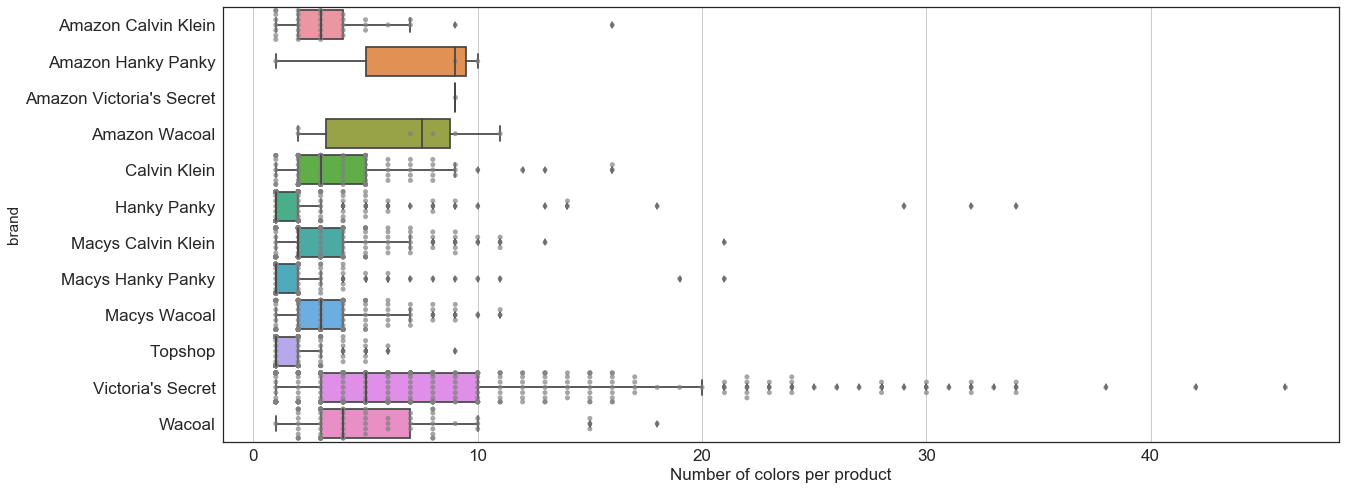

In [19]:
colors_df = pd.DataFrame()    
for name, group in brands_info.groupby('brand'):
    colors = group.groupby(['product_name']).color.nunique()
    colors_df = colors_df.append(pd.DataFrame({'color_num': colors, 'brand': name}))

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
ax = sns.boxplot(x='color_num', y = 'brand', data = colors_df, ax = axes, medianprops={"zorder":3})
ax = sns.swarmplot(x="color_num", y="brand", data=colors_df, color= 'grey', alpha = 0.7)
ax.xaxis.grid(True)
_ = ax.set_xlabel('Number of colors per product', fontsize=17)
_= ax.tick_params(axis='both', which='major', labelsize=17)


In [20]:
colors_df.groupby('brand').agg(['median', 'mean', 'count']).transpose()

brand             Amazon Calvin Klein  Amazon Hanky Panky  \
color_num median  3.0                  9.000000             
          mean    3.5                  6.666667             
          count   36.0                 3.000000             

brand             Amazon Victoria's Secret  Amazon Wacoal  Calvin Klein  \
color_num median  9.0                       7.5            3.000000       
          mean    9.0                       6.5            4.148148       
          count   1.0                       6.0            108.000000     

brand             Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  \
color_num median  1.000000     2.000000            1.000000            
          mean    2.166667     3.230392            2.276423            
          count   294.000000   204.000000          123.000000          

brand             Macys Wacoal     Topshop  Victoria's Secret     Wacoal  
color_num median  3.000000      1.000000    5.000000           4.000000   
          mean    3.345029      1.464539    7.734066           5.094595   
          count   171.000000    282.000000  455.000000         74.000000

Lets have a closer look on the products that have more than 35 colors.
(Amazon Hanky Panky has 6 colors as mean but there are only 3 unique products, two with 10 and 9 colors and one with 1 colors.)

Some models of bras and panties have an extraordinary number of colors :). 'the player racerback sport bra' has the most colors , followed by 'seamless hiphugger panty' from Victoria's Secret!

In [21]:
display(colors_df[colors_df['color_num']>=35])
del colors_df

brand  \
product_name                                                                         
seamless hiphugger panty                                         Victoria's Secret   
victoria sport lightweight by victoria sport bra                 Victoria's Secret   
victoria sport the player racerback sport bra by victoria sport  Victoria's Secret   

                                                                 color_num  
product_name                                                                
seamless hiphugger panty                                         42         
victoria sport lightweight by victoria sport bra                 38         
victoria sport the player racerback sport bra by victoria sport  46

In [22]:
#brands_info[brands_info['product_name'] == 'victoria sport the player racerback sport bra by victoria sport'].color.unique()

**Question 9**: What color dominates?

So, seems that the most products have black color (what is also expected actually) and the second most color is mostly white or bare except for some brands. And Macys Hanky Panky is red ;). 

I wonder what color is 'wild aster' offered by Wacoal.

In [23]:
colors_first = brands_info.groupby(['brand','color'])['color'].agg({'count_fir':'count'})
df_count_first = colors_first.groupby(level=0).agg('idxmax')
df_count_first = colors_first.loc[df_count_first['count_fir']].reset_index()

data_mod = brands_info[~brands_info['color'].isin(df_count_first.color.unique())]
colors_second = data_mod.groupby(['brand','color'])['color'].agg({'count_sec':'count'})
df_count_second = colors_second.groupby(level=0).agg('idxmax')
df_count_second = colors_second.loc[df_count_second['count_sec']].reset_index()

df = df_count_first.merge(df_count_second,on = 'brand')
df.columns = ['brand', '1st color', 'count 1st color', '2nd color', 'count 2nd color']
display(df)

for x in [df_count_first, df_count_second, df, data_mod, colors_first]:
    del x

brand      1st color  count 1st color  \
0   Amazon Calvin Klein       black          15                
1   Amazon Hanky Panky        bliss pink     3                 
2   Amazon Victoria's Secret  black heather  1                 
3   Amazon Wacoal             baja blue      2                 
4   Calvin Klein              black          89                
5   Hanky Panky               black          77                
6   Macys Calvin Klein        black          134               
7   Macys Hanky Panky         black          45                
8   Macys Wacoal              black          72                
9   Topshop                   black          73                
10  Victoria's Secret         black          249               
11  Wacoal                    night          50                

           2nd color  count 2nd color  
0   grey heather      9                
1   chai              2                
2   colorblock multi  1                
3   camellia rose     2                
4   white             35               
5   white             35               
6   bare              42               
7   red               19               
8   naturally nude    30               
9   multi             23               
10  coconut white     86               
11  wild aster        19

Wild auster color:
<img src='https://images-na.ssl-images-amazon.com/images/I/91Cai0vSt-L._SL1500_.jpg' style='width: 200px;'>
    


In [24]:
brands_info[(brands_info['brand']== 'Wacoal')&(brands_info['color']=='night')].head(3)

Unnamed: 0   mrp  price product_category                 product_name  \
5034  5034        13.0  7.8    panties          b.tempt'd ciao bella bikini   
5051  5051        13.0  7.8    panties          b.tempt'd ciao bella thong    
5058  5058        13.0  7.8    collections      b.sleek thong                 

                                                                                  pdp_url  \
5034  http://btemptd.wacoal-america.com/b-tempt-d-ciao-bella-bikini-btemptd-978144-p.html   
5051  http://btemptd.wacoal-america.com/b-tempt-d-ciao-bella-thong-btemptd-976144-p.html    
5058  http://btemptd.wacoal-america.com/b-sleek-thong-btemptd-976218-p.html                 

                                                                                                                                                                                                                                                                            description  \
5034  arrivederci, basic bikini. with lace featured front and center, the stretch mesh that envelops your assets create a quite tempting rear view. soft elastic at the waist and leg openings is that  thoughtful added touch we like to throw in to keep everything sitting smoothly.   
5051  because we all deserve a little of la dolce vita on a daily basis, this sexy thong also happens to be comfortable. every woman needs at least one in her lingerie collection- covered in the front, coquette in the back- and sensual all around.                                   
5058  the ultimate panty to look polished; we heat seal the seams for a smooth silhouette under anything and everything.                                                                                                                                                                  

      color  \
5034  night   
5051  night   
5058  night   

                                                                                                                                                                                                                                                                       descr_conc  \
5034  arrivederci basic bikini with lace featured front and center the stretch mesh that envelops your assets create a quite tempting rear view soft elastic at the waist and leg openings is that thoughtful added touch we like to throw in to keep everything sitting smoothly   
5051  because we all deserve a little of la dolce vita on a daily basis this sexy thong also happens to be comfortable every woman needs at least one in her lingerie collection- covered in the front coquette in the back- and sensual all around                                 
5058  the ultimate panty to look polished; we heat seal the seams for a smooth silhouette under anything and everything                                                                                                                                                             

       brand product_category_gen  
5034  Wacoal  panties              
5051  Wacoal  panties              
5058  Wacoal  panties

**Question 10**: Do some brands have more colors for only one specific product category?

(Do not forget that Victoria's Secret were pretty creative in color naming. It still can be that there are different namings for the same color.)

In [25]:
df = pd.DataFrame(brands_info.groupby(['brand','product_category_gen', 'product_name']).color.nunique()).reset_index()
def create_plot_table(col): 
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,6))

    df_temp = df[(df['product_category_gen']==col)]  
    ax = sns.boxplot(x='color',y = 'brand', data = df_temp, ax = axes, palette=purple)
    _ = ax.set_title(col)
    _ = ax.set_xlabel('Number of colors')
    ax.xaxis.grid(True)
    if col!= 'panties':
        ax = sns.swarmplot(x="color", y="brand", data=df_temp, color=".25", ax = axes)
    display(df_temp.groupby('brand').agg(['median', 'mean', 'count']).transpose())

**Bras:**
* Calvin Klein has on average 3 colors per bra.
* Victoria's Secret has around 6 colors per bra with some really interesting outliers.
* Macys Calvin Klein, Macys Wacoal and Wacoal have around 3 colors per bra.

brand         Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
color median  3.000                2.000000       3.000000      1.000000      
      mean    3.125                4.333333       3.137931      1.666667      
      count   8.000                3.000000       29.000000     9.000000      

brand         Macys Calvin Klein  Macys Wacoal    Topshop  Victoria's Secret  \
color median  2.000000            3.000000      1.000000   5.000000            
      mean    3.340426            3.185714      1.471264   6.647887            
      count   47.000000           70.000000     87.000000  71.000000           

brand            Wacoal  
color median  3.000000   
      mean    3.681818   
      count   22.000000

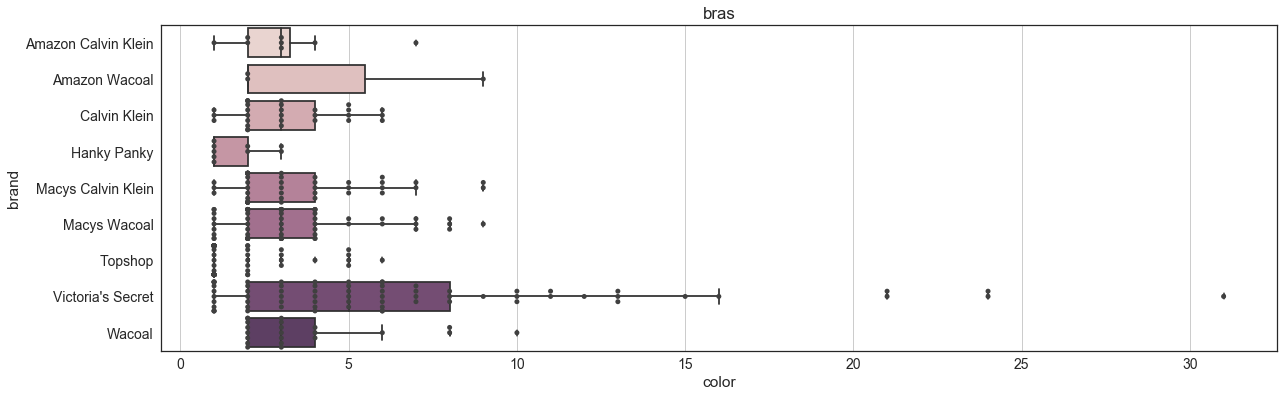

In [26]:
create_plot_table('bras')

**Panties** <br>
All means are higher comparing wirh bras (what is also expected as).

* Calvin Klein has on average 5 colors per panty.
* Victoria's Secret has around 10 colors per panty with some really interesting outliers.
* Hanky Panky only 2,5 colors per panty (I expected it to be a bit more)
* Macys Calvin Klein, Macys Wacoal and Wacoal have around 3-4 colors.
* Amazon Hanky Panky (as already mentioned before) has quite a high mean because 2 models have 9-10 colors.
* Wacoal has around 6 colors

brand         Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  \
color median  3.000000             9.000000            9.5             
      mean    4.545455             6.666667            9.5             
      count   11.000000            3.000000            2.0             

brand         Calvin Klein  Hanky Panky  Macys Calvin Klein  \
color median  5.000000      1.000000     3.000000             
      mean    5.790698      2.591837     4.013333             
      count   43.000000     147.000000   75.000000            

brand         Macys Hanky Panky  Macys Wacoal    Topshop  Victoria's Secret  \
color median  2.000000           3.000000      1.00000    7.500000            
      mean    2.830508           3.612903      1.49635    10.763158           
      count   59.000000          62.000000     137.00000  152.000000          

brand           Wacoal  
color median  6.00000   
      mean    6.30303   
      count   33.00000

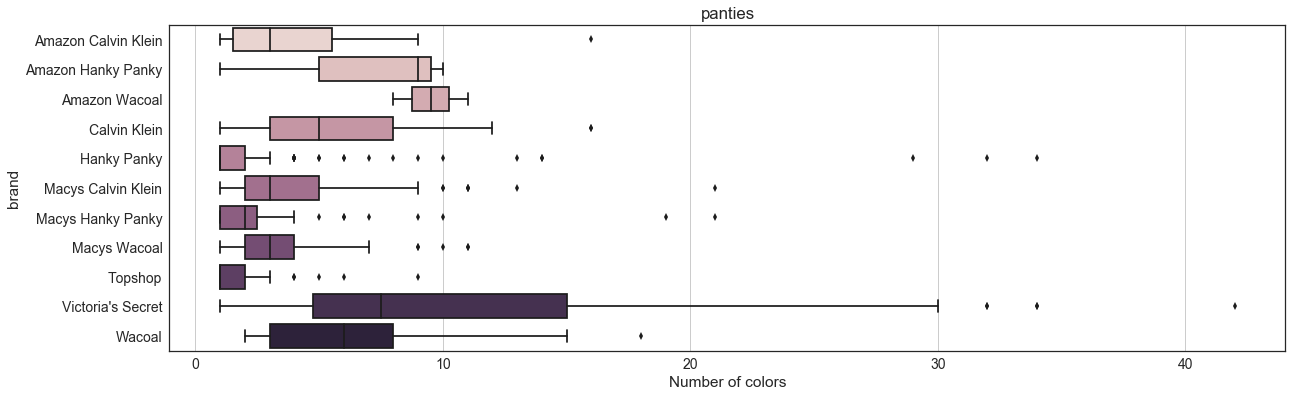

In [27]:
create_plot_table('panties')

** Active wear**
* Amazon Victoria's Secret: one product but nine colors
* Victoria's Secret has on average 7 colors. It is due to the fact that the majority of the activewear is bra.

brand         Amazon Victoria's Secret  Calvin Klein  Macys Calvin Klein  \
color median  9.0                       2.000000      2.00                 
      mean    9.0                       2.181818      2.05                 
      count   1.0                       11.000000     20.00                

brand         Macys Wacoal  Topshop  Victoria's Secret  Wacoal  
color median  3.000000      1.0      5.00000            3.0     
      mean    3.428571      1.4      7.80597            3.0     
      count   7.000000      5.0      67.00000           2.0

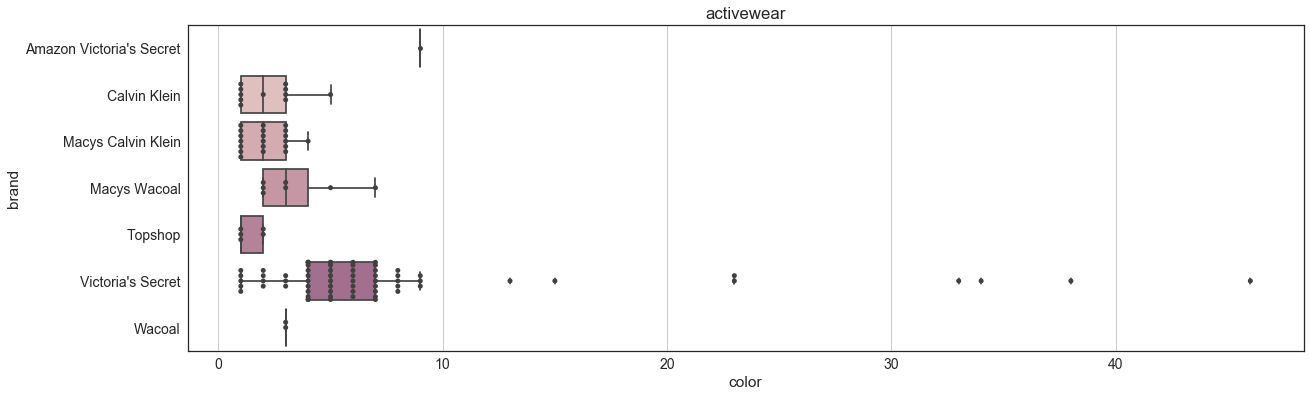

In [28]:
create_plot_table('activewear')

** Bralettes**
* Amazon Wacoal has one model with 7 colors
* Victoria's Secret has around 7 colors per product
* Hanky Panky (incl. Macys) has around 1.8 colors per product with total of around 37 products. Seems that each model comes with a small number of colors.

brand         Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
color median  3.0                  7.0            1.5           1.000000      
      mean    2.8                  7.0            2.2           1.736842      
      count   5.0                  1.0            10.0          38.000000     

brand         Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  Topshop  \
color median  3.000000            1.000000           3.000000      1.0       
      mean    3.291667            1.942857           4.333333      1.5       
      count   24.000000           35.000000          9.000000      18.0      

brand         Victoria's Secret  Wacoal  
color median  5.500000           4.500   
      mean    7.017241           6.125   
      count   58.000000          8.000

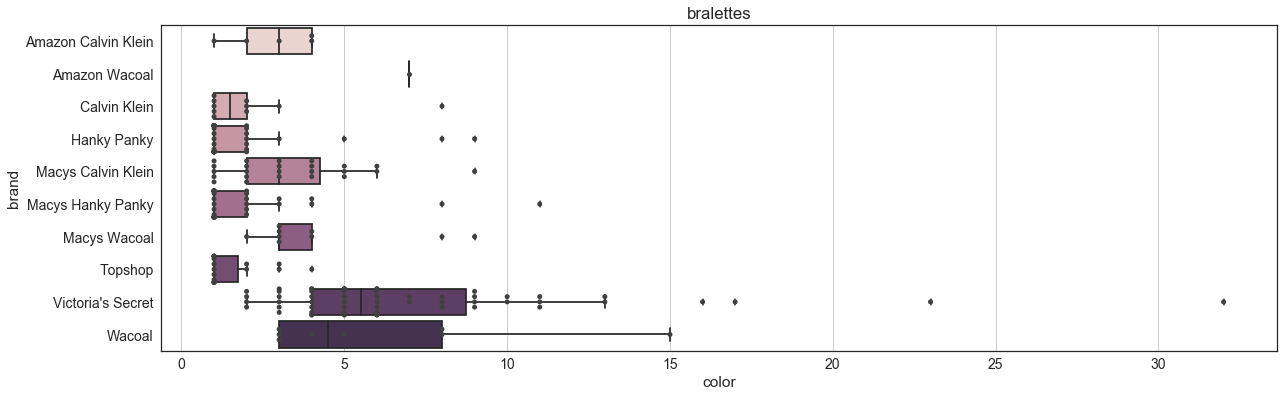

In [29]:
create_plot_table('bralettes')

# 2 Prices are so high nowadays ...
To make it simplier we will have several main categories and everything else we will simmary as 'Other'. I know, after such hard work categorizing data we will still need to unite some categories.

In [30]:
main_categories = ['bralettes','activewear','bras','panties','bodys','pack','babydoll', 'swimsuits', 'sleepwear']
brands_info['product_category'] = brands_info['product_category_gen']
brands_info['category'] = brands_info['product_category_gen']
brands_info.loc[~brands_info['category'].isin(main_categories), 'category'] = 'Other'
del brands_info['product_category_gen']

## 2.1 MRP - Maximum Retailer Price

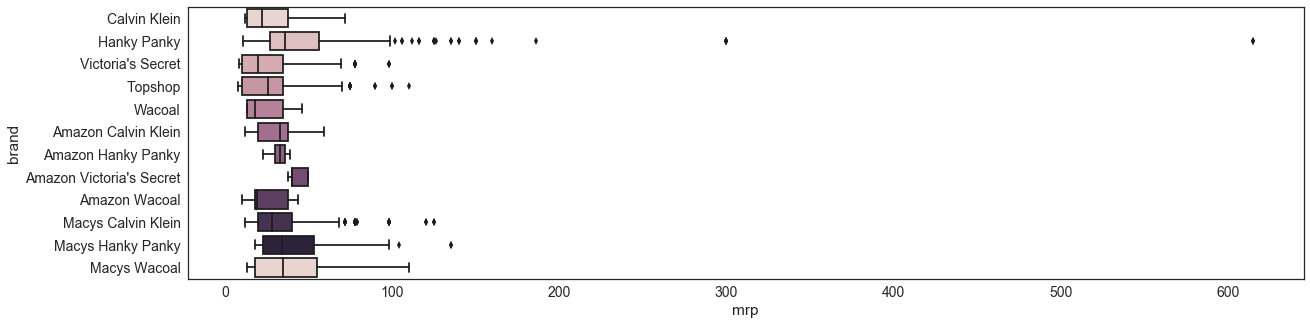

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,5))
ax = sns.boxplot(x='mrp', y= 'brand', data = brands_info, palette = purple, order = brands_name) 

**Question 11**: Hanky Panky has really several outliers. And some of them cost over 600 USD!!! What are those products?

In [32]:
brands_info[(brands_info['mrp']>300)&(brands_info['brand']=='Hanky Panky')].product_name.unique()

array(['30 pack original rise thongs in lucite jar',
       '30 pack low rise thongs in lucite jar'], dtype=object)

Want a 30 pack thongs of different colors for 600 USD? ;)

## MRP Distribution

In [33]:
def general_plot(money = 'mrp'):
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,5))
    ax = sns.boxplot(x=money, y= 'brand', data = brands_info[brands_info[money]<150], palette = purple, order = brands_name) 
    _ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)


    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,4))
    ax.xaxis.grid(True)
    ax = sns.barplot(y=money, x = 'brand', data = brands_info, palette = light_purple[1:], ax = axes[0], order = brands_name)
    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
    ax = sns.barplot(y=money, x = 'brand', data = brands_info, palette = light_purple[1:], estimator=np.median, ax = axes[1], order = brands_name)
    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)

* Macy's Calvin Klein, Macy's Hanky Panky and Hanky Panky have some product with the mrp > 120. It needs a look.
* It seems that Calvin Klein is a bit more expensive than Victoria's Secret.
* Wacoal seems to be the cheapest brand. But Macy's Wacoal is by far more expensive than OW.
* Amazon Calvin Klein is more expensive than OW Calvin Klein. (Also Macy's is a but more expensive)

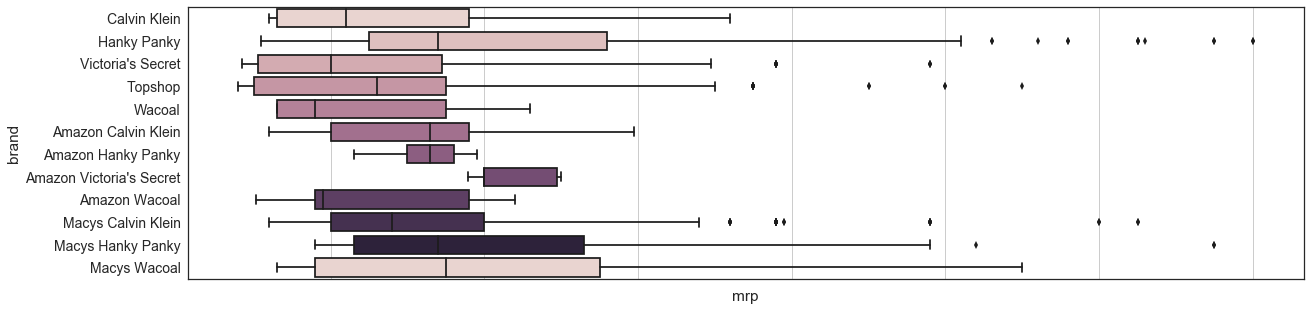

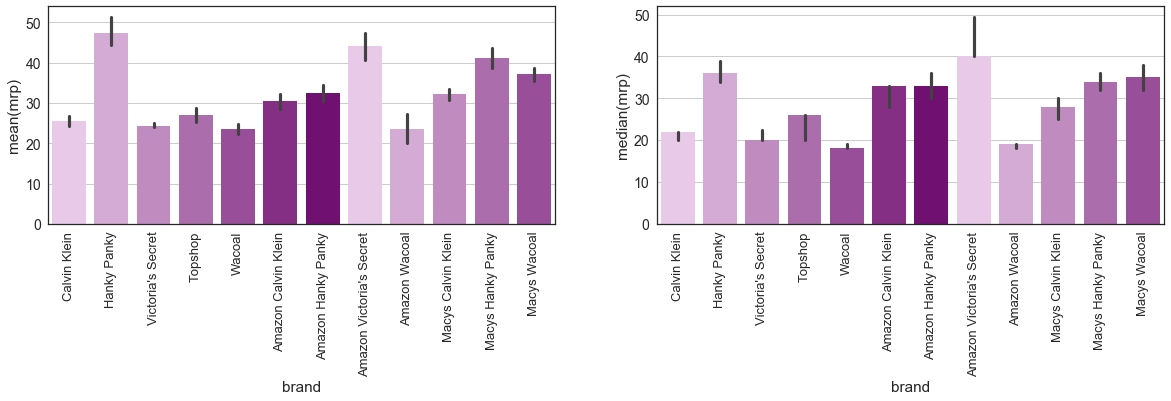

In [34]:
general_plot()

## Price Distribution
* It seems that Calvin Klein is a bit more expensive than Victoria's Secret.
* Wacoal and Victoria's Secret seem to be the cheapest brand. But Macy's Wacoal is by far more expensive than OW.
* Discounted Amazon Calvin Klein and Calvin Klein have the same prices. 

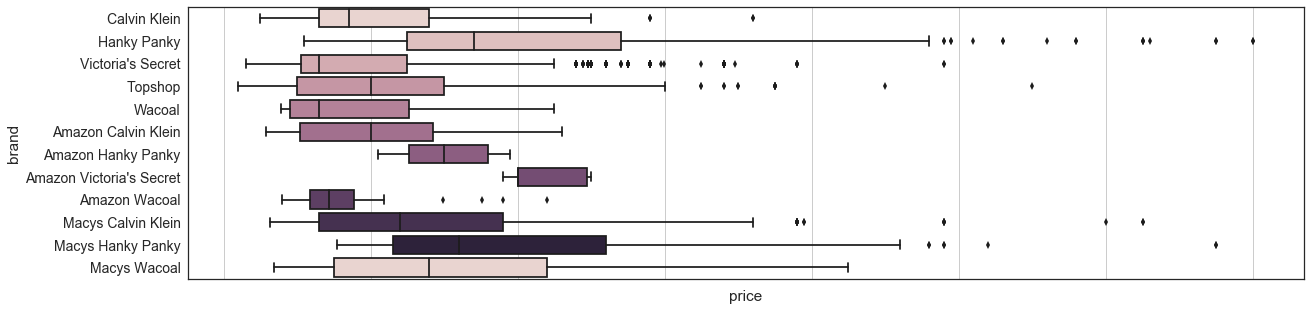

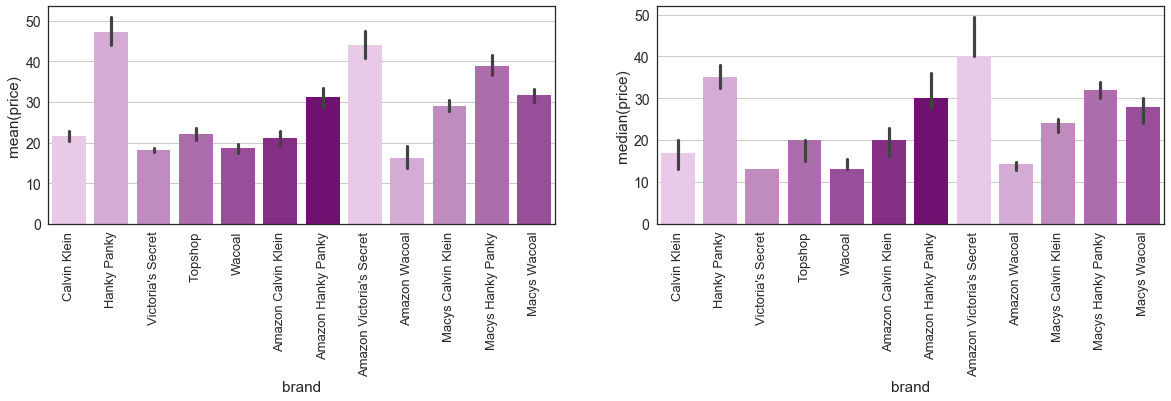

In [35]:
general_plot(money = 'price')

**Question 11**: What are all those products with the mrp > 120?

Those categories are definite the most of the expensive ones :)

In [36]:
brands_info[(brands_info['mrp']>120) & (brands_info['category']!='pack')].product_category.unique()

array(['robe', 'babydoll', 'bodys'], dtype=object)

Looks good, doesnt it?

In [37]:
brands_info[brands_info['product_name']=='alexandra lace robe']

Unnamed: 0    mrp  price product_category         product_name  \
1073  1073        140.0  140.0  robe             alexandra lace robe   

                                                          pdp_url  \
1073  http://www.hankypanky.com/lingerie/alexandra-lace-robe.html   

                description  color            descr_conc        brand category  
1073  for the love of lace.  black  for the love of lace  Hanky Panky  Other

In [38]:
from IPython.display import HTML, display
html = "<table><tr><td>Hanky Panky: sophia lace bodysuit<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/7/9/798504_black_4.jpg' style='width: 800px;'></td><td>Hanky Panky: short european flannel robe<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/2/v/2vr114_1.jpg' style='width: 800px;'></td><td>Hanky Panky: alexandra lace robe<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/9/1/91r111_black_1.jpg' style='width: 900px;'></td><td>Hanky Panky: wink plaything<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/4/t/4t8504_black_1.jpg' style='width: 900px;'></td><td>Hanky Panky: victoria chemise with g string<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/9/4/945901_2.jpg' style='width: 900px;'></td><td>Hanky Panky: heather jersey kimono robe<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/6/8/68r222_wine_1.jpg' style='width: 900px;'></td><td>Macy's Calvin Klein<img src='https://cdna.lystit.com/200/250/tr/photos/saksfifthavenue/0400093782409-black-6d6c9f31-.jpeg' style='width: 900px;'></td></tr></table>"
display(HTML(html))

# The most expensive items

**Question 11**: What is the most expensive item (by mrp) in each brand?

In [39]:
df = pd.DataFrame(brands_info.groupby('brand').mrp.max()).reset_index()
df2 = pd.DataFrame(brands_info.groupby('brand').price.max()).reset_index()
df = df.merge(df2, on='brand')
display(df)

brand     mrp   price
0   Amazon Calvin Klein       59.50   46.00 
1   Amazon Hanky Panky        39.00   39.00 
2   Amazon Victoria's Secret  49.99   49.99 
3   Amazon Wacoal             44.00   44.00 
4   Calvin Klein              72.00   72.00 
5   Hanky Panky               615.00  615.00
6   Macys Calvin Klein        125.00  125.00
7   Macys Hanky Panky         135.00  135.00
8   Macys Wacoal              110.00  85.00 
9   Topshop                   110.00  110.00
10  Victoria's Secret         98.00   98.00 
11  Wacoal                    46.00   45.00

In [40]:
expensive_items_mrp = pd.DataFrame()
expensive_items_price = pd.DataFrame()

for ind, row in df.iterrows():
    df_temp = brands_info[(brands_info['brand']==row['brand'])&(brands_info['mrp']==row['mrp'])]
    names = df_temp.product_name.unique()
    expensive_items_mrp = expensive_items_mrp.append(df_temp.iloc[0])

    df_temp = brands_info[(brands_info['brand']==row['brand'])&(brands_info['price']==row['price'])]
    listings = list(set(df_temp.product_name) - set(names))
    if len(listings)!=0:
        df_temp = df_temp[(df_temp['product_name'].isin(listings))]
        expensive_items_price = expensive_items_price.append(df_temp.iloc[0])
display(expensive_items_mrp.head(5))

Unnamed: 0                     brand    category             color  \
5498  5498.0      Amazon Calvin Klein       pack        black white grey   
5546  5546.0      Amazon Hanky Panky        panties     chai               
5556  5556.0      Amazon Victoria's Secret  activewear  hot pink           
5593  5593.0      Amazon Wacoal             bras        au natural         
446   446.0       Calvin Klein              sleepwear   grey heather       

                                                                                                                                                                                                                                                                                                                             descr_conc  \
5498  this essential bikini 5-pack features 5 pairs of cotton bikini underwear with elastic waistband printed with iconic calvin klein logo                                                                                                                                                                                               
5546  all-day comfort describes this figure-flattering bikini soft non-binding edges eliminate visible panty lines 6" modest rise; measurement taken from size m soft stretch signature lace modest 6 inch rise hanky panky style number: 9k2124                                                                                          
5556  meet our most intuitive sports bra with maximum support and sleek comfort for running boxing and high-impact work outs wider double-lined spandex sides provide an ultra smooth shape while an encased plastic underwire flexes with you adjustable straps can convert to crossback with front clip closures that snap into place   
5593  intricate lace strapless contour with nude cup lining                                                                                                                                                                                                                                                                               
446   a modern cotton zip hoodie crafted with cotton stretch fabric classic logo styling and ribbed knit detailing for a youthful sporty design                                                                                                                                                                                           

                                                                                                                                                                                                                                                                                                                                  description  \
5498  this essential, bikini 5-pack features 5 pairs of cotton bikini underwear with elastic waistband printed with iconic calvin klein logo.                                                                                                                                                                                                   
5546  all-day comfort describes this figure-flattering bikini, soft non-binding edges eliminate visible panty lines. 6" modest rise; measurement taken from size m, soft, stretch signature lace. modest, 6 inch rise. hanky panky, style number: 9k2124.                                                                                       
5556  meet our most intuitive sports bra, with maximum support and sleek comfort for running, boxing, and high-impact work outs. wider double-lined spandex sides provide an ultra smooth shape while an encased plastic underwire flexes with you. adjustable straps can convert to crossback with front clip closures that snap into place.   
5593  intricate lace strapless contour with nude cup lining                                                                                                                                                           

So, the most expensive item in our datatset is from Hanky Panky and that is 30 pairs of thongs!

In [41]:

html = "<table><tr><td>Calvin Klein<img src='https://cdnd.lystit.com/1040/1300/n/photos/shopbop/CKLEN4233210437-Black-04ad40dc-.jpeg' style='width: 900px;'></td><td>Hanky Panky<img src='http://www.hankypankyltd.netdna-cdn.com/media/catalog/product/cache/1/image/db978388cfd007780066eaab38556cef/4/8/48pk30_emul_1_1.jpg' style='width: 800px;'></td><td>Victorias Secret<img src='https://dm.victoriassecret.com/p/760x1013/tif/b4/4f/b44f5a12e28c4b8c9dcab27faae01013/V493406_OF_F.jpg' style='width: 900px;'></td><td>Topshop<img src='http://media.topshop.com/wcsstore/TopShopDE/images/catalog/TS43E04LLAC_Zoom_F_1.jpg' style='width: 900px;'></td><td>Wacoal<img src='https://a248.e.akamai.net/f/248/9086/10h/origin-d5.scene7.com/is/image/WacoalAmerica/953237_004?qlt=85,1&op_sharpen=1&resMode=bilin&op_usm=1,1,9,0&rect=0,0,261,344&scl=5.816860465116279&id=VFprq1' style='width: 900px;'></td></tr></table>"
display(HTML(html))
html = "<table><tr><td>Amazon Calvin Klein<img src='https://images-na.ssl-images-amazon.com/images/I/61wmAanrDzL._UL1500_.jpg' style='width: 900px;'></td><td>Amazon Victorias Secret<img src='https://images-na.ssl-images-amazon.com/images/I/71CxBauOwPL._UL1500_.jpg' style='width: 900px;'></td><td>Amazon Hanky Panky<img src='https://images-na.ssl-images-amazon.com/images/I/71gd1OukSaL._UL1500_.jpg' style='width: 900px;'></td><td>Amazon Wacoal<img src='https://images-na.ssl-images-amazon.com/images/I/81uAK8Lvx8L._UL1500_.jpg' style='width: 900px;'></td><td>Macys Calvin Klein<img src='https://cdna.lystit.com/200/250/tr/photos/saksfifthavenue/0400093782409-black-6d6c9f31-.jpeg' style='width: 900px;'></td><td>Macys Hanky Panky<img src='https://image.shopittome.com/apparel_images/fb/hanky-panky-hanky-panky-eyelash-lace-bodysuit-4t8504-abv6af8ff20_zoom.jpg' style='width: 900px;'></td><td>Macys Wacoal<img src='https://slimages.macysassets.com/is/image/MCY/products/0/optimized/3831480_fpx.tif?op_sharpen=1&wid=400&hei=489&fit=fit,1&$filterlrg$' style='width: 900px;'></td></tr></table>"
display(HTML(html))

**Question 12**: What is the most expensive discounted item (by price) in each brand?

In [42]:
display(expensive_items_price)

Unnamed: 0                brand  category                color  \
5527  5527.0      Amazon Calvin Klein  bras      stippled skin print   
7105  7136.0      Macys Wacoal         Other     toast                 
5399  5399.0      Wacoal               babydoll  vanilla ice           

                                                                                                                                                                                                                                                                descr_conc  \
5527  this full coverage bra features lightly lined cups with memory touch for ultimate comfort and a perfect fit |t-shirt bra                                                                                                                                               
7105  "try a little slenderness" with this amazing seamless body shaper by wacoal hidden underwire soft cups provide added support while the sleek body provides firm shaping and control style #801165                                                                      
5399  sure the chantilly lace top and three-section seamed cup evoke old hollywood glamour yet this chemise’s sheer midriff and back inspire a modern day vixen vibe let the scalloped edges peek out from under dress or wear on it’s own to set off all kinds of alarms!   

                                                                                                                                                                                                                                                                     description  \
5527  this full coverage bra features lightly lined cups with memory touch for ultimate comfort and a perfect fit. |t-shirt bra                                                                                                                                                    
7105  "try a little slenderness" with this amazing seamless body shaper by wacoal. hidden underwire soft cups provide added support while the sleek body provides firm shaping and control. style #801165                                                                          
5399  sure, the chantilly lace top and three-section seamed cup evoke old hollywood glamour. yet, this chemise’s sheer midriff and back inspire a modern day vixen vibe. let the scalloped  edges peek out from under dress, or wear on it’s own to set off all kinds of alarms!   

       mrp  \
5527  46.0   
7105  85.0   
5399  45.0   

                                                                                                                                                      pdp_url  \
5527  https://www.amazon.com/-/dp/b015udfwo0?th=1&psc=1                                                                                                         
7105  http://www1.macys.com/shop/product/wacoal-firm-control-try-a-little-slenderness-hidden-underwire-seamless-body-shaper-801165?id=370115&categoryid=65739   
5399  http://btemptd.wacoal-america.com/b-sultry-chemise-btemptd-914261-p.html                                                                                  

      price product_category  \
5527  46.0   bras              
7105  85.0   shapers           
5399  45.0   babydoll          

                                                                            product_name  
5527  calvin klein women's perfectly fit lightly lined memory touch t shirt bra           
7105  firm control try a little slenderness hidden underwire seamless body shaper 801165  
5399  b.sultry chemise

In [43]:
html = "<table><tr><td>Amazon Calvin Klein<img src='https://images-na.ssl-images-amazon.com/images/I/81LEl1kn5oL._UL1500_.jpg' style='width: 200px;'></td><td>Macys Wacoal<img src='https://slimages.macysassets.com/is/image/MCY/products/5/optimized/3640215_fpx.tif??op_sharpen=1&fit=fit,1&$filterlrg$&wid=1200&hei=1467' style='width: 200px;'></td><td>Wacoal<img src='https://images.prod.meredith.com/product/96a181a21f45ac2c2183d2076f789d9d/53fc48ce1c2d384f512eaa489f2011980c2dc667471d96e0ad01570626b111b8/l/womens-b-temptd-by-wacoal-b-sultry-chemise' style='width: 200px;'></td></tr></table>"
display(HTML(html))

So, back to the reality.

## 2.1.1 What are the MRP distributions?

In [44]:
def create_plots(cols, swarm = False, inner = None, money = 'mrp'):
    df = brands_info[brands_info[money]<=100]
    df2 = df[df['brand'].isin(cols)]
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
    ax = sns.violinplot(y=money, x='brand', data=df2, split=True,inner=inner, ax = axes, palette = light_purple)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=13)
    if swarm:
        ax = sns.swarmplot(x="brand", y=money, data=df2, color="black", alpha=.5, ax = axes)
    ax.yaxis.grid(True)
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,6))
    ax = sns.boxplot(y=money,hue='category',x = 'brand',data = df2, palette=sns.color_palette("husl", 10))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=13)
    ax.yaxis.grid(True)
    _ = ax.set_ylabel(money)    

**Question 13**: What products cause distributions and what are the reasons for the same brands have different mrp  ranges on different sites.

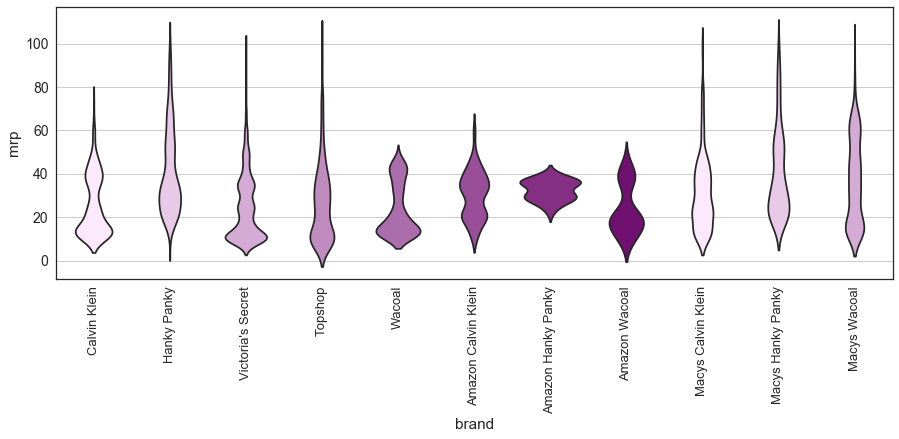

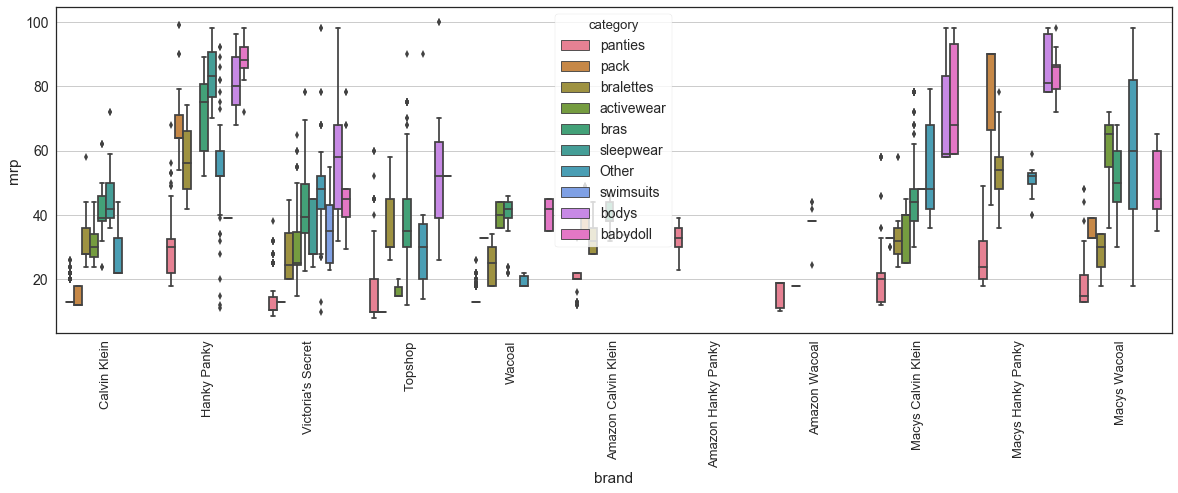

In [45]:
create_plots(['Calvin Klein', "Victoria's Secret", 'Topshop', 'Wacoal', 'Hanky Panky', 'Amazon Calvin Klein', 'Macys Calvin Klein','Amazon Hanky Panky', 'Macys Hanky Panky','Amazon Wacoal', 'Macys Wacoal'])

### Oficial Websites

* Most of the Victoria's Secret's products have the price around 12 dollars. That are the panties. The next major products have the price of around 38 dollars. And that are the bras and bodys and other products.<br>
* Calvin Klein's most products have the price around 13 dollars. <br>
* Most of Topshop products are around 12 dollars and Wacoal's products around 13 dollars.
* Hanky Panky seems to be the most expensive brand

* The peaks around 13 are panties and peaks upwards are bras, bralettes etc.

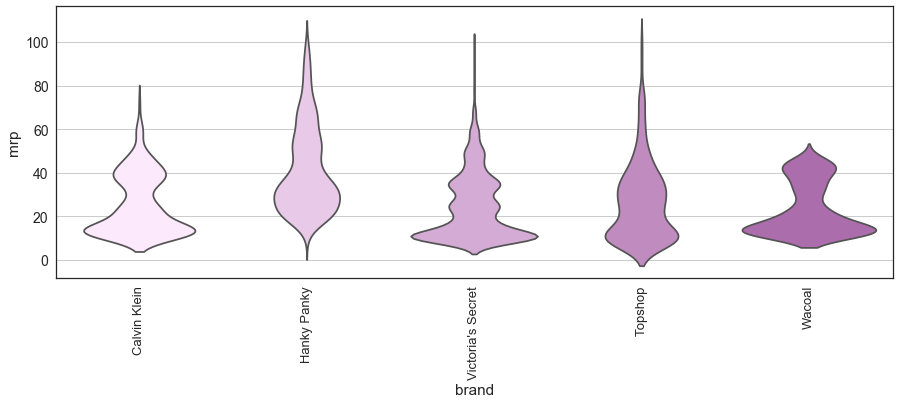

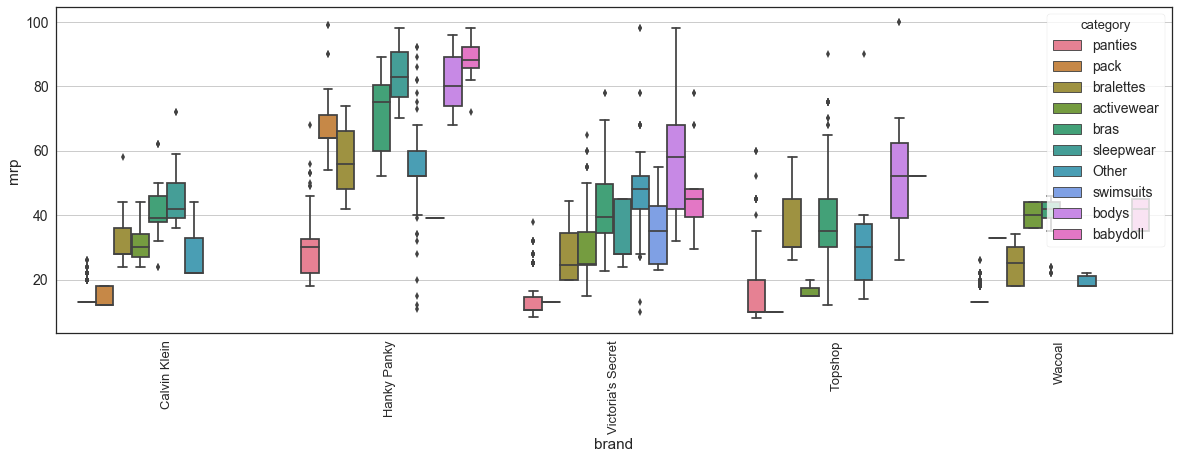

In [46]:
create_plots(['Calvin Klein', "Victoria's Secret", 'Topshop', 'Wacoal', 'Hanky Panky'])

### Calvin Klein

**Question 14:** Why is Amazon Calvin Klein more expensive than Calvin Klein Website. (Also Macy's is a bit more expensive)?

* Calvin Klein official website sells more less expensive panties (around 13 USD) than Amazon Calvin Klein (around 20 USD)
* Expensive packs (2-,3-,5- sets) are sold mainly on Amazon.
* Macy's sells expensive bodys and babydolls.

* As we know from Question 4 around 55% of products of Calvin Klein are those inexpensive panties. That is the reason why on average Calvin Klein is less expensive than Amazon. But think about packs that Amazon offers. MRP for a panty can be less in a 5-pack but you will not be able to chose the colors that you want if you are super picky :P


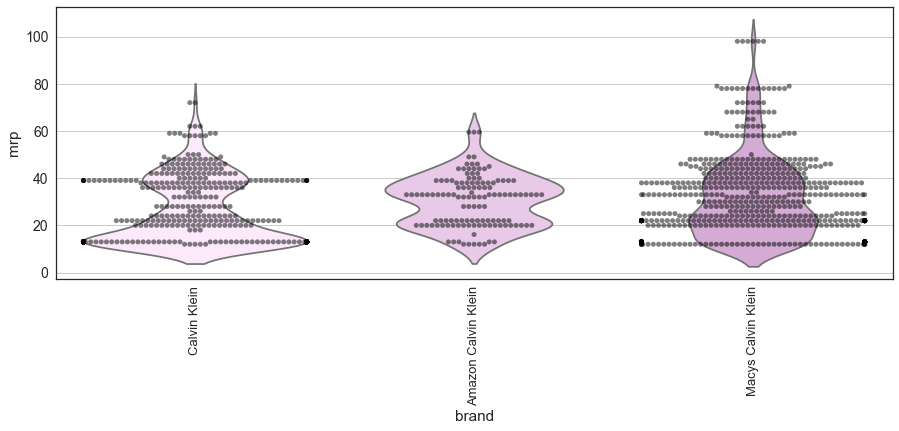

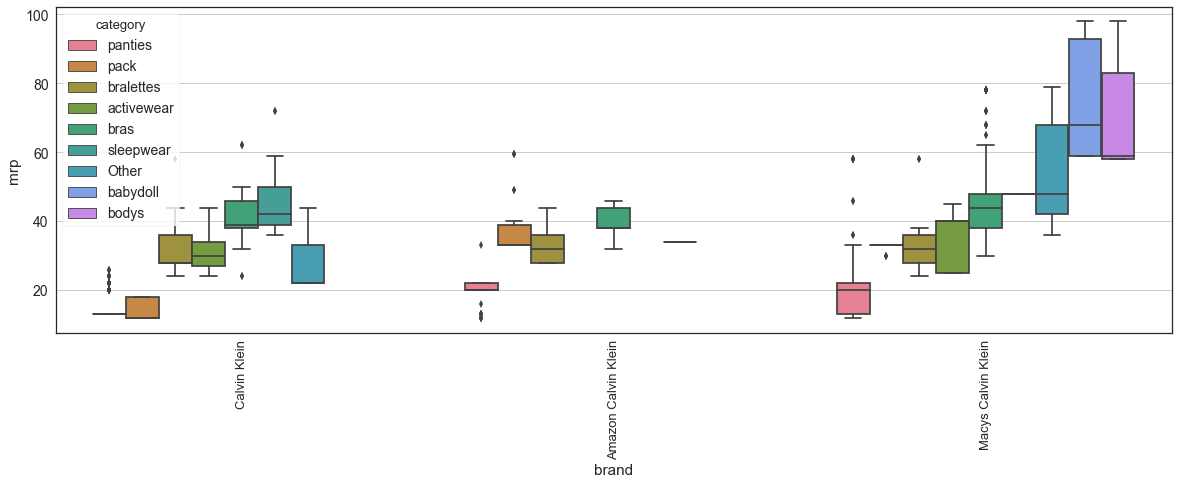

In [47]:
create_plots(['Calvin Klein', 'Amazon Calvin Klein', 'Macys Calvin Klein'],swarm = True)

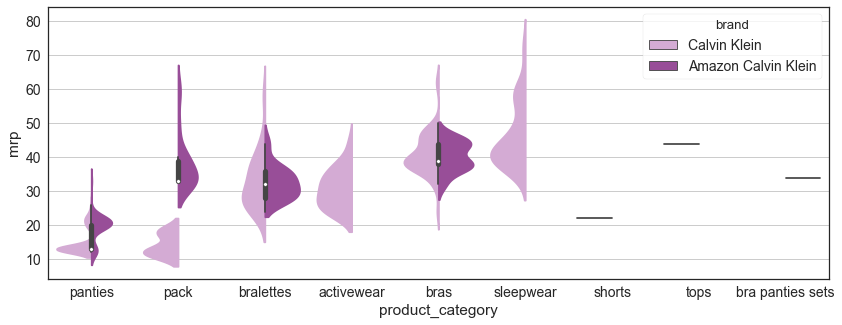

In [48]:
df = brands_info[(brands_info['brand'].isin(['Amazon Calvin Klein','Calvin Klein']))]
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(14,5))
ax = sns.violinplot(y="mrp", hue ='brand', x = 'product_category', split=True, data=df, ax = axes, palette = [light_purple[2], light_purple[5]])
ax.yaxis.grid(True)

So, in fact if you buy packs on Amazon you will pay less for each panty (around 11USD or discounted 8 USD) than on official website.

In [49]:
def find_price_per_panty(brand):
    
    pack_panties = brands_info[(brands_info['brand']==brand)&(brands_info['category']=='pack')]
    pack_panties = pack_panties[~pack_panties['product_name'].str.contains(manipul_regex(['bra', 'bralette']))]
    def find_digit(x):
        for s in x.split():
            if s.isdigit():
                return int(s)
    pack_panties['panties_num'] = pack_panties['product_name'].apply(lambda x: find_digit(x))
    mrp = (pack_panties['mrp']/pack_panties['panties_num'])
    price = (pack_panties['price']/pack_panties['panties_num'])
    return [mrp,price]

In [50]:
hankypanky_mrp, hankypanky_price = find_price_per_panty('Hanky Panky')
macysck_mrp, macysck_price = find_price_per_panty('Macys Calvin Klein')
amazonck_mrp, amazonck_price = find_price_per_panty('Amazon Calvin Klein')


In [51]:
packs_price = pd.DataFrame({'brand': 'Amazon Calvin Klein', 'mrp': amazonck_mrp})
packs_price = packs_price.append(pd.DataFrame({'brand': 'Macys Calvin Klein', 'mrp': macysck_mrp})) 
packs_price = packs_price.append(pd.DataFrame({'brand': 'Hanky Panky', 'mrp': hankypanky_mrp})) 

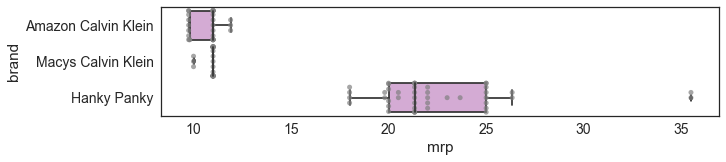

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,2))
ax = sns.boxplot(y='brand', x='mrp',data = packs_price, ax = axes, medianprops={"zorder":3},
                palette = [light_purple[2],light_purple[6]])
ax = sns.swarmplot(y='brand', x='mrp',data = packs_price, color = 'grey',alpha=0.7)

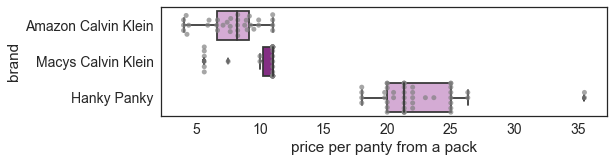

In [53]:
packs_price = pd.DataFrame({'brand': 'Amazon Calvin Klein', 'price': amazonck_price})
packs_price = packs_price.append(pd.DataFrame({'brand': 'Macys Calvin Klein', 'price': macysck_price})) 
packs_price = packs_price.append(pd.DataFrame({'brand': 'Hanky Panky', 'price': hankypanky_price})) 

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,2))
ax = sns.boxplot(y='brand', x='price',data = packs_price, ax = axes, medianprops={"zorder":3},
                 palette = [light_purple[2],light_purple[6]])
ax = sns.swarmplot(y='brand', x='price',data = packs_price, color = 'grey',alpha=0.7)
ax.set_xlabel('price per panty from a pack')

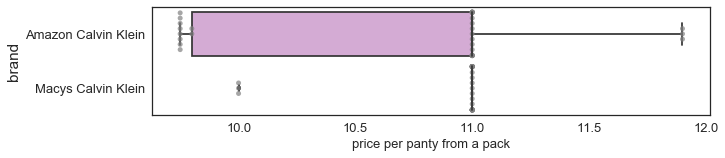

In [54]:
packs_price = pd.DataFrame({'brand': 'Amazon Calvin Klein', 'mrp': amazonck_mrp})
packs_price = packs_price.append(pd.DataFrame({'brand': 'Macys Calvin Klein', 'mrp': macysck_mrp})) 

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,2))
ax = sns.boxplot(y='brand', x='mrp',data = packs_price, ax = axes, medianprops={"zorder":3},
                palette = [light_purple[2],light_purple[6]])
ax = sns.swarmplot(y='brand', x='mrp',data = packs_price, color = 'grey',alpha=0.7)
ax.set_xlabel('price per panty from a pack',fontsize=13)
_= ax.tick_params(axis='both', which='major', labelsize=13)

### Wacoal

* Amazon sells a bit more expensive panties of Wacoal than on the official website, whereas on Macys there is a nice gradient of all prices.
* The expensive products in Other category are mainly shapers that are not sold on other sites.

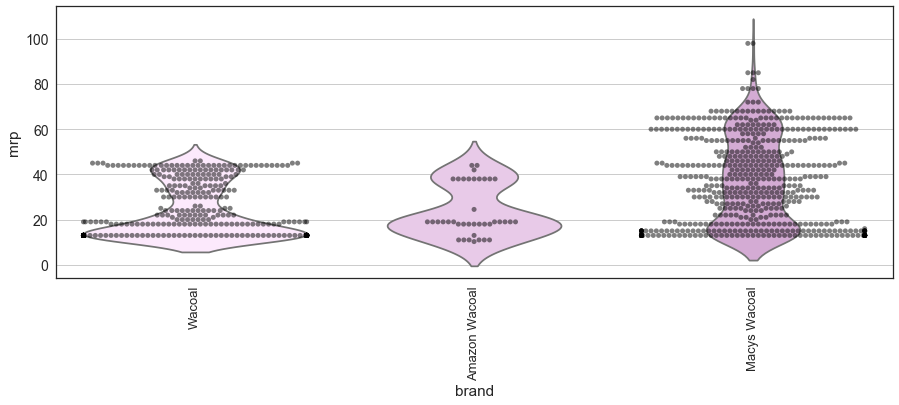

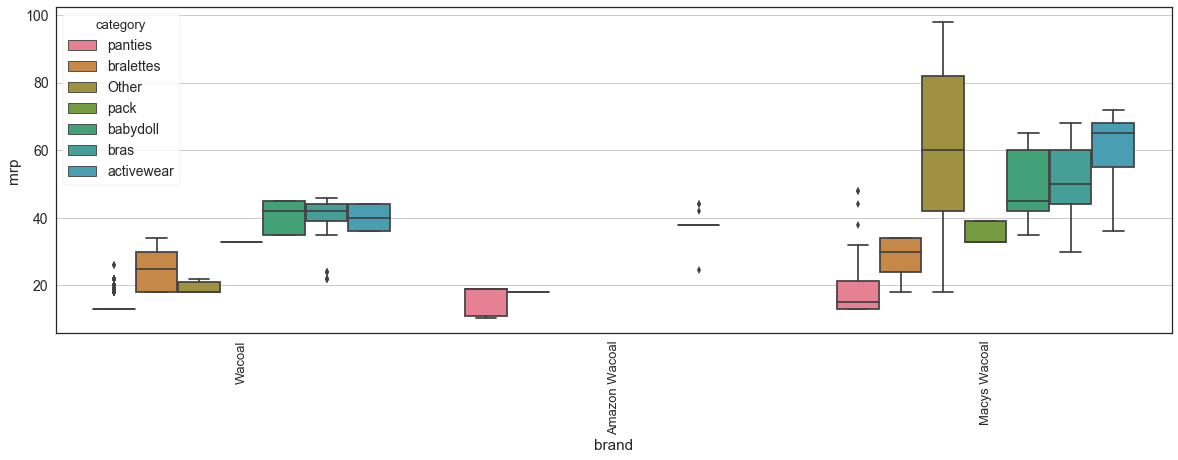

In [55]:
create_plots(['Wacoal', 'Amazon Wacoal', 'Macys Wacoal'],swarm = True)

## Hanky Panky
* Official webiste of HP and Macy sells almost the same price range of products, whereas Amazon goes for panties that are also a bit more expensive.

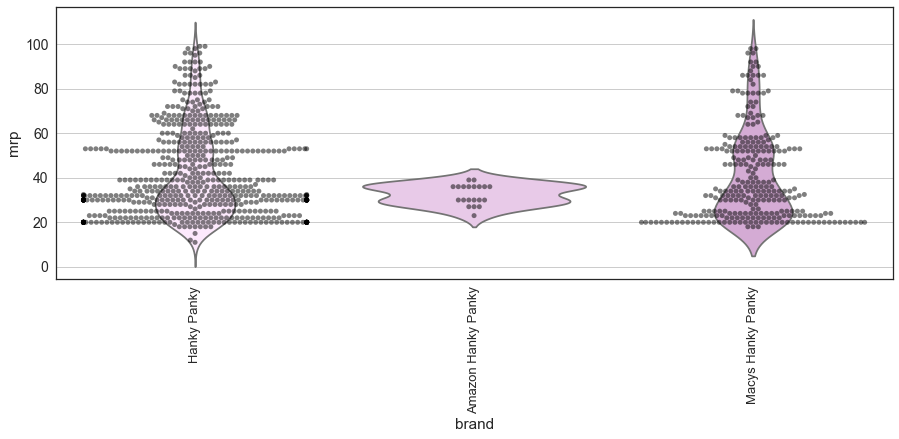

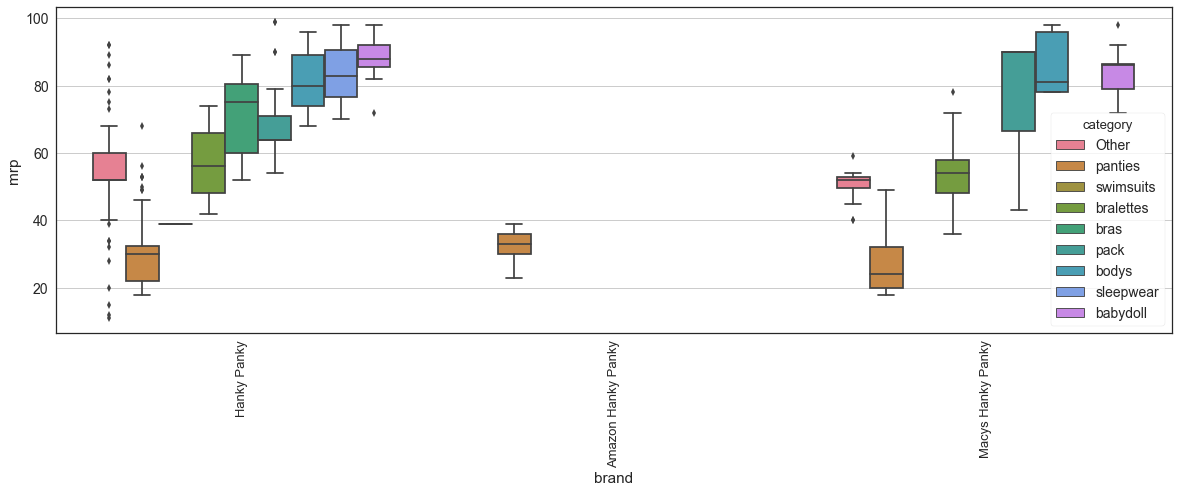

In [56]:
create_plots(['Hanky Panky', 'Amazon Hanky Panky', 'Macys Hanky Panky'],swarm = True)

In [57]:
def create_plots(cols, swarm = False, inner = None, money = 'mrp'):
    df = brands_info[brands_info[money]<=100]
    df2 = df[df['brand'].isin(cols)]
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
    ax = sns.violinplot(x=money, y='brand', data=df2, split=True,inner=inner, ax = axes, palette = [light_purple[0], light_purple[2], light_purple[5]])
    if swarm:
        ax = sns.swarmplot(x="brand", y=money, data=df2, color="black", alpha=.5, ax = axes)
    ax.yaxis.grid(True)
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(20,5))
    ax = sns.boxplot(y=money,hue='category',x = 'brand',data = df2, palette=sns.color_palette("husl", 9))
    ax.yaxis.grid(True)
    _ = ax.set_ylabel(money)

## Victoria's Secret
As we know Amazon sells only one kind of bra of Victoria's Secret. However, we have still a price distribution, meaning that the prices are different for colors or sizes or both.

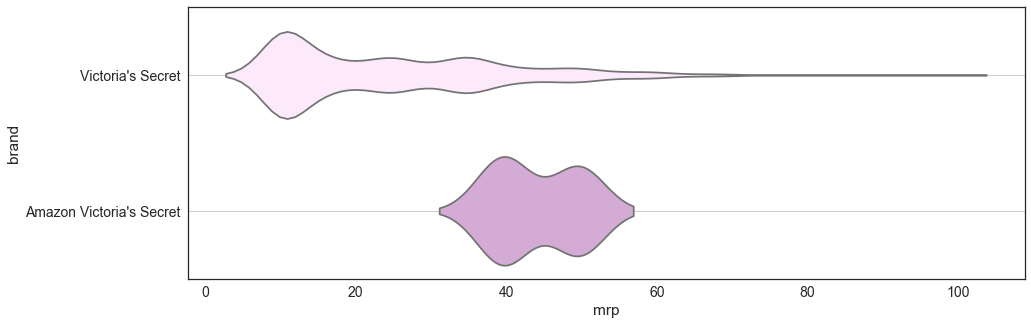

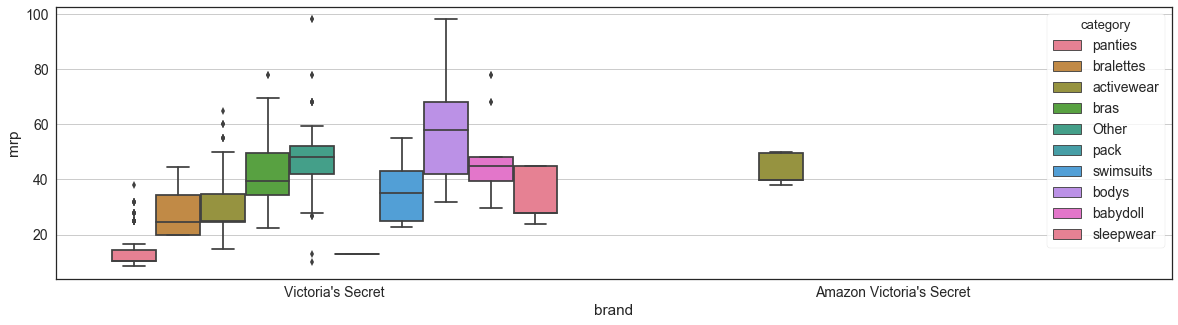

In [58]:
create_plots(["Victoria's Secret", "Amazon Victoria's Secret"],swarm = False)

## 3.2 What is more expensive: bras from Victoria's Secret or Calvin Klein?

In [59]:
def category_plots(category, data, y= 'brand',xtitle = 'mrp',money = 'mrp', swarm = True, 
                   figsize1=(15,6), figsize2=(15,6), figsize3=(20,4),
                  filename = None):
    df = data[data['category'].isin(category)]
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=figsize1)
    #ax = sns.boxplot(x=money, hue ='brand', y = 'category',  data=df, ax = axes)
    ax = sns.boxplot(x=money, y= y, data=df, ax=axes, medianprops={"zorder":3})
    if swarm:
        ax = sns.swarmplot(y = y, x=money, data=df, ax = axes, color = 'grey', alpha=0.7)
    ax.xaxis.grid(True)
    ax.set(xlabel=xtitle)
    
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=figsize2)
    ax = sns.violinplot(y=money, x=y, data=df, ax=axes, cut = 0)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.yaxis.grid(True)
    ax.set(ylabel=xtitle)
    _ = ax.set_title(", ".join(category))
    if filename!= None:
        fig.savefig(filename + '1.png')
    barplots(money,df, figsize3, x=y, xtitle = xtitle)
    


def barplots(money, df, figsize3, xtitle = 'mrp', x = 'brand', hue = None, palette = light_purple[1:]):
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=figsize3)
    ax = sns.barplot(y=money, x = x, hue = hue, data = df, palette = palette, ax = axes[0])
    ax.set(ylabel='mean(' + xtitle + ')')
    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax = sns.barplot(y=money, x = x, hue = hue, data = df, palette = palette, estimator=np.median, ax = axes[1])
    ax.set(ylabel='median(' + xtitle + ')')
    display(df.groupby('brand')[money].agg({'median'}).transpose())
    display(df.groupby('brand')[money].agg({'mean'}).transpose())

    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


**Question 14**: What is more expensive: bras from Victoria's Secret or Calvin Klein?
* Hanky Panky has the most expensive bras but also there are not so many of them (Question 4)
* Victoria's Secret has lots of bras that cost less than the majority of Calvin's Klein bras. However, VC has also bras of higher price.
* Macys Wacoal bras are more expensive than on the another representatives of Wacoal as they sell more expensive bras, whereas other (amazon and macys) sell only less expensive bras

In [60]:
for name, group in brands_info.groupby('brand'):
    print(name)
    print((group[(group['category']=='bras')].mrp<40).sum())

Amazon Calvin Klein
13
Amazon Hanky Panky
0
Amazon Victoria's Secret
0
Amazon Wacoal
10
Calvin Klein
50
Hanky Panky
0
Macys Calvin Klein
51
Macys Hanky Panky
0
Macys Wacoal
36
Topshop
88
Victoria's Secret
274
Wacoal
24


brand   Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
median  38.0                 38.0           39.0          75.0          

brand   Macys Calvin Klein  Macys Wacoal  Topshop  Victoria's Secret  Wacoal  
median  44.0                50.0          35.0     39.5               42.0

brand  Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
mean   40.1984              38.193077      40.989011     70.533333     

brand  Macys Calvin Klein  Macys Wacoal    Topshop  Victoria's Secret  \
mean   46.585987           51.089686     39.890625  42.278496           

brand     Wacoal  
mean   40.037037

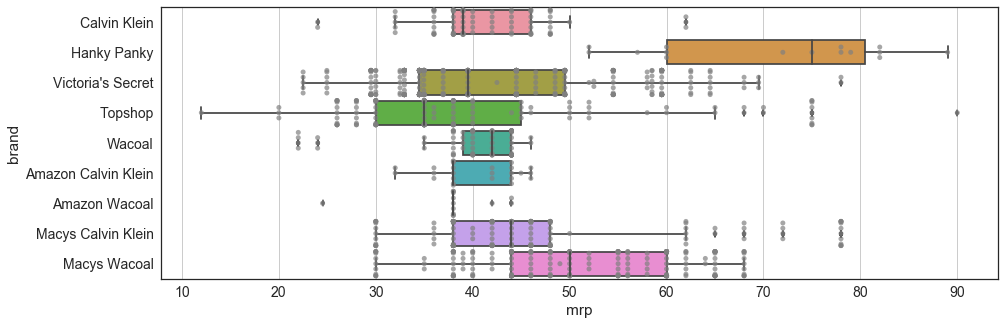

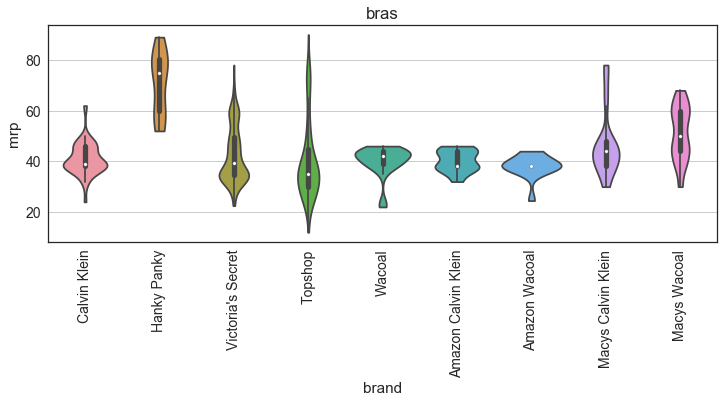

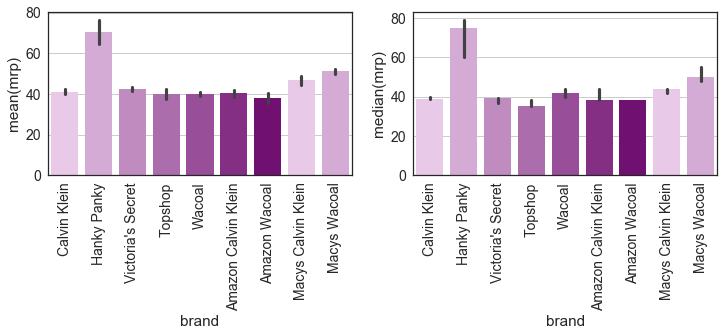

In [61]:
category_plots(['bras'], brands_info,
               figsize1=(15,5), figsize2=(12,4), figsize3=(12,3), filename = 'bras_mrp')

**Question 14**: Panties of which brand are the most expensive?
* Amazon Hanky Panky has the most expensive panties (20 products). In general, Hanky Panky has more expensive panties.
* The majority of Victoria's Secret panties tend to be a bit cheaper (do not forget Calvin Klein has an offer '3 Panties for 33USD', however, no such offer was specified for Victoria's Secret, although I know such offers exist on the website). 
* Calvin Klein has around 190 (76% of Clavin Klein's panties) with a mrp of 13 USD.
* Majority of Wacoals and Calvin Klein panties have the same price.
* Although Topshow has a wide distribution of mrp, it has quite a lot very cheap panties.
* Amazon's Calvin Klein most panties are more expensive than of the OW.
* Amazon Wacoal has bimodal distribution. In fact, it seels only 2 models of panties. Model 'ciao bella tanga panty' has the price of 19 USD, whereas model 'kiss thong panty' around 11 USD.

brand   Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
median  20.0                 33.0                19.0           13.0           

brand   Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
median  30.0         20.0                24.0               15.0           

brand   Topshop  Victoria's Secret  Wacoal  
median  10.0     10.5               13.0

brand  Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
mean   19.2822              32.5                15.698421      15.044177      

brand  Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
mean   28.931759    18.72093            26.505988          18.098214      

brand    Topshop  Victoria's Secret     Wacoal  
mean   15.504808  12.123166          14.389423

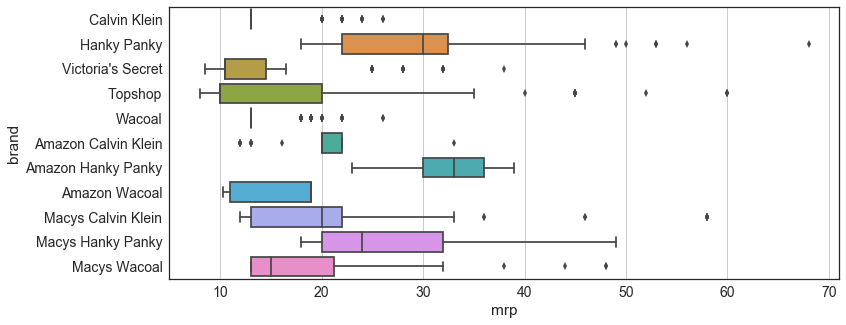

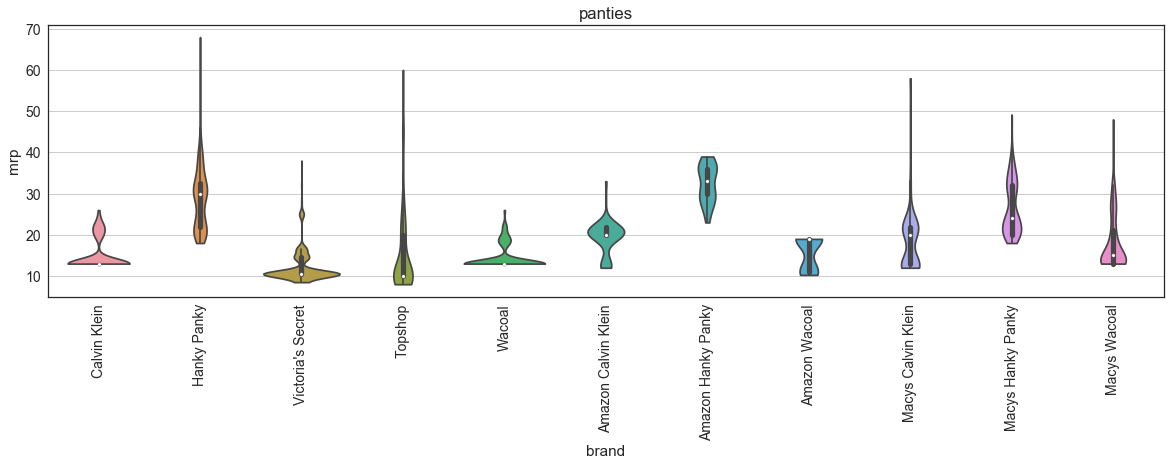

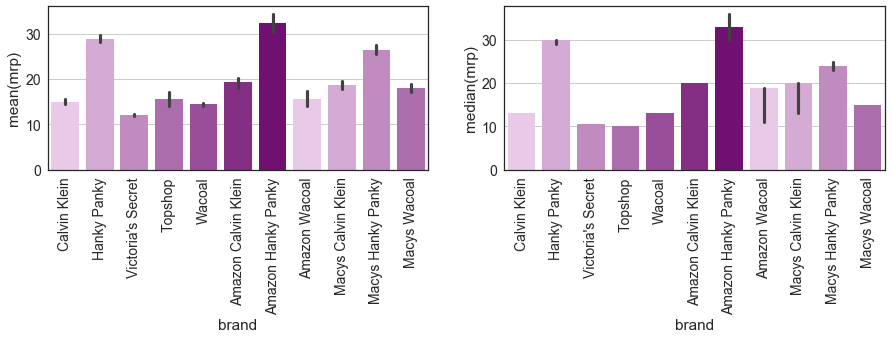

In [62]:
category_plots(['panties'], brands_info, swarm = False, figsize1=(12,5),figsize2=(20,5), figsize3=(15,3))

In [63]:
for name, group in brands_info.groupby('brand'):
    print(name)
    print((group[(group['category']=='panties')].mrp<=11).sum())

Amazon Calvin Klein
0
Amazon Hanky Panky
0
Amazon Victoria's Secret
0
Amazon Wacoal
7
Calvin Klein
0
Hanky Panky
0
Macys Calvin Klein
0
Macys Hanky Panky
0
Macys Wacoal
0
Topshop
140
Victoria's Secret
1202
Wacoal
0


In [64]:
brands_info[(brands_info['brand']=='Calvin Klein')&(brands_info['category']=='panties')].groupby('mrp').size()

mrp
13.0    190
20.0    23 
22.0    27 
24.0    6  
26.0    3  
dtype: int64

**Question 15**: Bralettes of which brand are the most expensive?
* Bralettes of Hanky Panky are the most expensive ones.
* Victoria's Secret is less expensive than CV.
* Wacoal and Victoria's Secret have the cheapest bralettes


brand   Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
median  32.0                 18.0           28.0          56.0          

brand   Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  Topshop  \
median  32.0                54.0               30.0          30.0      

brand   Victoria's Secret  Wacoal  
median  24.5               25.0

brand  Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
mean   32.571429            18.0           33.0          57.166667     

brand  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal    Topshop  \
mean   31.848101           54.808824          27.948718     38.851852   

brand  Victoria's Secret     Wacoal  
mean   26.765233          25.571429

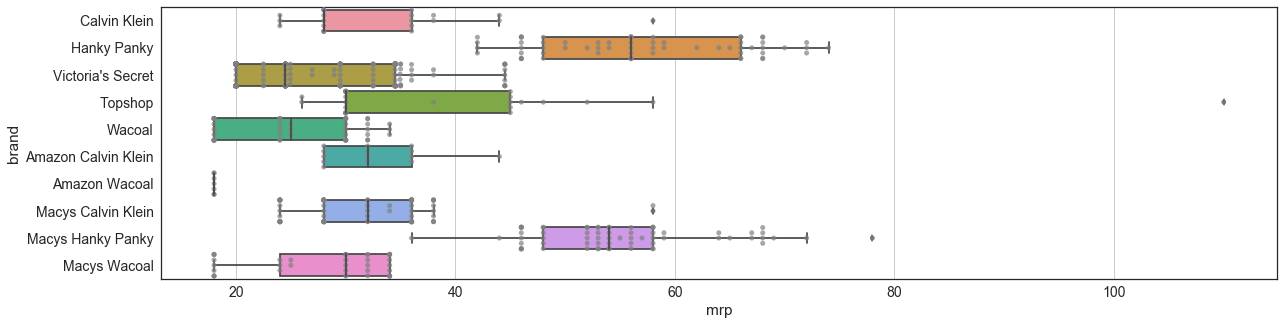

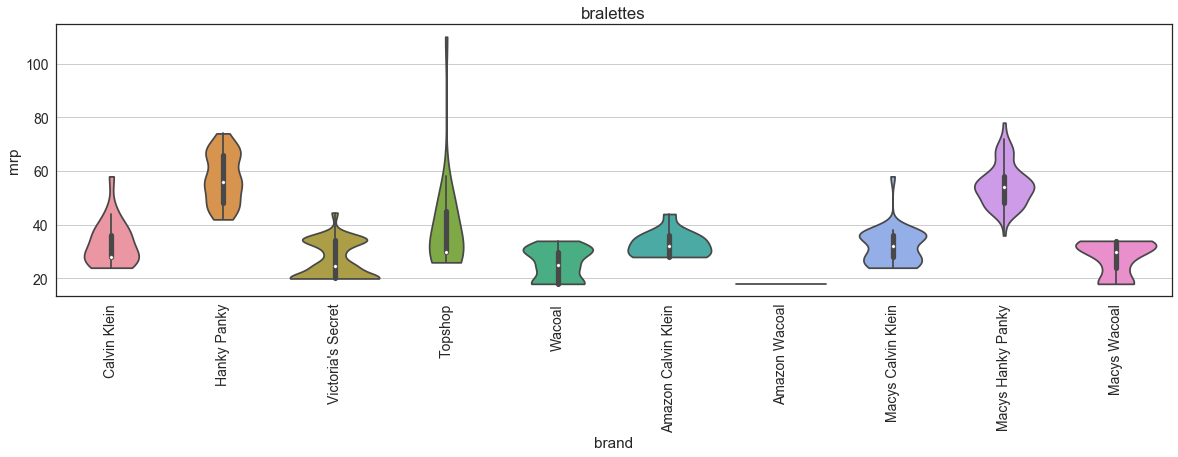

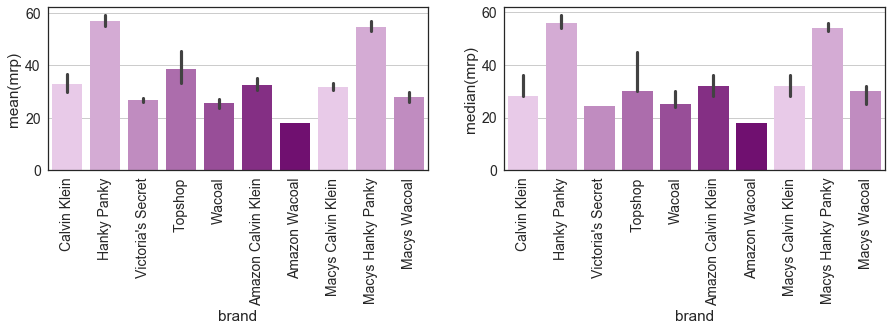

In [65]:
category_plots(['bralettes'], brands_info, figsize1=(20,5),figsize2=(20,5), figsize3=(15,3))

**Question 15**: Bodys of which brand are the most expensive?
* And again Hanky Panky is most expensive one.
* The least expensive are sold by Victoria's Secret and Topshop.

brand   Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Topshop  \
median  83.0         59.0                90.0               52.0      

brand   Victoria's Secret  
median  58.0

brand  Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Topshop  \
mean   94.294118    70.909091           95.6               55.6      

brand  Victoria's Secret  
mean   54.25

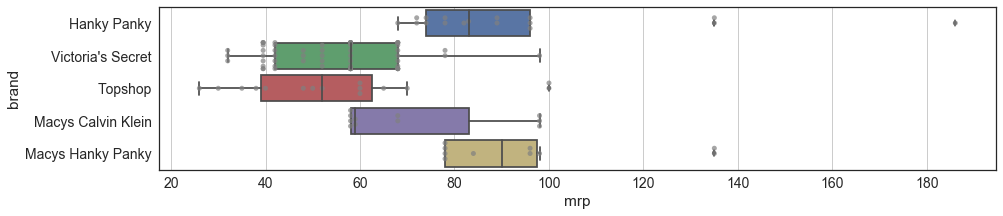

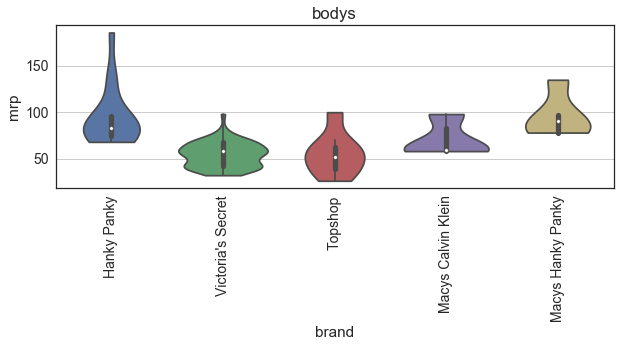

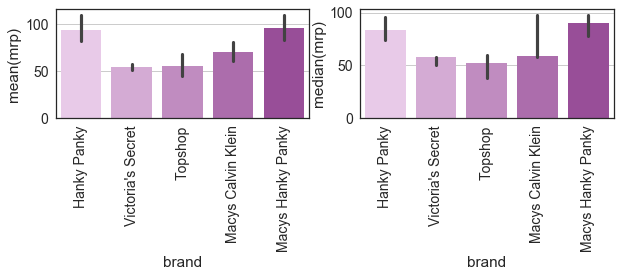

In [66]:
category_plots(['bodys'], brands_info, figsize1=(15,3), figsize2=(10,3), figsize3=(10,2))

**Question 16**: Activewear of which brand is the most expensive?
* Macy's Wacoal is by far the most expensive brand in terms of activewear (mostly sport bras)
* Victoria's Secret and Calvin Klein are kind of on the same price level, however, the majority of the products are less expensive in Victoria's Secret
* Topshop is the cheapest brand in this category (but it has only 7 products)

brand   Amazon Victoria's Secret  Calvin Klein  Macys Calvin Klein  \
median  39.99                     30.0          40.0                 

brand   Macys Wacoal  Topshop  Victoria's Secret  Wacoal  
median  65.0          15.0     24.95              40.0

brand  Amazon Victoria's Secret  Calvin Klein  Macys Calvin Klein  \
mean   44.04                     30.666667     34.551707            

brand  Macys Wacoal    Topshop  Victoria's Secret  Wacoal  
mean   60.8          16.428571  28.300287          40.0

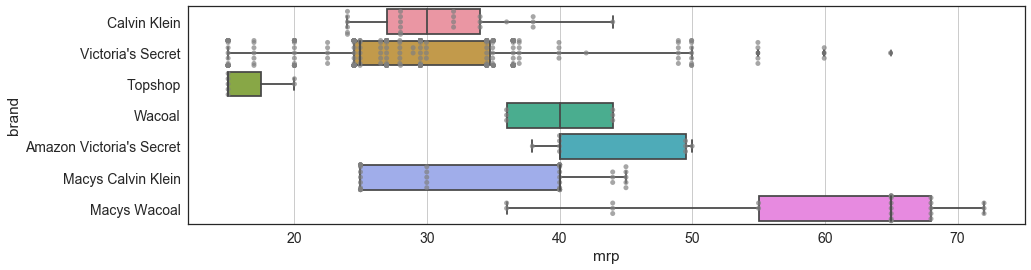

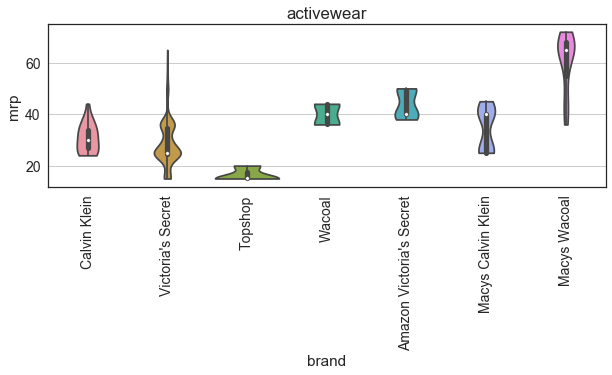

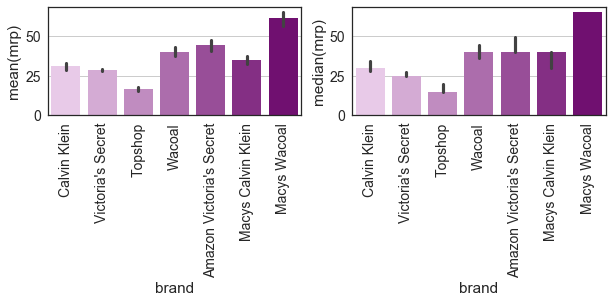

In [67]:
category_plots(['activewear'], brands_info, figsize1=(15,4), figsize2=(10,3), figsize3=(10,2))

**Question 17**: Sleepwear of which brand are the most expensive?
* Hanky Panky has the most expensive products
* Victoria's Secret is less expensive than Calvin Klein.

brand   Calvin Klein  Hanky Panky  Macys Calvin Klein  Victoria's Secret
median  42.0          90.5         48.0                28.0

brand  Calvin Klein  Hanky Panky  Macys Calvin Klein  Victoria's Secret
mean   46.085106     91.75        48.0                35.111111

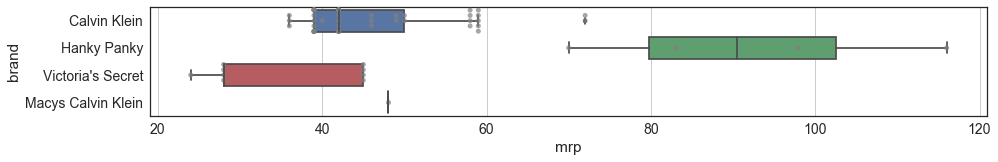

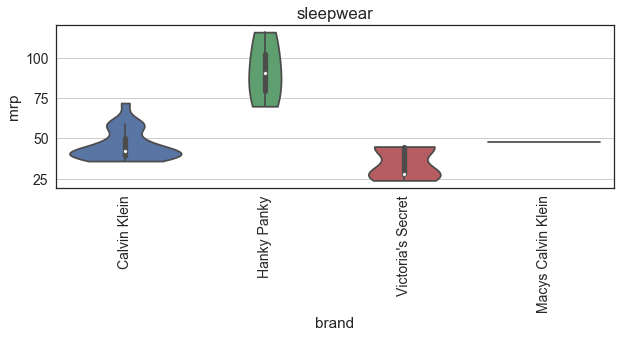

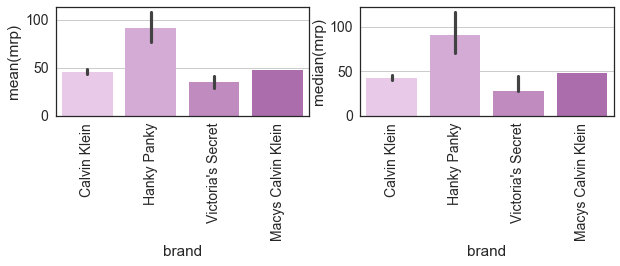

In [68]:
category_plots(['sleepwear'], brands_info, figsize1=(15,2), figsize2=(10,3), figsize3=(10,2))

Hanky Panky is the most expensive brand in following categories: sleepwear, bralettes, panties and bras!
Macy's Wacoal sells the most expensive activewear.


****************************************
**Learnings**:<br>

**Bras**:<br>
Bras are on average of the same price approximatelly for other brands like Calvin Klein, Victoria's Secret, Topshop and Wacoal. However, some brands like Topshop, VS and Macys Wacoal have either a bimodal distribution (meaning they sell both: less expensive and expensive bras) or several big outliers.

**Panties**:<br>
The majority of Wacoal, Topshop, Calvin Klein and Victoria's Secret panties are around 10-15 USD.
Hanky Panky (OW and Amazon) has more expensive panties. 
The majority of Victoria's Secret panties tend to be the cheapest.

**Bralettes**:<br>
Victoria's Secret and Wacoal have the cheapest bralettes.

**Bodys**:<br>
Only 5 brands sell bodies. The least expensive are sold by Victoria's Secret and Topshop.

**Activwear**:<br>
Victoria's Secret and Calvin Klein are kind of on the same price level, however, the majority of the products are less expensive in Victoria's Secret
****************************************

**Question 18:** Is Victoria's Secret  or Calvin Klein cheaper?
At the begining we saw that Calvin Klein was a bit more expensive than Victoria's Secret but is it in all categories?

Sleepwear, activewear, panties and barlettes of Calvin Klein are more expensive than of Victoria's Secret.

In [69]:
def barplots_extra(money, df, figsize3, xtitle = 'mrp', x = 'brand', hue = None, palette = light_purple[1:]):
    fig, axes = plt.subplots(nrows=2, ncols=1,figsize=figsize3)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    ax = sns.barplot(y=money, x = x, hue = hue, data = df, palette = palette, ax = axes[0])
    ax.set_ylabel('mean(' + xtitle + ')', fontsize=13)
    ax.set_xlabel('category', fontsize=12)
    ax.yaxis.grid(True)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _= ax.tick_params(axis='both', which='major', labelsize=14)

    ax = sns.barplot(y=money, x = x, hue = hue, data = df, palette = palette, estimator=np.median, ax = axes[1])
    ax.set_ylabel('median(' + xtitle + ')', fontsize=13)
    display(df.groupby('brand')[money].agg({'median'}).transpose())
    ax.set_xlabel('category', fontsize=12)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _= ax.tick_params(axis='both', which='major', labelsize=14)
    ax.yaxis.grid(True)


brand   Calvin Klein  Victoria's Secret
median  22.0          20.0

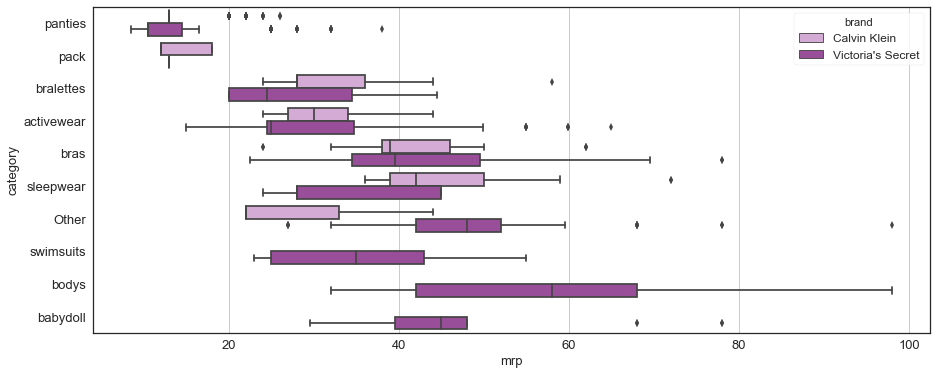

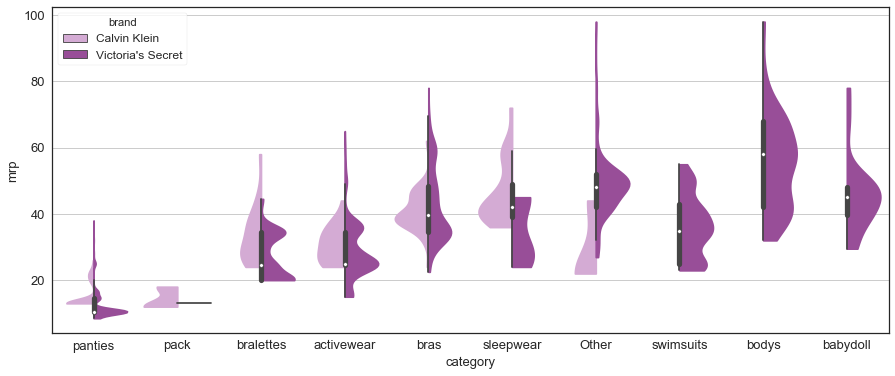

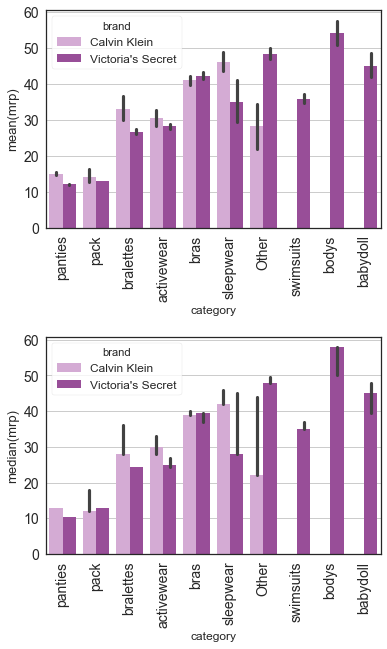

In [70]:
sns.set(font_scale = 1.2)
sns.set_style('white', {'legend.frameon':True})
df = brands_info[brands_info['brand'].isin(['Calvin Klein', "Victoria's Secret"])]
df = df[df['product_category']!='Other']
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,6))
ax = sns.boxplot(y = 'category', x="mrp", hue='brand', data=df, ax=axes, palette = [light_purple[2], light_purple[5]])
#ax = sns.swarmplot(y = 'category', hue = 'brand', x="mrp", data=df, ax = axes, color = 'grey')
_= ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('mrp', fontsize=13)
ax.set_ylabel('category', fontsize=13)
ax.xaxis.grid(True)
fig.savefig('calvin_victoria_boxplot.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,6))
ax = sns.violinplot(y="mrp", hue ='brand', x = 'category',cut = 0, split=True, data=df, ax = axes, palette = [light_purple[2], light_purple[5]])
ax.yaxis.grid(True)
_= ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('mrp', fontsize=13)
ax.set_xlabel('category', fontsize=13)
fig.savefig('calvin_victoria_violin.png')

barplots_extra('mrp', df, (6,10), hue = 'brand', x='category', palette = [light_purple[2], light_purple[5]])


# 3. It is all about the discounts ...

## 3.1 Discount category
But in fact, when we shop we are searching for the discounts. Discounts will be defined as mrp - price as this is what we always see on the websites. There will be three discount categories: low (between 0 and 8), middle (between 9 and 17) and high (above 18).

Disclaimer: Because the data was scapped during two months, it might happen that discounts do not occur at the same time. (A bra could be discounted on 10.08 but had it normal mrp on 12.08 again and discount for some panties could start from the 14.08)

In [71]:
def find_discount(data):
    data['diff'] = (data['mrp'] - data['price']).round(2)
    data['diff_categories'] = ''
    data.loc[(data['diff'] < 9) & (data['diff'] != 0.0), 'diff_categories'] = 'low'
    data.loc[(data['diff'] >= 9) & (data['diff'] < 18), 'diff_categories'] = 'middle'
    data.loc[(data['diff'] >= 18), 'diff_categories'] = 'high'
    data.loc[(data['diff'] == 0.0), 'diff_categories'] = 'no'   
    data['discount'] = "no"
    data.loc[(data['diff'] > 0.0), 'discount'] = 'yes'   
    return data

In [72]:
brands_info = find_discount(brands_info)

In [73]:
def stacked_all(data, category, name = None, discount_cat = 'diff_categories'):
    fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,10))
    tab = pd.crosstab(data[discount_cat], data[category]).transpose()
    if 'high (>=50%)' in tab.columns:
        ordering = ['high (>=50%)','middle (20%>=x<50%)','low (<20%)','no']
    else:
        ordering = ['high','middle','low','no']
    cor = [x for x in ordering if x in tab.columns] + [x for x in tab.columns if x not in ordering]
    tab = tab[cor]

    tab_prop = tab.div(tab.sum(1).astype(float), axis=0)  
    tab_pro = tab_prop.append(pd.DataFrame([1])).drop(0, axis=1) 
    display(tab_pro.transpose())
    ##f7caf2
    colors = ["#755791","#c06c84", "#f67280", "#f8b195"] 
    

    tab_pro.reindex(tab_pro.index.tolist()).plot(kind="bar", stacked=True, ax = ax[0], fontsize = 9, color = colors)  
    ax[0].yaxis.grid(True)
    df = tab.transpose()
    bbox=[0, 0, 1, 1]
    ax[1].axis('off')
    mpl_table = ax[1].table(cellText = df.values, rowLabels = df.index, 
                            colLabels=df.columns, bbox = bbox)

    plt.legend(fontsize=9)
    #ax[0].set_xlabel("Difference between RMP and price", fontsize = 10 )
    ax[0].set_title(name)


In [74]:
def stacked_all(data, category, name = None):
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,3))
    tab = pd.crosstab(data['diff_categories'], data[category]).transpose()
    display(tab)

    tab_prop = tab.div(tab.sum(1).astype(float), axis=0)  
    tab_pro = tab_prop.append(pd.DataFrame([1])).drop(0, axis=1) 
    display(tab_pro.transpose())

    tab_pro.reindex(tab_pro.index.tolist()).plot(kind="bar", stacked=True, ax = ax, fontsize = 9)


**Question 19**: Which product category falls into which discount category?
* Around 56% of bras and activewear and 52% of bralettes are discounted. 
* Only 20% of panties are discounted (do not forget there are special offers like 3 for 33 USD etc)
* 25% of babydolls and 34% of bras have a high discount. 

diff_categories  high  low  middle    no
category                                
Other            50    9    22      256 
activewear       50    54   257     274 
babydoll         32    2    17      76  
bodys            19    0    8       86  
bralettes        106   103  190     379 
bras             412   10   246     537 
pack             8     13   28      111 
panties          7     550  164     2742
sleepwear        13    1    6       41  
swimsuits        22    0    32      170

Other  activewear  babydoll     bodys  bralettes      bras  \
high    0.148368  0.078740    0.251969  0.168142  0.136247   0.341909   
low     0.026706  0.085039    0.015748  0.000000  0.132391   0.008299   
middle  0.065282  0.404724    0.133858  0.070796  0.244216   0.204149   
no      0.759644  0.431496    0.598425  0.761062  0.487147   0.445643   

           pack   panties  sleepwear  swimsuits   0  
high    0.05000  0.002021  0.213115   0.098214  NaN  
low     0.08125  0.158822  0.016393   0.000000  NaN  
middle  0.17500  0.047358  0.098361   0.142857  NaN  
no      0.69375  0.791799  0.672131   0.758929  NaN

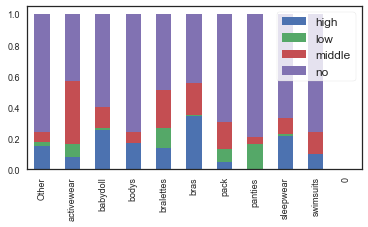

In [75]:
stacked_all(brands_info, 'category')

brand     Amazon Calvin Klein  Amazon Hanky Panky  Amazon Victoria's Secret  \
discount                                                                      
no        19                   15                  9                          
yes       107                  5                   0                          

brand     Amazon Wacoal  Calvin Klein  Hanky Panky  Macys Calvin Klein  \
discount                                                                 
no        7              323           631          535                  
yes       32             125           6            124                  

brand     Macys Hanky Panky  Macys Wacoal  Topshop  Victoria's Secret  Wacoal  
discount                                                                       
no        259                374           289      2050               161     
yes       21                 199           127      1469               216

Amazon Calvin Klein  Amazon Hanky Panky  Amazon Victoria's Secret  \
no   0.150794             0.75                1.0                        
yes  0.849206             0.25                0.0                        

     Amazon Wacoal  Calvin Klein  Hanky Panky  Macys Calvin Klein  \
no   0.179487       0.720982      0.990581     0.811836             
yes  0.820513       0.279018      0.009419     0.188164             

     Macys Hanky Panky  Macys Wacoal   Topshop  Victoria's Secret    Wacoal  
no   0.925              0.652705      0.694712  0.582552           0.427056  
yes  0.075              0.347295      0.305288  0.417448           0.572944

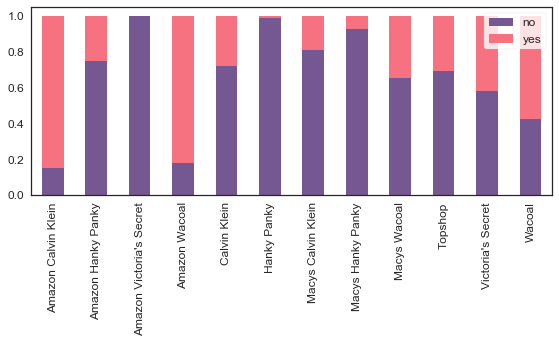

In [76]:
tab = pd.crosstab(brands_info['discount'], brands_info['brand']).transpose()
display(tab.transpose())

tab_prop = tab.div(tab.sum(1).astype(float), axis=0)  
tab_pro = tab_prop.append(pd.DataFrame([1])).drop(0,axis=1) 
tab_pro.drop(tab_pro.index[12], inplace = True)
display(tab_pro.transpose())
colors = ["#755791", "#f67280"]
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,5))
_ = tab_pro.reindex(tab_pro.index.tolist()).plot(kind="bar", stacked=True, ax = ax, fontsize = 9, color = colors)
_= ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
fig.savefig('percent_discount.png')


**Question 20:** Which product category falls into wich discount category for each brand?

**Amazon Calvin Klein** 
* all (14) bralettes, 80% of bras and packs were discounted.
* 50% (7) of bralettes, 20% (5) of bras and 21% (8) of packs were highly discounted 
* 88% (44) of panties were discounted 

**Amazon Hanky Panky** 
* 5 out of 20 panties were discounted (middle or low)

**Amazon Wacoal** 
* all (7) bralettes, 86% (11) of bras and 70% (14) of panties were discounted

**Calvin Klein** 
* 53% (48) of bras, 46% (11) of activewear, 32% (15) of sleepwear, 22% of barletes were discounted
* 22% of bralettes, 20% of bras and 25% of sleepwear were highly discounted

**Hanky Panky**
* had only 1 bra, 1 barlette and 1 body highly discounted. Everything else is not discounted.

**Macys Calvin Klein** 
* 40% (16) of activewear, 35% (19) of bralettes, 21% (7) of packs, 20% (2) of babydools, 17% (43) of panties were discounted.
* 17% of bras were highly discounted.

**Macys Hanky Panky**
* 23% (4) of babydolls, 17% (12) of bralettes and some panties were discounted.
* All discounted babydolls and bralettes had a "high" discount.

**Macys Wacoal**
* 74% (17) of Other, 56% (14) of activewear, 53% (12) of babydoll, 33% (13) of bralettes and 31% (67) of bras, 33% (72) of panties were discounted.
* 48% of activewear, 43% of babydoll, 22% of bras were highly discounted

**Topshop**
* 57% (4) of activewear, 40% (6) of bodys, 36% (47) of bras, 23% (54) of panties and 15% (4) of bralettes were discounted.

**Victoria's Secret** 
* 86% (405) of bras and 74% (300) of bralettes, 60% (311) of activewear and 51% (23) of babydoll were discounted.
* 59% of bras were highly discounted
* 19% (310) of panties were discounted (seems like 19% not that much, but if you look at the absolute number ;) )

**Wacoal**
* 58% (122) of panties, 53% (9) of babydolls, 50% (41) of bras, 49% (24) of bralettes were discounted.

diff_categories  high  low  middle  no
category                              
Other            0     0    0       1 
bralettes        7     2    5       0 
bras             5     5    10      5 
pack             8     12   9       7 
panties          0     24   20      6

Other  bralettes  bras      pack  panties   0
high    0.0    0.500000   0.2   0.222222  0.00    NaN
low     0.0    0.142857   0.2   0.333333  0.48    NaN
middle  0.0    0.357143   0.4   0.250000  0.40    NaN
no      1.0    0.000000   0.2   0.194444  0.12    NaN

diff_categories  low  middle  no
category                        
panties          3    2       15

panties   0
low     0.15    NaN
middle  0.10    NaN
no      0.75    NaN

diff_categories  no
category           
activewear       9

activewear   0
no  1.0        NaN

diff_categories  high  low  middle  no
category                              
bralettes        0     6    1       0 
bras             6     2    3       2 
panties          0     14   0       5

bralettes      bras   panties   0
high    0.000000   0.461538  0.000000 NaN
low     0.857143   0.153846  0.736842 NaN
middle  0.142857   0.230769  0.000000 NaN
no      0.000000   0.153846  0.263158 NaN

diff_categories  high  low  middle   no
category                               
Other            0     0    0       7  
activewear       3     1    7       13 
bralettes        5     0    0       17 
bras             19    2    27      43 
pack             0     0    0       8  
panties          0     30   16      203
sleepwear        12    1    2       32

Other  activewear  bralettes      bras  pack   panties  sleepwear   0
high    0.0    0.125000    0.227273   0.208791  0.0   0.000000  0.255319  NaN
low     0.0    0.041667    0.000000   0.021978  0.0   0.120482  0.021277  NaN
middle  0.0    0.291667    0.000000   0.296703  0.0   0.064257  0.042553  NaN
no      1.0    0.541667    0.772727   0.472527  1.0   0.815261  0.680851  NaN

diff_categories  high  middle   no
category                          
Other            0     0       93 
babydoll         0     0       15 
bodys            1     0       16 
bralettes        1     0       65 
bras             1     0       14 
pack             0     0       44 
panties          0     1       380
sleepwear        0     0       4  
swimsuits        0     2       0

Other  babydoll     bodys  bralettes      bras  pack   panties  \
high    0.0    0.0       0.058824  0.015152   0.066667  0.0   0.000000   
middle  0.0    0.0       0.000000  0.000000   0.000000  0.0   0.002625   
no      1.0    1.0       0.941176  0.984848   0.933333  1.0   0.997375   

        sleepwear  swimsuits   0  
high    0.0        0.0       NaN  
middle  0.0        1.0       NaN  
no      1.0        0.0       NaN

diff_categories  high  low  middle   no
category                               
Other            1     0    1       23 
activewear       3     0    13      25 
babydoll         2     0    0       8  
bodys            0     0    0       11 
bralettes        3     0    16      60 
bras             28    0    0       129
pack             0     1    6       27 
panties          2     6    41      252
sleepwear        1     0    0       0

Other  activewear  babydoll  bodys  bralettes      bras      pack  \
high    0.04   0.073171    0.2       0.0    0.037975   0.178344  0.000000   
low     0.00   0.000000    0.0       0.0    0.000000   0.000000  0.029412   
middle  0.04   0.317073    0.0       0.0    0.202532   0.000000  0.176471   
no      0.92   0.609756    0.8       1.0    0.759494   0.821656  0.794118   

         panties  sleepwear   0  
high    0.006645  1.0       NaN  
low     0.019934  0.0       NaN  
middle  0.136213  0.0       NaN  
no      0.837209  0.0       NaN

diff_categories  high  low   no
category                       
Other            1     0    14 
babydoll         4     0    13 
bodys            0     0    10 
bralettes        12    0    56 
pack             0     0    3  
panties          1     3    163

Other  babydoll  bodys  bralettes  pack   panties   0
high  0.066667  0.235294  0.0    0.176471   0.0   0.005988 NaN
low   0.000000  0.000000  0.0    0.000000   0.0   0.017964 NaN
no    0.933333  0.764706  1.0    0.823529   1.0   0.976048 NaN

diff_categories  high  low  middle   no
category                               
Other            11    1    5       6  
activewear       12    0    2       11 
babydoll         10    2    0       11 
bralettes        0     1    12      26 
bras             50    1    16      156
pack             0     0    4       12 
panties          2     56   14      152

Other  activewear  babydoll  bralettes      bras  pack   panties  \
high    0.478261  0.48        0.434783  0.000000   0.224215  0.00  0.008929   
low     0.043478  0.00        0.086957  0.025641   0.004484  0.00  0.250000   
middle  0.217391  0.08        0.000000  0.307692   0.071749  0.25  0.062500   
no      0.260870  0.44        0.478261  0.666667   0.699552  0.75  0.678571   

         0  
high   NaN  
low    NaN  
middle NaN  
no     NaN

diff_categories  high  low  middle   no
category                               
Other            4     2    5       15 
activewear       0     4    0       3  
babydoll         0     0    1       0  
bodys            6     0    0       9  
bralettes        2     0    2       23 
bras             32    0    15      81 
pack             0     0    0       4  
panties          0     41   13      154

Other  activewear  babydoll  bodys  bralettes      bras  pack  \
high    0.153846  0.000000    0.0       0.4    0.074074   0.250000  0.0    
low     0.076923  0.571429    0.0       0.0    0.000000   0.000000  0.0    
middle  0.192308  0.000000    1.0       0.0    0.074074   0.117188  0.0    
no      0.576923  0.428571    0.0       0.6    0.851852   0.632812  1.0    

         panties   0  
high    0.000000 NaN  
low     0.197115 NaN  
middle  0.062500 NaN  
no      0.740385 NaN

diff_categories  high  low  middle    no
category                                
Other            33    0    11      96  
activewear       32    49   230     212 
babydoll         14    0    9       21  
bodys            12    0    8       40  
bralettes        76    85   139     107 
bras             271   0    134     67  
pack             0     0    0       6   
panties          2     251  57      1326
sleepwear        0     0    4       5   
swimsuits        22    0    30      170

Other  activewear  babydoll     bodys  bralettes      bras  pack  \
high    0.235714  0.061185    0.318182  0.200000  0.186732   0.574153  0.0    
low     0.000000  0.093690    0.000000  0.000000  0.208845   0.000000  0.0    
middle  0.078571  0.439771    0.204545  0.133333  0.341523   0.283898  0.0    
no      0.685714  0.405354    0.477273  0.666667  0.262899   0.141949  1.0    

         panties  sleepwear  swimsuits   0  
high    0.001222  0.000000   0.099099  NaN  
low     0.153423  0.000000   0.000000  NaN  
middle  0.034841  0.444444   0.135135  NaN  
no      0.810513  0.555556   0.765766  NaN

diff_categories  high  low  middle  no
category                              
Other            0     6    0       1 
activewear       0     0    5       1 
babydoll         2     0    7       8 
bralettes        0     9    15      25
bras             0     0    41      40
pack             0     0    9       0 
panties          0     122  0       86

Other  activewear  babydoll  bralettes      bras  pack   panties  \
high    0.000000  0.000000    0.117647  0.000000   0.000000  0.0   0.000000   
low     0.857143  0.000000    0.000000  0.183673   0.000000  0.0   0.586538   
middle  0.000000  0.833333    0.411765  0.306122   0.506173  1.0   0.000000   
no      0.142857  0.166667    0.470588  0.510204   0.493827  0.0   0.413462   

         0  
high   NaN  
low    NaN  
middle NaN  
no     NaN

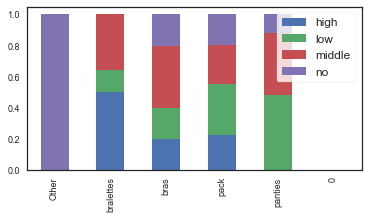

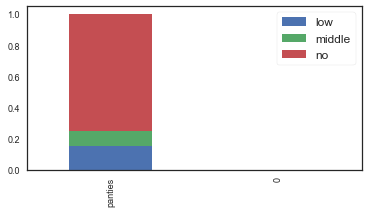

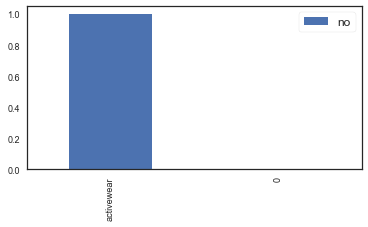

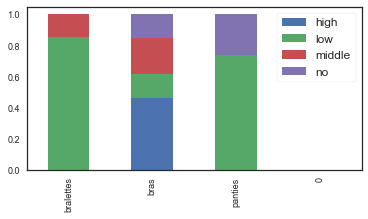

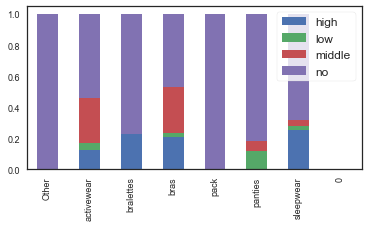

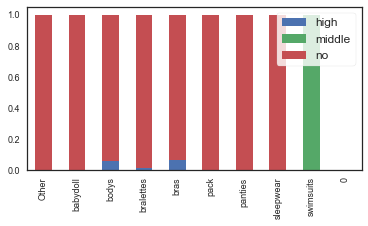

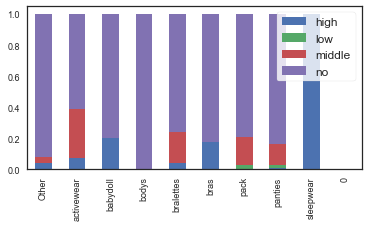

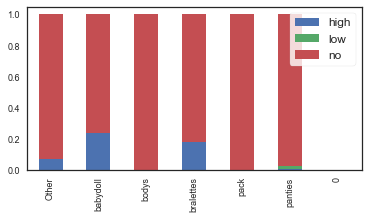

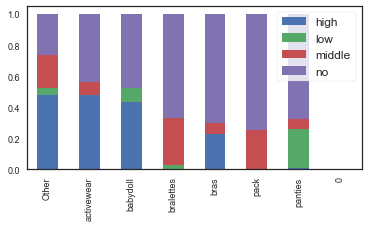

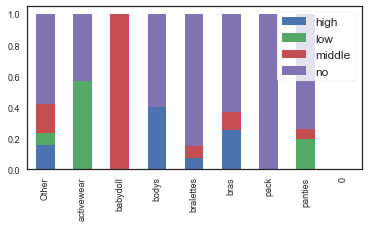

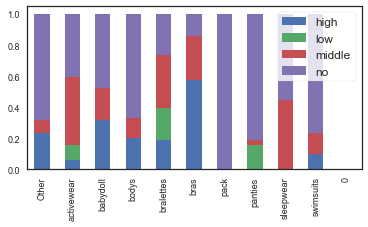

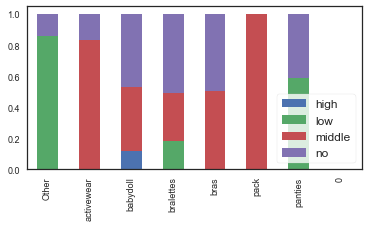

In [77]:
for name, group in brands_info.groupby('brand'):
    stacked_all(group, 'category', name = name)
#brand = "Victoria's Secret"
#stacked_all(brands_info[brands_info['brand']==brand], 'category', name = brand)

In [78]:
def stacked_all_brands(data, discount_cat = 'diff_categories', figsize = (15,5)):
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=figsize)
    tab = pd.crosstab(data[discount_cat], data['brand']).transpose()
    if 'high (>=50%)' in tab.columns:
        ordering = ['high (>=50%)','middle (20%>=x<50%)','low (<20%)','no']
    else:
        ordering = ['high','middle','low','no']
    cor = [x for x in ordering if x in tab.columns] + [x for x in tab.columns if x not in ordering]
    tab = tab[cor]
    display(tab.transpose())

    tab_prop = tab.div(tab.sum(1).astype(float), axis=0)  
    tab_pro = tab_prop.append(pd.DataFrame([1])).drop(0, axis=1) 
    display(tab_pro.transpose())
    ##f7caf2
    colors = ["#755791","#c06c84", "#f67280", "#f8b195"] 
    tab_pro.reindex(tab_pro.index.tolist()).plot(kind="bar", stacked=True, ax = ax, fontsize = 9, color = colors)
    ax.yaxis.grid(True)

**Question 21:** General: Which discount categories are common in which brands?

**Amazon Calvin Klein** 
* Around 85% (107) of products were discounted.
* Middle and low discounts were the most common (each 34%).

**Amazon Hanky Panky** 
* 25% (5) of products were discounted.

**Amazon Wacoal** 
* 83% (32) of products were discounted.
* 56% of products had "low" discount.

**Calvin Klein** 
* 28% (125) of products were discounted, with the middle discount to be the common (11%).

**Hanky Panky**
* 0.1% (6) was discounted.

**Macys Calvin Klein** 
* 18% (124) of products was discounted, and middle discount was the most common (11%).

**Macys Hanky Panky**
* 8% (22) of products was discounted.

**Macys Wacoal**
* 35% (199) of the products was discounted, with a high discount with 14% of products.

**Topshop**
* 31% (127) of products was discounted, with low and high discount around 10-11% each.

**Victoria's Secret** 
* 41% (1469) of products was discounted and middle discount was the most common (17%).

**Wacoal**
* 58% (216) of products was discounted with a low discount to be a common one (36%).


************
Hanky Panky did not offer (at all) as much discounts as the other brands during the scrapping period. Interestingly, that this corresponds to all Hanky Panky's retailer (OW, Amazon and Macys).

brand            Amazon Calvin Klein  Amazon Hanky Panky  \
diff_categories                                            
high             20                   0                    
middle           44                   2                    
low              43                   3                    
no               19                   15                   

brand            Amazon Victoria's Secret  Amazon Wacoal  Calvin Klein  \
diff_categories                                                          
high             0                         6              39             
middle           0                         4              52             
low              0                         22             34             
no               9                         7              323            

brand            Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  \
diff_categories                                                       
high             3            40                  18                  
middle           3            77                  0                   
low              0            7                   3                   
no               631          535                 259                 

brand            Macys Wacoal  Topshop  Victoria's Secret  Wacoal  
diff_categories                                                    
high             85            44       462                2       
middle           53            36       622                77      
low              61            47       385                137     
no               374           289      2050               161

Amazon Calvin Klein  Amazon Hanky Panky  Amazon Victoria's Secret  \
high    0.158730             0.00                0.0                        
middle  0.349206             0.10                0.0                        
low     0.341270             0.15                0.0                        
no      0.150794             0.75                1.0                        

        Amazon Wacoal  Calvin Klein  Hanky Panky  Macys Calvin Klein  \
high    0.153846       0.087054      0.004710     0.060698             
middle  0.102564       0.116071      0.004710     0.116844             
low     0.564103       0.075893      0.000000     0.010622             
no      0.179487       0.720982      0.990581     0.811836             

        Macys Hanky Panky  Macys Wacoal   Topshop  Victoria's Secret  \
high    0.064286           0.148342      0.105769  0.131287            
middle  0.000000           0.092496      0.086538  0.176755            
low     0.010714           0.106457      0.112981  0.109406            
no      0.925000           0.652705      0.694712  0.582552            

          Wacoal   0  
high    0.005305 NaN  
middle  0.204244 NaN  
low     0.363395 NaN  
no      0.427056 NaN

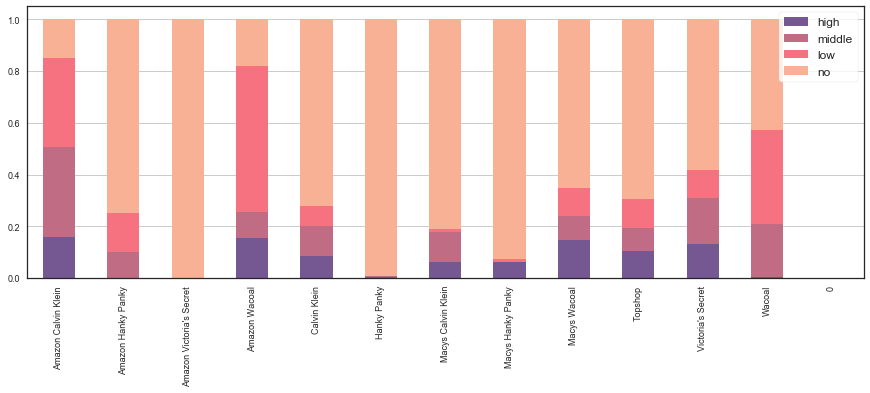

In [79]:
stacked_all_brands(brands_info)

## 3.2 Who offers larger discount?
**Question 21**: Which brands offer larger discounts?
We will take into consideration only brands with high number of discounted products.

* Victoria's Secret, Macys Calvin Klein and Topshop  have several really large discounts (over 40 USD).
* Hanky Panky (OW and Macys) seems to have the larger (average amd median) discount but only because there is a negligible number of discounted items in total.

brand   Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
median  10.03                3.25                6.01           14.01          

brand   Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
median  18.01        15.01               32.5               15.68          

brand   Topshop  Victoria's Secret  Wacoal  
median  14.0     14.51              6.6

brand  Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
mean   11.003458            5.406               8.924062       13.87376       

brand  Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
mean   21.176667    16.522984           29.756667          15.675377      

brand    Topshop  Victoria's Secret    Wacoal  
mean   15.515748  14.816712          8.538426

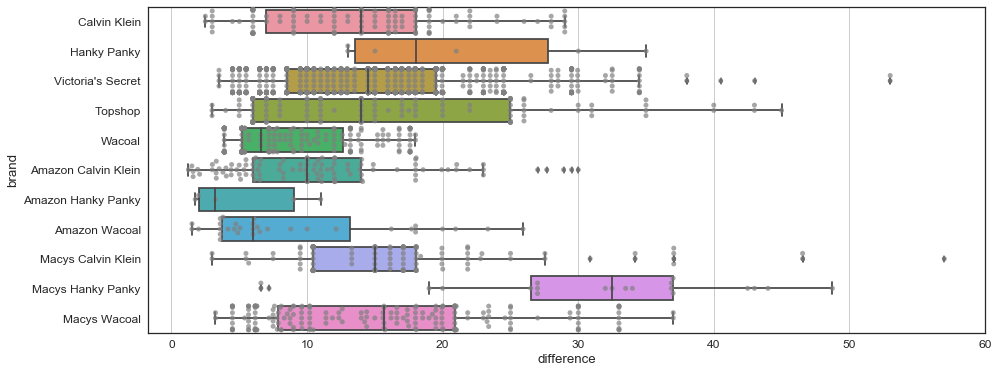

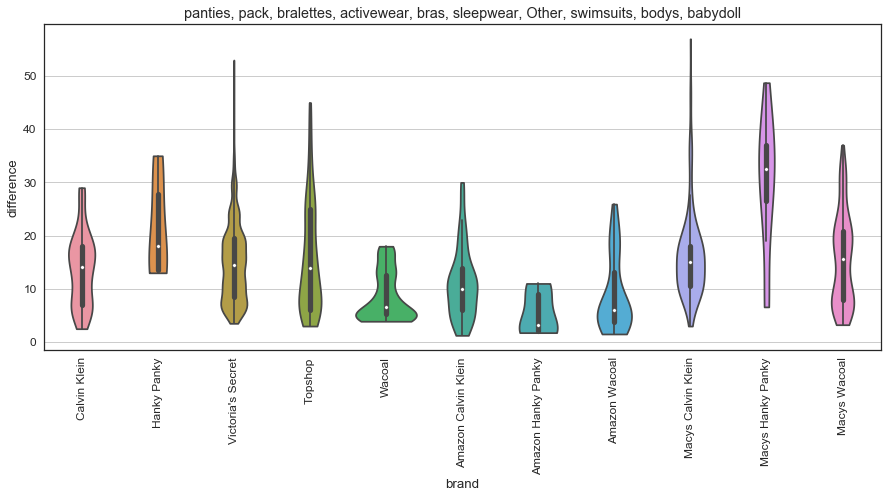

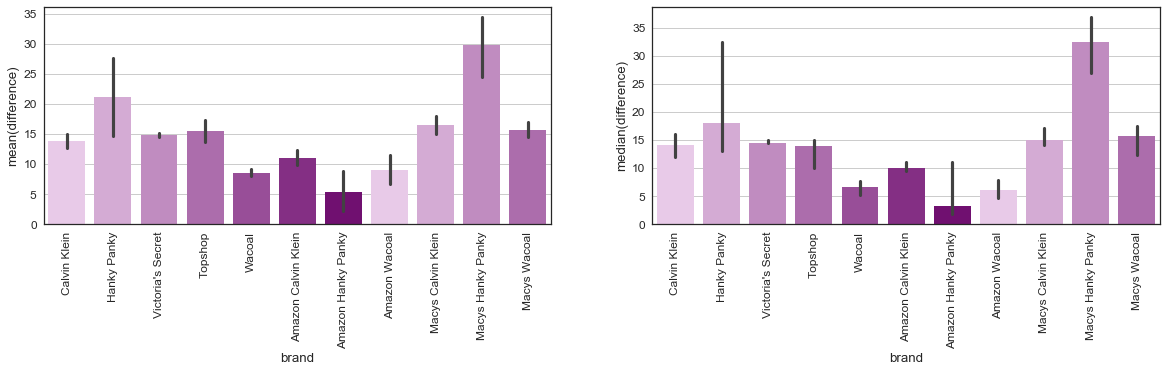

In [80]:
df = brands_info[brands_info['diff']>0]
category_plots(brands_info['category'].unique(), df, swarm = True, money = 'diff', xtitle = 'difference')

**Question 22**: What are the products with a discount over 40 USD?
As expected, that are a bit more expensive items like bras, barlettes, babydools and one romper.

In [81]:
brands_info[brands_info['diff']>40][['product_name','brand','category','diff', 'price', 'mrp', 'color']]

product_name  \
3583  very sexy strappy plunge bra                                       
3801  very sexy lace plunge garter slip                                  
3802  very sexy lace plunge garter slip                                  
4227  very sexy embroidered triangle bra                                 
4791  bra by bluebella                                                   
4799  mesh bralet by somedays lovin'                                     
4819  lacey body                                                         
6197  ck collection black daring silk chemise qs5552                     
6198  ck black collection temptation floral embroidered chemise qs5555   
6221  ck black collection temptation silk romper qs5495                  
6358  dahlia embroidered mesh bralette 297132                            
6368  bahama mama sheer lace bralette 957902                             
6439  signature lace chemise 485776                                      
6440  fitted signature lace chemise 485706                               

                   brand   category   diff  price    mrp  \
3583  Victoria's Secret   bras       40.51  21.99  62.5    
3801  Victoria's Secret   babydoll   53.01  24.99  78.0    
3802  Victoria's Secret   babydoll   53.01  24.99  78.0    
4227  Victoria's Secret   bras       43.01  34.99  78.0    
4791  Topshop             bras       43.00  15.00  58.0    
4799  Topshop             bralettes  43.00  15.00  58.0    
4819  Topshop             bodys      45.00  20.00  65.0    
6197  Macys Calvin Klein  babydoll   46.55  51.45  98.0    
6198  Macys Calvin Klein  babydoll   46.55  51.45  98.0    
6221  Macys Calvin Klein  Other      57.00  63.00  120.0   
6358  Macys Hanky Panky   bralettes  42.50  25.50  68.0    
6368  Macys Hanky Panky   bralettes  48.75  29.25  78.0    
6439  Macys Hanky Panky   babydoll   43.00  43.00  86.0    
6440  Macys Hanky Panky   babydoll   44.00  44.00  88.0    

                         color  
3583  evening tide with ensign  
3801  red lacquer               
3802  black                     
4227  black                     
4791  black                     
4799  black                     
4819  black                     
6197  black                     
6198  black                     
6221  black                     
6358  navy pink                 
6368  peacock passionate pink   
6439  black                     
6440  calypso

Some of the most discounted items:

In [82]:
html = "<table><tr><td>Victorias Secret: bra<img src='https://images-na.ssl-images-amazon.com/images/I/713DKKJk4dL._UY445_.jpg' style='width: 200px;'></td><td>Victorias Secret: slip<img src='https://images-na.ssl-images-amazon.com/images/I/61CWtyQDgjL._UL1500_.jpg' style='width: 200px;'></td><td>Topshop: bra by bluebella<img src='http://media.topshop.com/wcsstore/TopShopDE/images/catalog/TS43C62LBLK_Zoom_F_1.jpg' style='width: 200px;'></td></tr></table>"
display(HTML(html))

**Question 23:** What is the the least discounted item?
That is the panty from Amazon Calvin Klein that has been discounted only by 1.25 USD.

In [83]:
html = "<table><tr><td>Amazon Calvin Klein: least discounted panty<img src='https://images-na.ssl-images-amazon.com/images/I/81AmIezUmWL._UL1500_.jpg' style='width: 200px;'></td></tr></table>"
display(HTML(html))

In [84]:
min_diff = np.min(brands_info[brands_info['diff']>0]['diff'])
brands_info[brands_info['diff']==min_diff]

Unnamed: 0   mrp  price product_category  \
5436  5436        13.0  11.75  panties           

                                  product_name  \
5436  calvin klein women's micro hipster panty   

                                                pdp_url  \
5436  https://www.amazon.com/-/dp/b00o4ckegk?th=1&psc=1   

                                                                             description  \
5436  a modern hipster underwear featuring breathable microfiber and a flirty lace trim.   

     color  \
5436  bare   

                                                                             descr_conc  \
5436  a modern hipster underwear featuring breathable microfiber and a flirty lace trim   

                    brand category  diff diff_categories discount  
5436  Amazon Calvin Klein  panties  1.25  low             yes

## 3.3 Ratio of RMP to the price. Real discount value.

Large discounts are good but no panties would get into high level discount unless they cost around 40 euros. As we have seen the average price of the panties is around 15 dollars. It will be more informative to look at the percentage of the offered discount to the price. So, if the rmp is 14 dollars and price is 7 dollars. There is a 50% discount.

In [85]:
def find_percentage_discount(data):
    data['diff_per'] = (data['diff'] * 100  / data['mrp']).round(2)  

    data['diff_per_categories'] = ''
    data.loc[(data['diff_per'] < 20) & (data['diff_per'] != 0.0), 'diff_per_categories'] = 'low (<20%)'
    data.loc[(data['diff_per'] >= 20) & (data['diff_per'] < 50), 'diff_per_categories'] = 'middle (20%>=x<50%)'
    data.loc[(data['diff_per'] >= 50), 'diff_per_categories'] = 'high (>=50%)'
    data.loc[(data['diff_per'] == 0.0), 'diff_per_categories'] = 'no'   
    return data

In [86]:
brands_info = find_percentage_discount(brands_info)

## 3.3.1 Which brand offers which percentage discount?

**Question 24:** Sales! Up to 50%. What percentage disconts are offered by each brand?
* Interestingly, only some brands offer a small amount of products with discount of less than 20%. Except for Amazon Calvin Klein, 15% of the products have up to 20% discount. 
* All brands tend to have a discount around 20%-50%.
* Several brands offer >50% on more than 10% of their products: Amazon Calvin Klein 31% (40), Victoria's Secret 20% (716), Topshop 15% (66),  Amazon Wacoal 12% (5).

brand                Amazon Calvin Klein  Amazon Hanky Panky  \
diff_per_categories                                            
high (>=50%)         40                   0                    
middle (20%>=x<50%)  48                   2                    
low (<20%)           19                   3                    
no                   19                   15                   

brand                Amazon Victoria's Secret  Amazon Wacoal  Calvin Klein  \
diff_per_categories                                                          
high (>=50%)         0                         5              18             
middle (20%>=x<50%)  0                         23             104            
low (<20%)           0                         4              3              
no                   9                         7              323            

brand                Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  \
diff_per_categories                                                       
high (>=50%)         0            2                   18                  
middle (20%>=x<50%)  6            122                 3                   
low (<20%)           0            0                   0                   
no                   631          535                 259                 

brand                Macys Wacoal  Topshop  Victoria's Secret  Wacoal  
diff_per_categories                                                    
high (>=50%)         2             66       716                0       
middle (20%>=x<50%)  197           61       753                216     
low (<20%)           0             0        0                  0       
no                   374           289      2050               161

Amazon Calvin Klein  Amazon Hanky Panky  \
high (>=50%)         0.317460             0.00                 
middle (20%>=x<50%)  0.380952             0.10                 
low (<20%)           0.150794             0.15                 
no                   0.150794             0.75                 

                     Amazon Victoria's Secret  Amazon Wacoal  Calvin Klein  \
high (>=50%)         0.0                       0.128205       0.040179       
middle (20%>=x<50%)  0.0                       0.589744       0.232143       
low (<20%)           0.0                       0.102564       0.006696       
no                   1.0                       0.179487       0.720982       

                     Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  \
high (>=50%)         0.000000     0.003035            0.064286            
middle (20%>=x<50%)  0.009419     0.185129            0.010714            
low (<20%)           0.000000     0.000000            0.000000            
no                   0.990581     0.811836            0.925000            

                     Macys Wacoal   Topshop  Victoria's Secret    Wacoal   0  
high (>=50%)         0.003490      0.158654  0.203467           0.000000 NaN  
middle (20%>=x<50%)  0.343805      0.146635  0.213981           0.572944 NaN  
low (<20%)           0.000000      0.000000  0.000000           0.000000 NaN  
no                   0.652705      0.694712  0.582552           0.427056 NaN

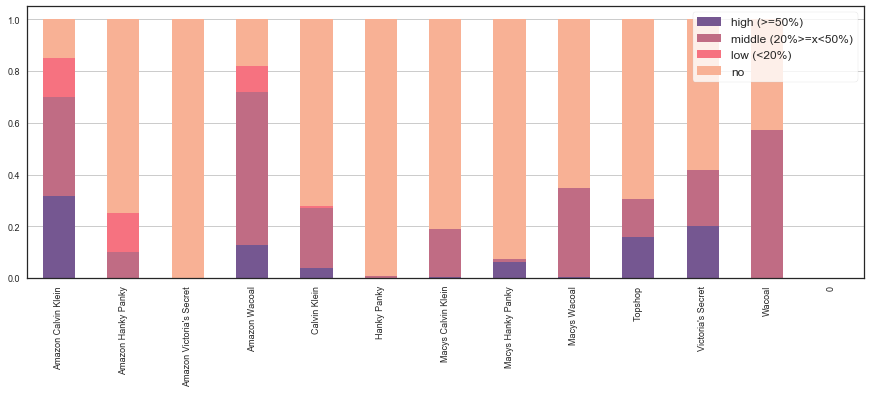

In [87]:
stacked_all_brands(brands_info, discount_cat='diff_per_categories')

brand                Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  \
diff_per_categories                                                           
high (>=50%)         40                   0                   5               
middle (20%>=x<50%)  48                   2                   23              
low (<20%)           19                   3                   4               

brand                Calvin Klein  Hanky Panky  Macys Calvin Klein  \
diff_per_categories                                                  
high (>=50%)         18            0            2                    
middle (20%>=x<50%)  104           6            122                  
low (<20%)           3             0            0                    

brand                Macys Hanky Panky  Macys Wacoal  Topshop  \
diff_per_categories                                             
high (>=50%)         18                 2             66        
middle (20%>=x<50%)  3                  197           61        
low (<20%)           0                  0             0         

brand                Victoria's Secret  Wacoal  
diff_per_categories                             
high (>=50%)         716                0       
middle (20%>=x<50%)  753                216     
low (<20%)           0                  0

Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  \
high (>=50%)         0.373832             0.0                 0.15625         
middle (20%>=x<50%)  0.448598             0.4                 0.71875         
low (<20%)           0.177570             0.6                 0.12500         

                     Calvin Klein  Hanky Panky  Macys Calvin Klein  \
high (>=50%)         0.144         0.0          0.016129             
middle (20%>=x<50%)  0.832         1.0          0.983871             
low (<20%)           0.024         0.0          0.000000             

                     Macys Hanky Panky  Macys Wacoal   Topshop  \
high (>=50%)         0.857143           0.01005       0.519685   
middle (20%>=x<50%)  0.142857           0.98995       0.480315   
low (<20%)           0.000000           0.00000       0.000000   

                     Victoria's Secret  Wacoal   0  
high (>=50%)         0.487406           0.0    NaN  
middle (20%>=x<50%)  0.512594           1.0    NaN  
low (<20%)           0.000000           0.0    NaN

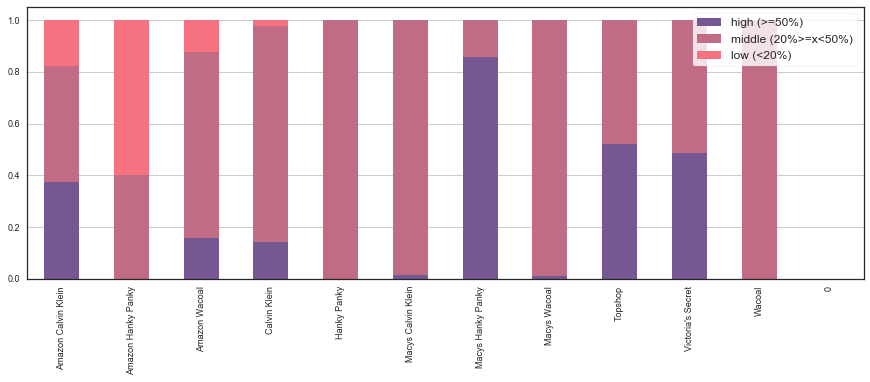

In [88]:
stacked_all_brands(brands_info[brands_info['diff_per_categories']!='no'], discount_cat='diff_per_categories')

**Question 24.1 :** Sales! Up to 50%. What percentage discounts are offered by each brand?
* The majority of Victoria's Secret discounts are around 50%, having an outlier with >=80% discount!
* Topshop has a bimodal distribution with discounts around 40% and 60-70% but with a median of 50%.
* Calvin Klein has most of the discounts around 46% and Amazon Calvin Klein around 36% but Amazon has more items with >=50% discount.
* Wacoal offers either 30% or 40% discounts and Macy's Wacoal has also a bimodal distribution with around 30%  and 45% discount.
* Hanky Panky does not offer much of the discount.


brand   Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
median  36.75                12.04               31.63          46.23          

brand   Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
median  33.54        47.5                50.0               41.68          

brand   Topshop  Victoria's Secret  Wacoal  
median  50.0     49.6               40.0

brand  Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
mean   37.463271            17.316              32.815312      43.27304       

brand  Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
mean   36.015       45.310968           50.118095          38.820905      

brand    Topshop  Victoria's Secret     Wacoal  
mean   51.929449  51.187386          36.435185

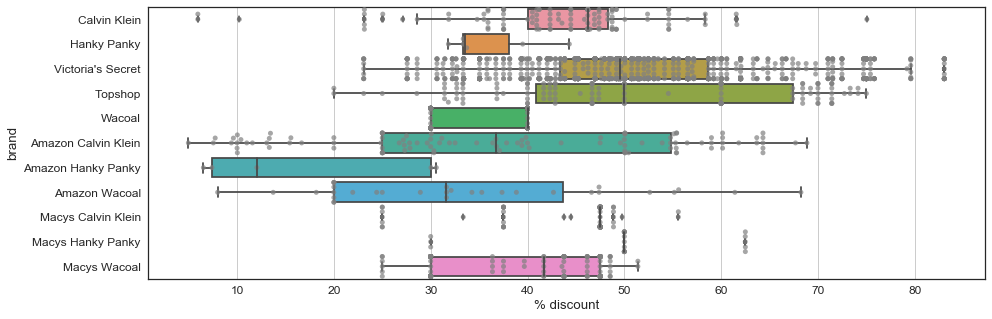

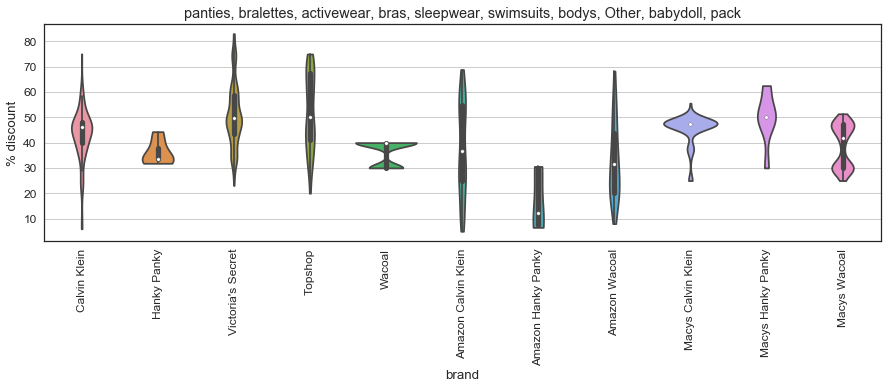

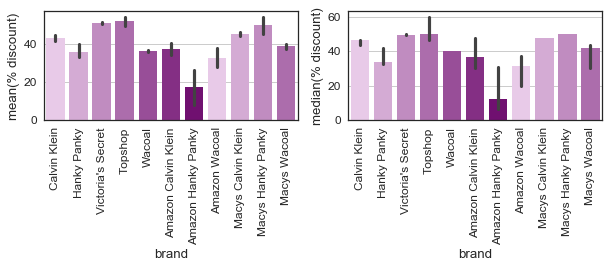

In [89]:
df = brands_info
df = df[df['diff_per']>0]
category_plots(df['category'].unique(), df, swarm = True, money = 'diff_per', xtitle='% discount',
               figsize1=(15,5), figsize2=(15,4), figsize3=(10,2))

In [90]:
df[df['diff_per']>50].groupby('brand').size()

brand
Amazon Calvin Klein    39 
Amazon Wacoal          5  
Calvin Klein           18 
Macys Calvin Klein     2  
Macys Hanky Panky      5  
Macys Wacoal           2  
Topshop                58 
Victoria's Secret      716
dtype: int64

In [91]:
df = brands_info[brands_info['diff_per']>=75]
df.drop_duplicates(['product_name','price','mrp','description'])[['product_name','price','mrp', 'diff_per', 'color', 'brand']]

product_name  price   mrp  \
0     modern cotton bikini                               4.99   20.0   
1122  very sexy lace v string panty                      3.99   16.5   
1124  dream angels ruffled cheekini bloomer panty        3.99   16.5   
1220  very sexy strappy lace cheeky panty                3.99   16.5   
1221  dream angels ruffled thong panty                   3.99   16.5   
1269  the bralette collection mesh plunge bralette       5.00   20.0   
1270  the player lace up sport bra                       5.00   24.5   
1271  victoria sport lightweight by victoria sport bra   5.00   29.5   
1272  the bralette collection mesh scoopneck bralette    5.00   20.0   
1278  the bralette collection scoopneck bralette         5.00   20.0   
1284  the bralette collection mesh front close bralette  5.00   20.0   
1292  the bralette collection crisscross scoop bralette  5.00   24.5   
1310  the bralette collection lace scoopneck bralette    5.00   20.0   
1312  the bralette collection bandeau flounce bralette   5.00   20.0   
1313  victoria sport strappy triangle sport bra          5.00   20.0   
1441  pink lace lightly lined triangle                   7.99   32.5   
1689  sleep kimono                                       9.99   48.0   
4604  full lace knickers                                 2.00   8.0    

      diff_per                       color              brand  
0     75.05     gradient logo               Calvin Klein       
1122  75.82     fir green                   Victoria's Secret  
1124  75.82     ruby paisley print          Victoria's Secret  
1220  75.82     ensign blue                 Victoria's Secret  
1221  75.82     floral print                Victoria's Secret  
1269  75.00     gold earth multi print      Victoria's Secret  
1270  79.59     summer blues                Victoria's Secret  
1271  83.05     black blocked curves        Victoria's Secret  
1272  75.00     ensign print                Victoria's Secret  
1278  75.00     ensign                      Victoria's Secret  
1284  75.00     black pearl textured mesh   Victoria's Secret  
1292  79.59     black wrap                  Victoria's Secret  
1310  75.00     camilla rose                Victoria's Secret  
1312  75.00     sheer pink floral print     Victoria's Secret  
1313  75.00     white                       Victoria's Secret  
1441  75.42     moonray                     Victoria's Secret  
1689  79.19     coconut white mosaic print  Victoria's Secret  
4604  75.00     cobalt                      Topshop

**Question 24.2 :** Sales! Up to 50%. What percentage discounts are common for each category?<br>
As most of the items come from Victoria's Secret those graphs are strongly influned by this brand.

* Panties, bralettes, bras, activwear have almost the same average discount (around 50%). However, more panties have a discount >=60% than any another catergory.
* Some swimsuits are more discounted (over 55%) than the others (less than 50%).
* Bodys, babydolls, Other and pack have a median discount around 40%.

brand   Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
median  36.75                12.04               31.63          46.23          

brand   Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
median  33.54        47.5                50.0               41.68          

brand   Topshop  Victoria's Secret  Wacoal  
median  50.0     49.6               40.0

brand  Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
mean   37.463271            17.316              32.815312      43.27304       

brand  Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
mean   36.015       45.310968           50.118095          38.820905      

brand    Topshop  Victoria's Secret     Wacoal  
mean   51.929449  51.187386          36.435185

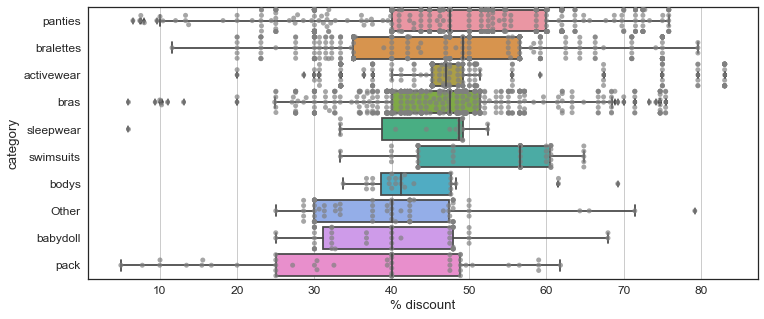

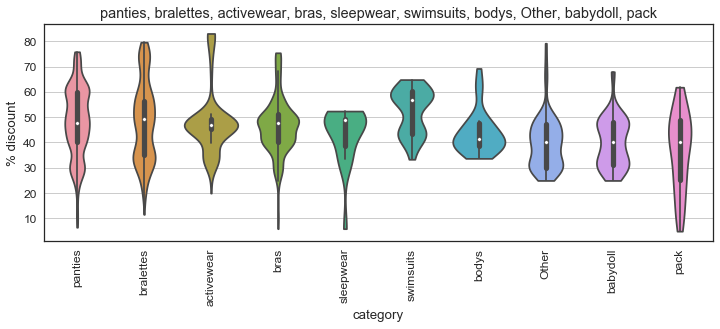

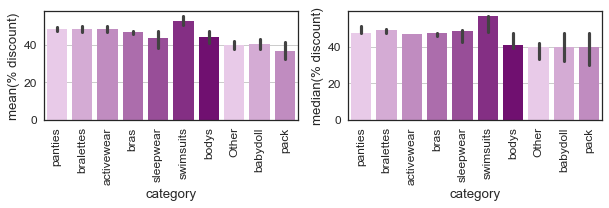

In [92]:
df = brands_info
df = df[df['diff_per']>0]
category_plots(df['category'].unique(), df, y='category',swarm = True, money = 'diff_per', xtitle='% discount',
               figsize1=(12,5), figsize2=(12,4), figsize3=(10,2))

In [93]:
df[df['diff_per']>60].groupby('category').size()

category
Other         4  
activewear    44 
babydoll      2  
bodys         3  
bralettes     78 
bras          67 
pack          1  
panties       173
swimsuits     14 
dtype: int64

In [94]:
#**Question 25:** Sales! Up to 50%. What percentage disconts are offered by each brand for each category?
#* Around 20% (709) of panties have a discount >=20% (with 10% (348) of panties having >=50% discount)
#* 15% (190) of bras, 24% (193) of bralettes, 14% (32) of swimsuits and 12% (78) of activewear have a >=50% discount.
#stacked_all(brands_info, 'category', name = 'All Brands', discount_cat='diff_per_categories')

**Question 26:** Which brand offers larger percentage discount on each category?

## Panties
* _more than 50% discount_: 44% (22) of Amazon Calvin Klein, 17% (37) of Topshop and 16% (278) of Victoria's Secret 
* _more than 20% discount_: 76% (38) of Amazon Calvin Klein, 35% (54) of Topshop and 18.8% (310) of Victoria's Secret, 18% (46) of Calvin Klein, 16% (49) of Macy Calvin Klein


* Victoria's Secret offers the largest average discount on panties.


Learnings: 
* If you are a fan of Calvin Klein, I would firstly check Amazon Calvin Klein as they might have more highly discounted items but OW has more panties in general. And do not forget the packs (but Calvin Klein had also an offer "3 for 33").
* If you like Wacoal, check first OW because the majority of panties will have a discount around 40% but Macys might have more products with >45% discount  
* If you want hunting for the discounts, go to Victoria's Secret for panties.


brand                Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  \
diff_per_categories                                                           
high (>=50%)         22                   0                   0               
middle (20%>=x<50%)  16                   2                   11              
low (<20%)           6                    3                   3               
no                   6                    15                  5               

brand                Calvin Klein  Hanky Panky  Macys Calvin Klein  \
diff_per_categories                                                  
high (>=50%)         10            0            0                    
middle (20%>=x<50%)  36            1            49                   
low (<20%)           0             0            0                    
no                   203           380          252                  

brand                Macys Hanky Panky  Macys Wacoal  Topshop  \
diff_per_categories                                             
high (>=50%)         1                  0             37        
middle (20%>=x<50%)  3                  72            17        
low (<20%)           0                  0             0         
no                   163                152           154       

brand                Victoria's Secret  Wacoal  
diff_per_categories                             
high (>=50%)         278                0       
middle (20%>=x<50%)  32                 122     
low (<20%)           0                  0       
no                   1326               86

Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  \
high (>=50%)         0.44                 0.00                0.000000        
middle (20%>=x<50%)  0.32                 0.10                0.578947        
low (<20%)           0.12                 0.15                0.157895        
no                   0.12                 0.75                0.263158        

                     Calvin Klein  Hanky Panky  Macys Calvin Klein  \
high (>=50%)         0.040161      0.000000     0.000000             
middle (20%>=x<50%)  0.144578      0.002625     0.162791             
low (<20%)           0.000000      0.000000     0.000000             
no                   0.815261      0.997375     0.837209             

                     Macys Hanky Panky  Macys Wacoal   Topshop  \
high (>=50%)         0.005988           0.000000      0.177885   
middle (20%>=x<50%)  0.017964           0.321429      0.081731   
low (<20%)           0.000000           0.000000      0.000000   
no                   0.976048           0.678571      0.740385   

                     Victoria's Secret    Wacoal   0  
high (>=50%)         0.169927           0.000000 NaN  
middle (20%>=x<50%)  0.019560           0.586538 NaN  
low (<20%)           0.000000           0.000000 NaN  
no                   0.810513           0.413462 NaN

brand   Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
median  48.8                 12.04               28.315         46.23          

brand   Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
median  39.5         47.5                30.0               30.0           

brand   Topshop  Victoria's Secret  Wacoal  
median  60.0     59.365             40.0

brand  Amazon Calvin Klein  Amazon Hanky Panky  Amazon Wacoal  Calvin Klein  \
mean   40.532727            17.316              26.34          44.286522      

brand  Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
mean   39.5         45.204082           35.0               37.408056      

brand    Topshop  Victoria's Secret     Wacoal  
mean   54.363889  58.75              36.311475

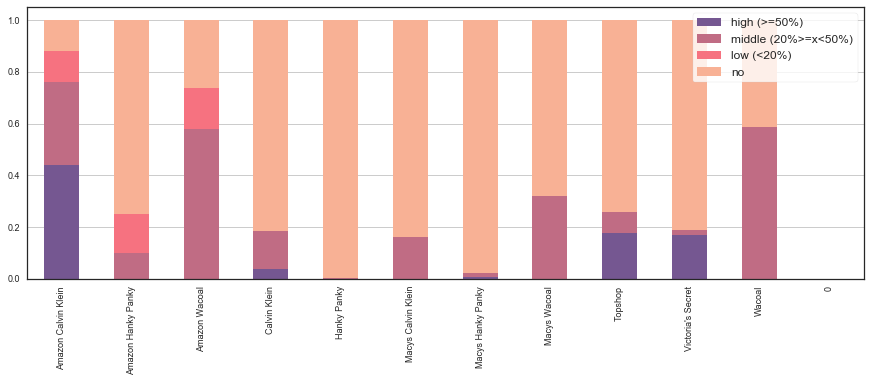

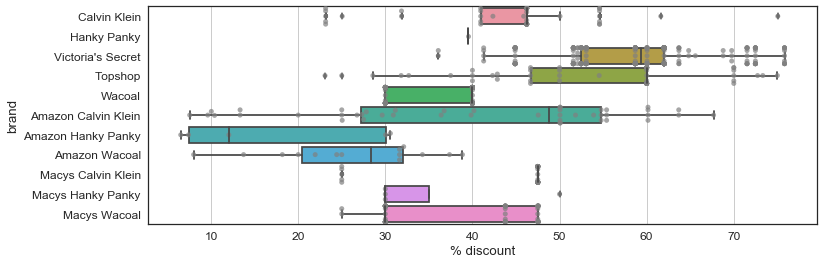

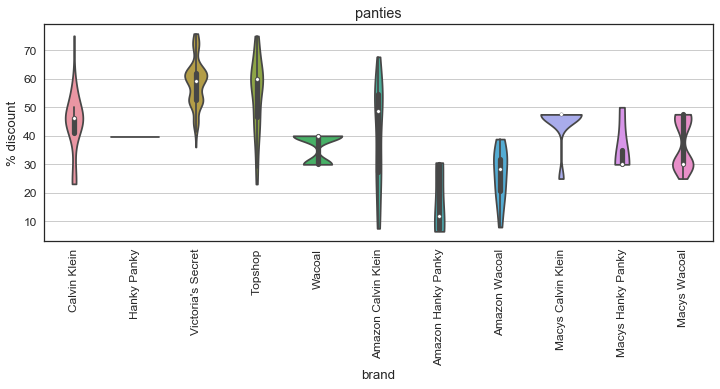

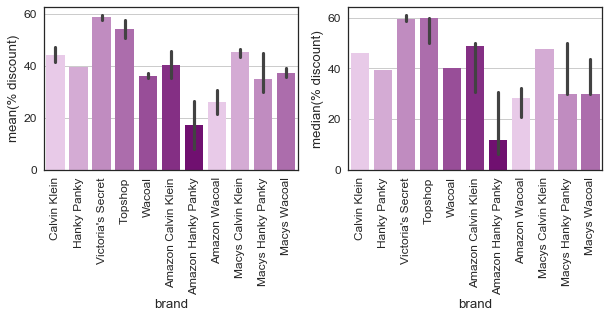

In [95]:
def perform_viz(category, figsize1=(12,4), figsize2=(12,4), figsize3=(10,3)):
    df = brands_info
    df1 = df[df['category']==category]
    stacked_all_brands(df1, discount_cat='diff_per_categories')
    df1 = df[df['diff_per']>0]
    category_plots([category], df1, swarm = True, money = 'diff_per', xtitle = '% discount',
               figsize1=figsize1, figsize2=figsize2, figsize3=figsize3)
    
perform_viz('panties')

In [96]:
for name, group in brands_info.groupby('brand'):
    print(name)
    print((group[(group['category']=='panties')].price<10).sum())

Amazon Calvin Klein
25
Amazon Hanky Panky
0
Amazon Victoria's Secret
0
Amazon Wacoal
3
Calvin Klein
36
Hanky Panky
0
Macys Calvin Klein
3
Macys Hanky Panky
0
Macys Wacoal
27
Topshop
47
Victoria's Secret
410
Wacoal
96


## Bras
* _more than 50% discount_: 16% (4) of Amazon Calvin Klein, 17% (22) of Topshop and 33% (156) of Victoria's Secret 
* _more than 20% discount_: 48% (16) of Amazon Calvin Klein, 36% (47) of Topshop and 85% (405) of Victoria's Secret, 50% (46) of Calvin Klein, 17% (28) of Macy Calvin Klein, 30% (67) of Macys Wacoal, 50% (41) of Wacoal <br>
<br>
* Victoria's Secret offers the largest relative number of discounted bras.
* Most bras of Victoria's Secret have a discount of 49%
* Topshop and Victoria's Secret offer more products with a discount over 50% than other brands.
* Macys Calvin Klein has a discount of around 47% on most of their discounted bras. Calvin Klein has more discounted bra but with around 42% discount, however, it still has outliers.
* Wacoal has again a bimodal discount distribution around 30% and 40%


Learnings: 
* Check Topshop and Victoria's Secret for (highly) discounted bras.
* If you like Wacoal, check first Macys as the majority of items have a discount of 46%, comparing to Wacoal's 40% (as well as the average discount is around 42% at Macys in comparison to OW with 37%)
* For Calvin Klein check both websites.

brand                Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  \
diff_per_categories                                                     
high (>=50%)         4                    4              4              
middle (20%>=x<50%)  12                   6              42             
low (<20%)           4                    1              2              
no                   5                    2              43             

brand                Hanky Panky  Macys Calvin Klein  Macys Wacoal  Topshop  \
diff_per_categories                                                           
high (>=50%)         0            0                   0             22        
middle (20%>=x<50%)  1            28                  67            25        
low (<20%)           0            0                   0             0         
no                   14           129                 156           81        

brand                Victoria's Secret  Wacoal  
diff_per_categories                             
high (>=50%)         156                0       
middle (20%>=x<50%)  249                41      
low (<20%)           0                  0       
no                   67                 40

Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  \
high (>=50%)         0.16                 0.307692       0.043956       
middle (20%>=x<50%)  0.48                 0.461538       0.461538       
low (<20%)           0.16                 0.076923       0.021978       
no                   0.20                 0.153846       0.472527       

                     Hanky Panky  Macys Calvin Klein  Macys Wacoal   Topshop  \
high (>=50%)         0.000000     0.000000            0.000000      0.171875   
middle (20%>=x<50%)  0.066667     0.178344            0.300448      0.195312   
low (<20%)           0.000000     0.000000            0.000000      0.000000   
no                   0.933333     0.821656            0.699552      0.632812   

                     Victoria's Secret    Wacoal   0  
high (>=50%)         0.330508           0.000000 NaN  
middle (20%>=x<50%)  0.527542           0.506173 NaN  
low (<20%)           0.000000           0.000000 NaN  
no                   0.141949           0.493827 NaN

brand   Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
median  28.23                47.39          42.33         44.32         

brand   Macys Calvin Klein  Macys Wacoal  Topshop  Victoria's Secret  Wacoal  
median  47.5                46.17         46.67    49.39              40.0

brand  Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
mean   32.3895              44.585455      40.926875     44.32         

brand  Macys Calvin Klein  Macys Wacoal    Topshop  Victoria's Secret  \
mean   47.448214           42.342985     53.086596  48.951037           

brand     Wacoal  
mean   37.073171

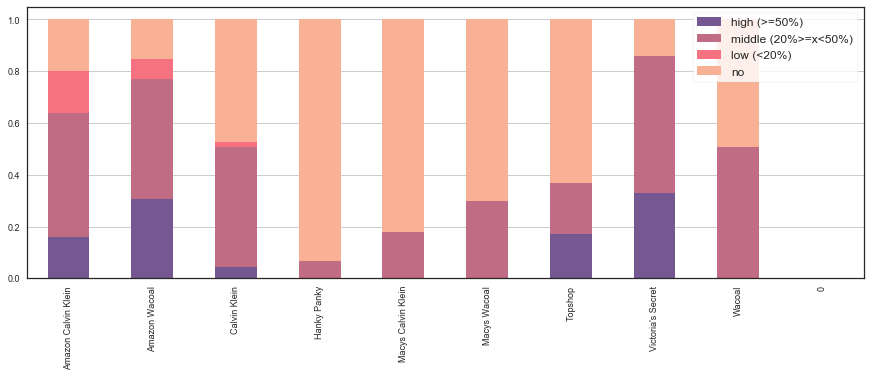

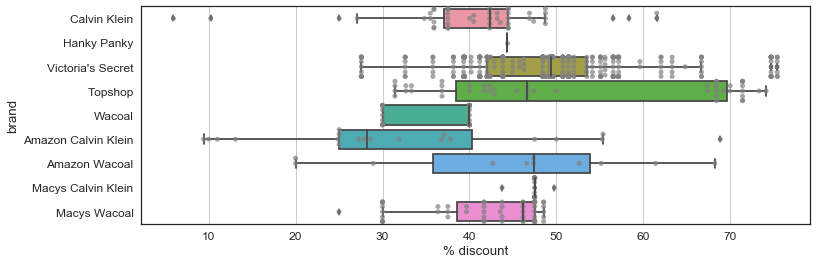

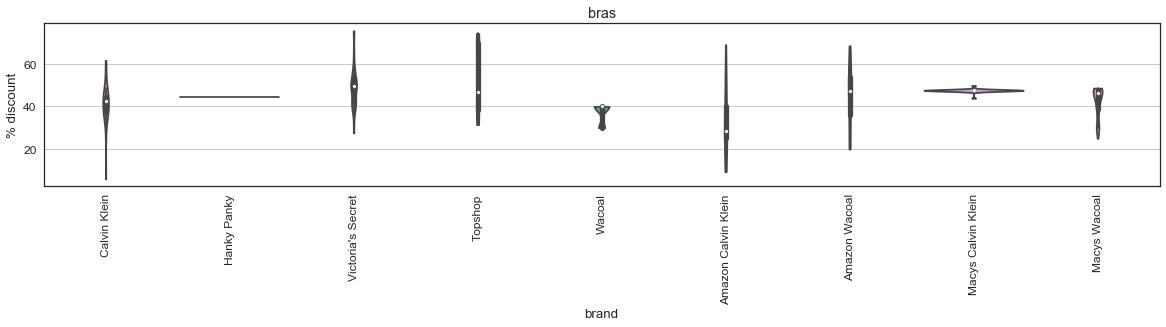

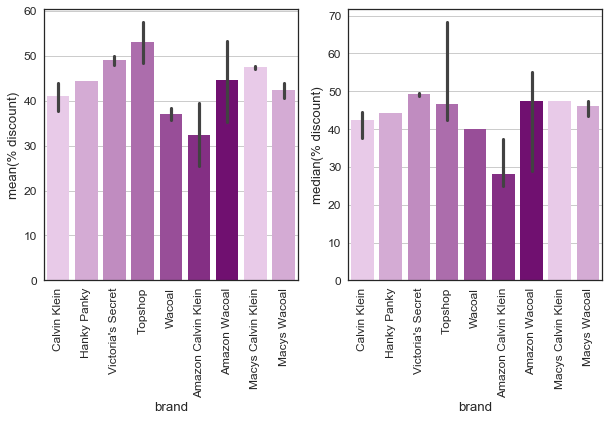

In [97]:
perform_viz('bras',figsize1=(12,4), figsize2=(20,3), figsize3=(10,5))

In [98]:
for name, group in brands_info.groupby('brand'):
    print(name)
    print((group[(group['category']=='bras')].price<20).sum())

Amazon Calvin Klein
4
Amazon Hanky Panky
0
Amazon Victoria's Secret
0
Amazon Wacoal
7
Calvin Klein
21
Hanky Panky
0
Macys Calvin Klein
9
Macys Hanky Panky
0
Macys Wacoal
3
Topshop
23
Victoria's Secret
214
Wacoal
0


## Bralettes

brand                Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  \
diff_per_categories                                                     
high (>=50%)         7                    1              2              
middle (20%>=x<50%)  6                    6              3              
low (<20%)           1                    0              0              
no                   0                    0              17             

brand                Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  \
diff_per_categories                                                       
high (>=50%)         0            0                   12                  
middle (20%>=x<50%)  1            19                  0                   
low (<20%)           0            0                   0                   
no                   65           60                  56                  

brand                Macys Wacoal  Topshop  Victoria's Secret  Wacoal  
diff_per_categories                                                    
high (>=50%)         0             2        169                0       
middle (20%>=x<50%)  13            2        131                24      
low (<20%)           0             0        0                  0       
no                   26            23       107                25

Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  \
high (>=50%)         0.500000             0.142857       0.090909       
middle (20%>=x<50%)  0.428571             0.857143       0.136364       
low (<20%)           0.071429             0.000000       0.000000       
no                   0.000000             0.000000       0.772727       

                     Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  \
high (>=50%)         0.000000     0.000000            0.176471            
middle (20%>=x<50%)  0.015152     0.240506            0.000000            
low (<20%)           0.000000     0.000000            0.000000            
no                   0.984848     0.759494            0.823529            

                     Macys Wacoal   Topshop  Victoria's Secret    Wacoal   0  
high (>=50%)         0.000000      0.074074  0.415233           0.000000 NaN  
middle (20%>=x<50%)  0.333333      0.074074  0.321867           0.489796 NaN  
low (<20%)           0.000000      0.000000  0.000000           0.000000 NaN  
no                   0.666667      0.851852  0.262899           0.510204 NaN

brand   Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
median  49.415               20.0           48.29         31.83         

brand   Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  Topshop  \
median  47.5                50.0               30.0          54.85     

brand   Victoria's Secret  Wacoal  
median  50.05              30.0

brand  Amazon Calvin Klein  Amazon Wacoal  Calvin Klein  Hanky Panky  \
mean   45.985714            27.27          51.958        31.83         

brand  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  Topshop  \
mean   47.5                55.206667          34.424615     54.2925   

brand  Victoria's Secret     Wacoal  
mean   50.4856            34.583333

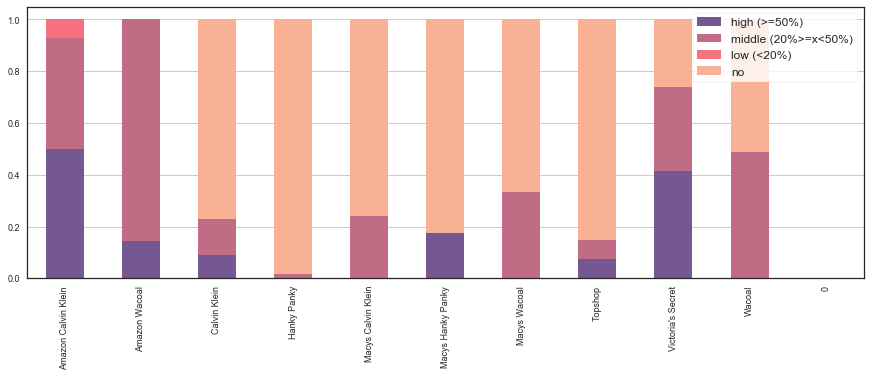

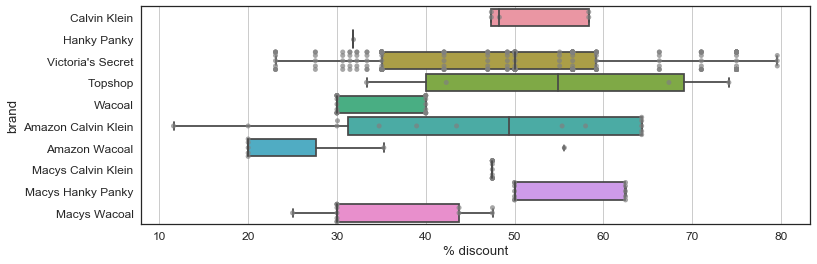

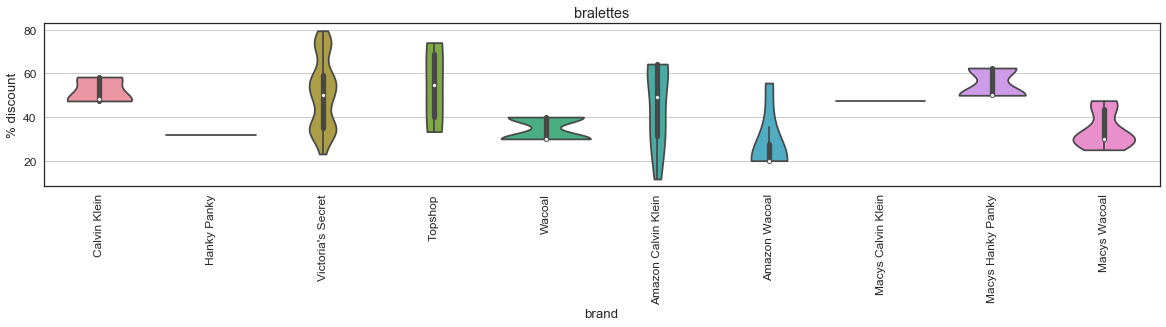

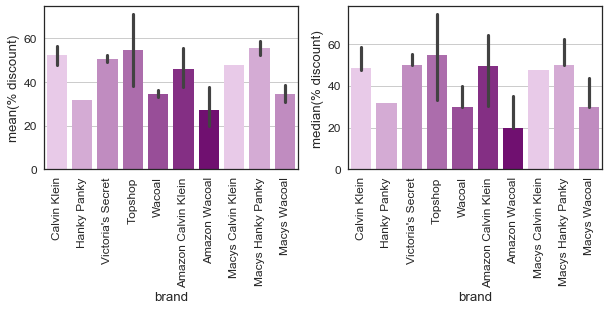

In [99]:
perform_viz('bralettes', figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

## Activewear

brand                Amazon Victoria's Secret  Calvin Klein  \
diff_per_categories                                           
high (>=50%)         0                         0              
middle (20%>=x<50%)  0                         11             
no                   9                         13             

brand                Macys Calvin Klein  Macys Wacoal  Topshop  \
diff_per_categories                                              
high (>=50%)         2                   2             0         
middle (20%>=x<50%)  14                  12            4         
no                   25                  11            3         

brand                Victoria's Secret  Wacoal  
diff_per_categories                             
high (>=50%)         74                 0       
middle (20%>=x<50%)  237                5       
no                   212                1

Amazon Victoria's Secret  Calvin Klein  \
high (>=50%)         0.0                       0.000000       
middle (20%>=x<50%)  0.0                       0.458333       
no                   1.0                       0.541667       

                     Macys Calvin Klein  Macys Wacoal   Topshop  \
high (>=50%)         0.048780            0.08          0.000000   
middle (20%>=x<50%)  0.341463            0.48          0.571429   
no                   0.609756            0.44          0.428571   

                     Victoria's Secret    Wacoal   0  
high (>=50%)         0.141491           0.000000 NaN  
middle (20%>=x<50%)  0.453155           0.833333 NaN  
no                   0.405354           0.166667 NaN

brand   Calvin Klein  Macys Calvin Klein  Macys Wacoal  Topshop  \
median  41.21         37.52               47.5          33.335    

brand   Victoria's Secret  Wacoal  
median  46.98              30.0

brand  Calvin Klein  Macys Calvin Klein  Macys Wacoal  Topshop  \
mean   42.077273     39.951875           46.064286     33.335    

brand  Victoria's Secret  Wacoal  
mean   49.468424          34.0

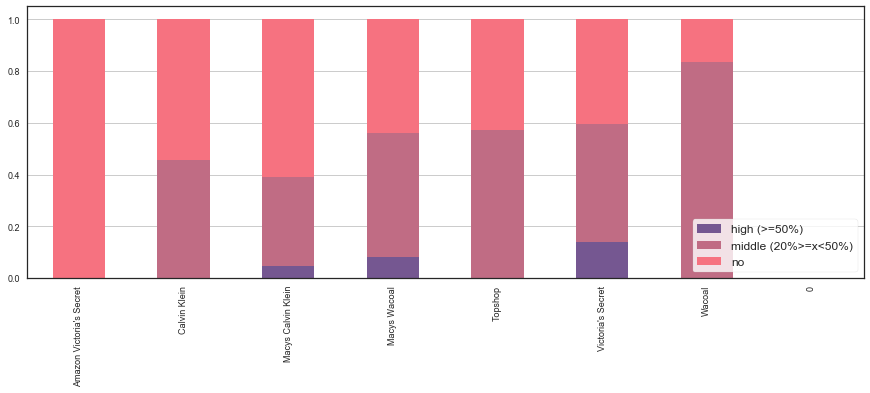

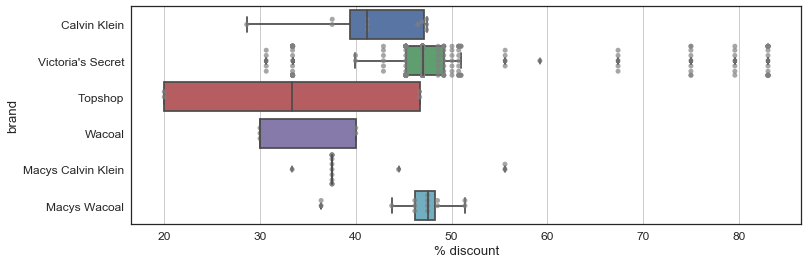

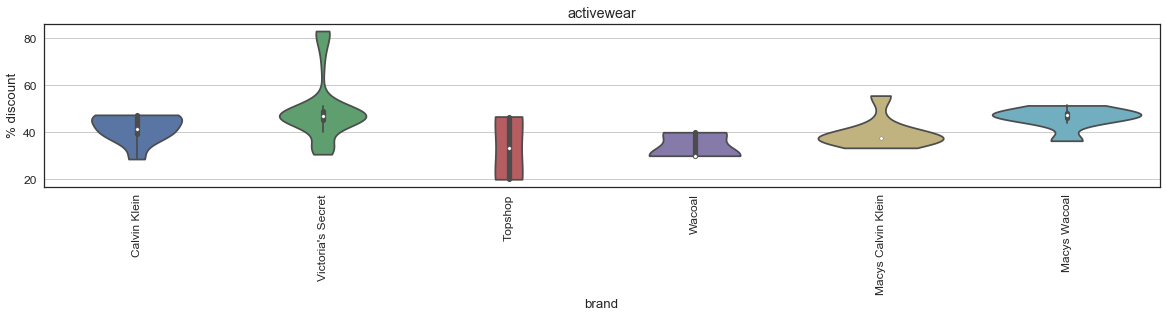

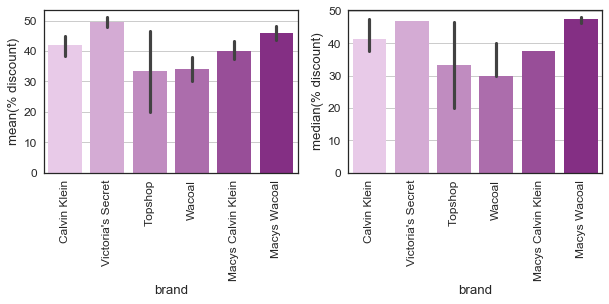

In [100]:
perform_viz('activewear', figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

## Packs
* Majority of packs from Amazon Calvin Klein are discounted.

brand                Amazon Calvin Klein  Calvin Klein  Hanky Panky  \
diff_per_categories                                                   
high (>=50%)         7                    0             0             
middle (20%>=x<50%)  14                   0             0             
low (<20%)           8                    0             0             
no                   7                    8             44            

brand                Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
diff_per_categories                                                        
high (>=50%)         0                   0                  0              
middle (20%>=x<50%)  7                   0                  4              
low (<20%)           0                   0                  0              
no                   27                  3                  12             

brand                Topshop  Victoria's Secret  Wacoal  
diff_per_categories                                      
high (>=50%)         0        0                  0       
middle (20%>=x<50%)  0        0                  9       
low (<20%)           0        0                  0       
no                   4        6                  0

Amazon Calvin Klein  Calvin Klein  Hanky Panky  \
high (>=50%)         0.194444             0.0           0.0           
middle (20%>=x<50%)  0.388889             0.0           0.0           
low (<20%)           0.222222             0.0           0.0           
no                   0.194444             1.0           1.0           

                     Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
high (>=50%)         0.000000            0.0                0.00           
middle (20%>=x<50%)  0.205882            0.0                0.25           
low (<20%)           0.000000            0.0                0.00           
no                   0.794118            1.0                0.75           

                     Topshop  Victoria's Secret  Wacoal   0  
high (>=50%)         0.0      0.0                0.0    NaN  
middle (20%>=x<50%)  0.0      0.0                1.0    NaN  
low (<20%)           0.0      0.0                0.0    NaN  
no                   1.0      1.0                0.0    NaN

brand   Amazon Calvin Klein  Macys Calvin Klein  Macys Wacoal  Wacoal
median  30.0                 48.88               47.52         40.0

brand  Amazon Calvin Klein  Macys Calvin Klein  Macys Wacoal  Wacoal
mean   32.191034            45.468571           47.52         40.0

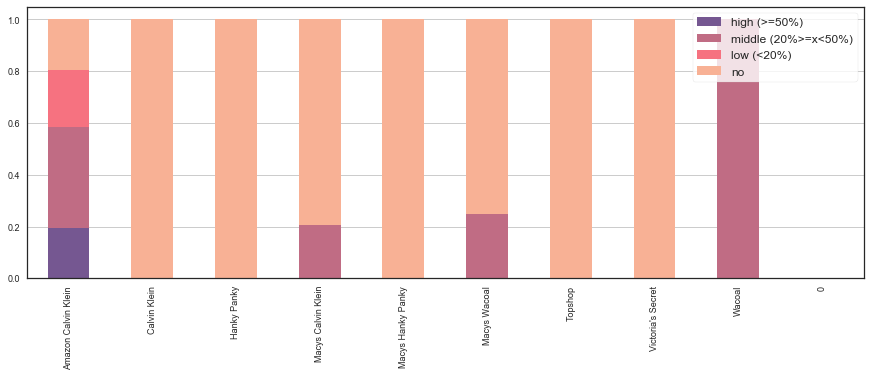

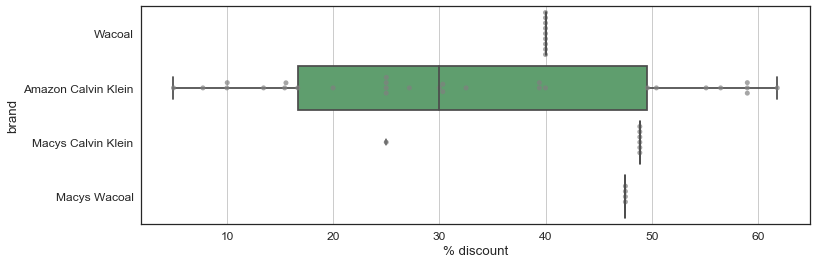

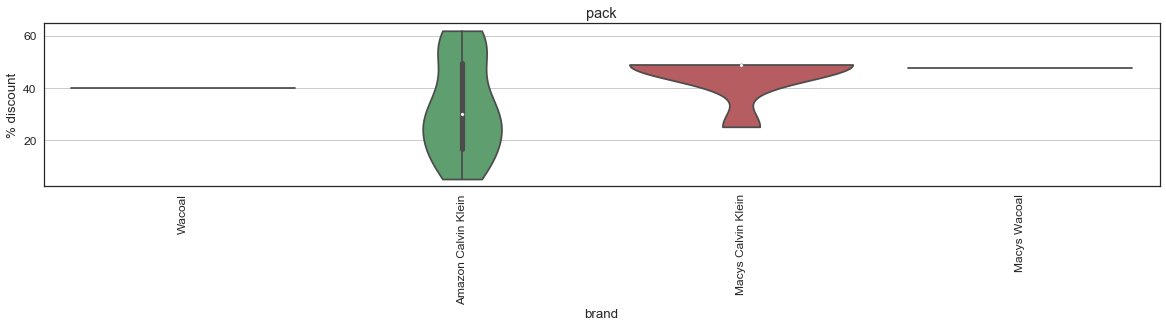

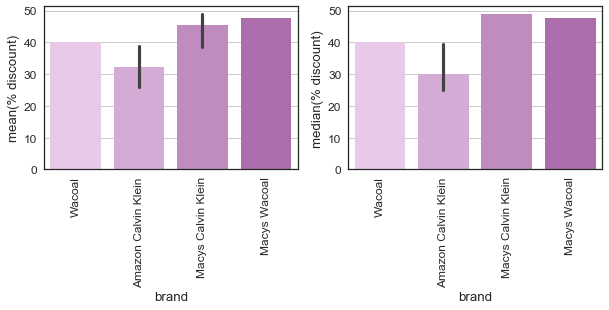

In [101]:
perform_viz('pack', figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

## Sleepwear

brand                Calvin Klein  Hanky Panky  Macys Calvin Klein  \
diff_per_categories                                                  
high (>=50%)         2             0            0                    
middle (20%>=x<50%)  12            0            1                    
low (<20%)           1             0            0                    
no                   32            4            0                    

brand                Victoria's Secret  
diff_per_categories                     
high (>=50%)         0                  
middle (20%>=x<50%)  4                  
low (<20%)           0                  
no                   5

Calvin Klein  Hanky Panky  Macys Calvin Klein  \
high (>=50%)         0.042553      0.0          0.0                  
middle (20%>=x<50%)  0.255319      0.0          1.0                  
low (<20%)           0.021277      0.0          0.0                  
no                   0.680851      1.0          0.0                  

                     Victoria's Secret   0  
high (>=50%)         0.000000          NaN  
middle (20%>=x<50%)  0.444444          NaN  
low (<20%)           0.000000          NaN  
no                   0.555556          NaN

brand   Calvin Klein  Macys Calvin Klein  Victoria's Secret
median  48.74         47.5                33.36

brand  Calvin Klein  Macys Calvin Klein  Victoria's Secret
mean   45.654667     47.5                33.36

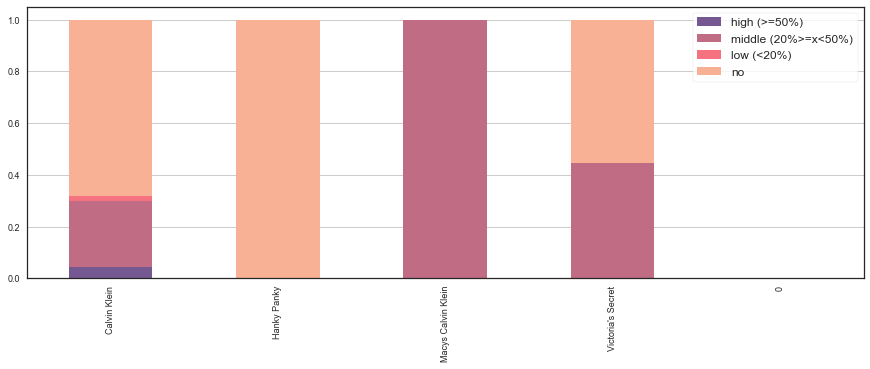

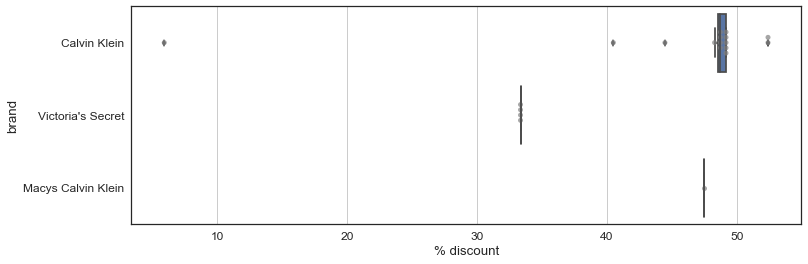

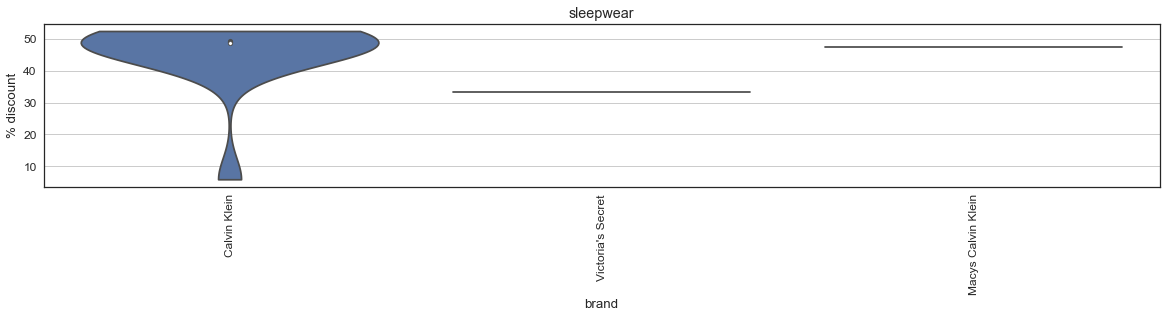

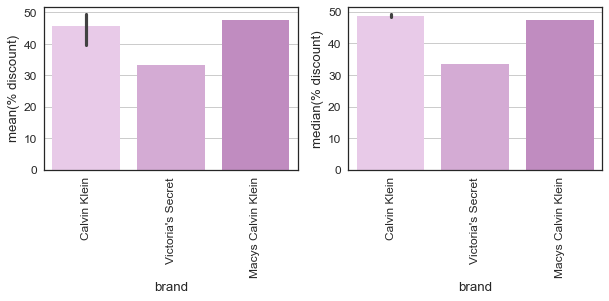

In [102]:
perform_viz('sleepwear', figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

**Other categories**

brand                Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  \
diff_per_categories                                                       
high (>=50%)         0            0                   5                   
middle (20%>=x<50%)  3            4                   0                   

brand                Macys Wacoal  Topshop  Victoria's Secret  Wacoal  
diff_per_categories                                                    
high (>=50%)         0             5        39                 0       
middle (20%>=x<50%)  29            13       100                15

Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  \
high (>=50%)         0.0          0.0                 1.0                 
middle (20%>=x<50%)  1.0          1.0                 0.0                 

                     Macys Wacoal   Topshop  Victoria's Secret  Wacoal   0  
high (>=50%)         0.0           0.277778  0.280576           0.0    NaN  
middle (20%>=x<50%)  1.0           0.722222  0.719424           1.0    NaN

brand   Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
median  33.36        47.5                50.0               30.0           

brand   Topshop  Victoria's Secret  Wacoal  
median  42.86    47.64              40.0

brand  Hanky Panky  Macys Calvin Klein  Macys Hanky Panky  Macys Wacoal  \
mean   33.48        41.875              50.0               31.465517      

brand    Topshop  Victoria's Secret     Wacoal  
mean   45.211667  46.710791          37.333333

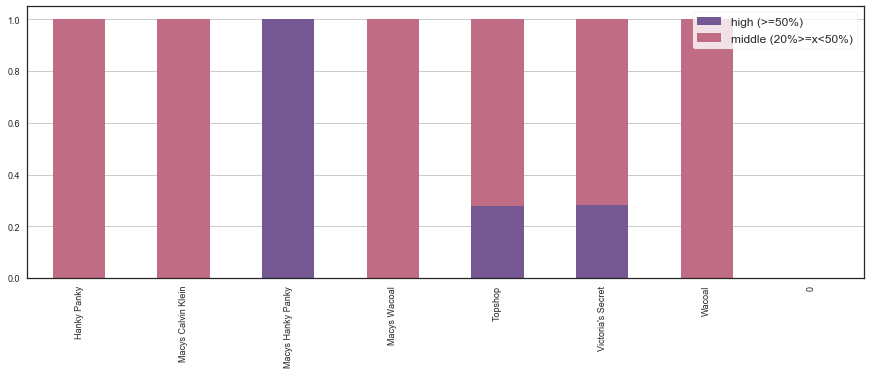

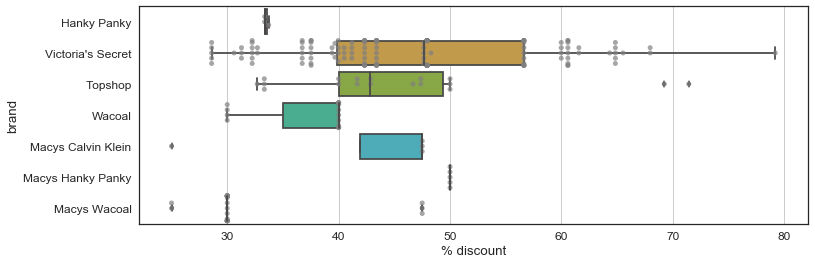

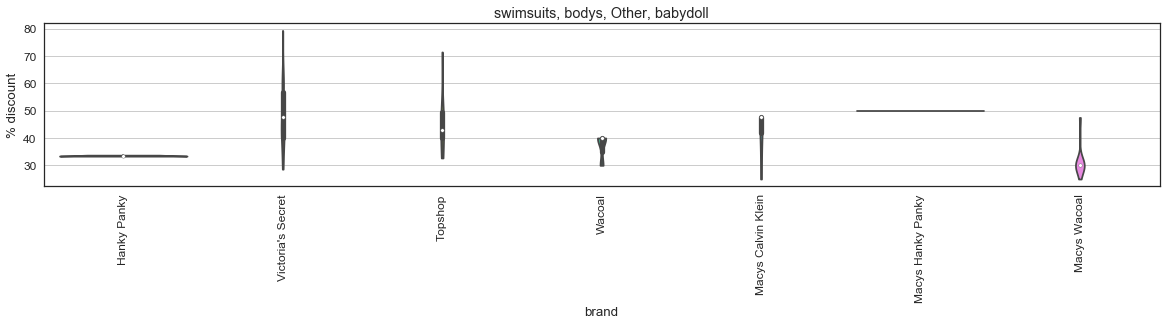

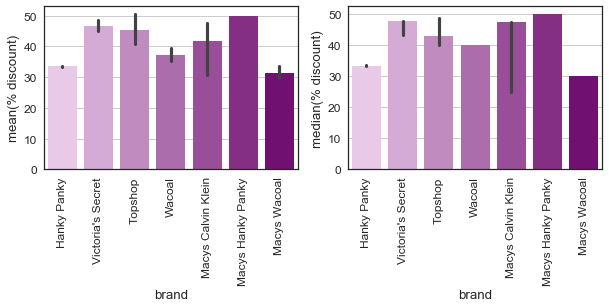

In [103]:
cats = df['category'].unique()
cats = set(cats)- set(['panties', 'bras', 'activewear', 'bralettes', 'pack', 'sleepwear'])
#df1 = brands_info[brands_info['brand'].isin(brands)]
df1 = df[df['category'].isin(cats)]
stacked_all_brands(df1, discount_cat='diff_per_categories')

df1 = df[df['diff_per']>0]
category_plots(cats, df1, swarm = True, money = 'diff_per', xtitle = '% discount',
              figsize1=(12,4), figsize2=(20,3), figsize3=(10,3))

### Price comparison of Calvin Klein vs Victoria's Secret

brand   Calvin Klein  Victoria's Secret
median  16.99         12.99

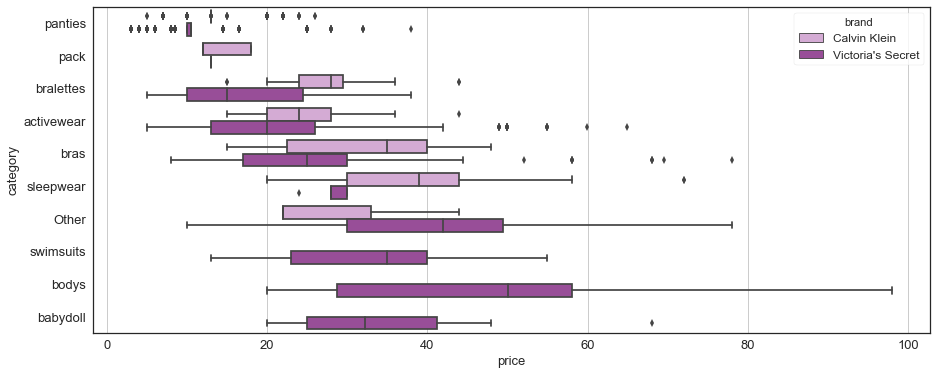

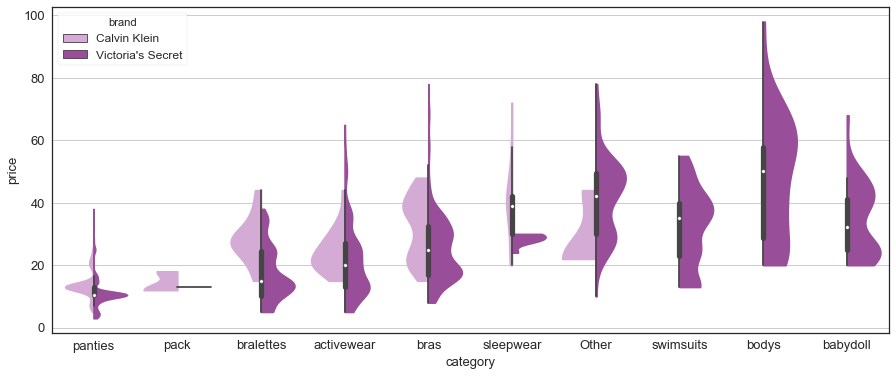

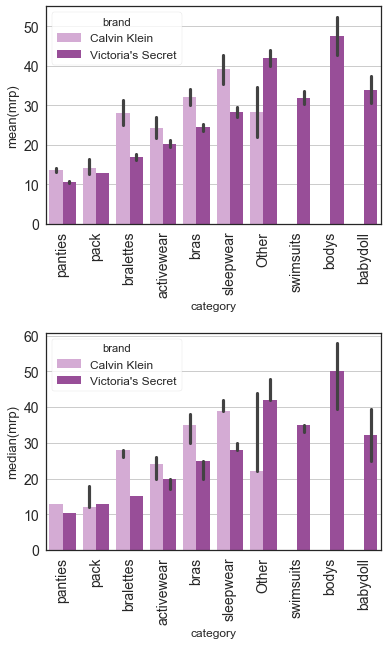

In [104]:
df = brands_info[brands_info['brand'].isin(['Calvin Klein', "Victoria's Secret"])]
df = df[df['product_category']!='Other']
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,6))
ax = sns.boxplot(y = 'category', x="price", hue='brand', data=df, ax=axes, palette = [light_purple[2], light_purple[5]])
#ax = sns.swarmplot(y = 'category', hue = 'brand', x="mrp", data=df, ax = axes, color = 'grey')
_= ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('price', fontsize=13)
ax.set_ylabel('category', fontsize=13)
ax.xaxis.grid(True)
fig.savefig('calvin_victoria_boxplot.png')

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,6))
ax = sns.violinplot(y="price", hue ='brand', x = 'category',cut = 0, split=True, data=df, ax = axes, palette = [light_purple[2], light_purple[5]])
ax.yaxis.grid(True)
_= ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylabel('price', fontsize=13)
ax.set_xlabel('category', fontsize=13)
fig.savefig('calvin_victoria_violin.png')

barplots_extra('price', df, (6,10), hue = 'brand', x='category', palette = [light_purple[2], light_purple[5]])

In [105]:
brands_info.to_csv('data/final_data.csv')

*************

**I will be happy to hear remarks or comments :)**

**Have fun with the data!**
*************